## 1. Retrieve and review raw data - Fitbit device

Back when COVID was fiercly around and detrament to our society, my wife and I decided to buy Fitbit devices in order to encourage us to go outside and keep active. Initially, we used the tracker to monitor the number of steps we took each day and the distances we achieved, however, soon after we became interested in tracking our sleep quality as well. In partciular, we wanted to review our sleep to see whether we were getting a good rest before the future birth of our child. What began as a fun part of our morning routine, quickly became a competition of who would sleep BETTER AND LONGER. This competition quickly became one sided as my wife would normally beat me. Once our child was born, I became interested in checking whether change in our life would affect our sleep quality and if so to what effect.

I have since had a hypothesis that the quality of my sleep (both in terms of score* and length) decreased since the birth of my son (September 2021) and that it would gradually increase to its former levels naturally as they adapted to life.

Caution statement: at the point of starting the analysis it wasn't clear whether I have enough, consistent data to validate or reject the claim.

*note: the Sleep Score by Fitbit is calculated automatically by the device and the methodology is not pulicly available.

### 1a. Methodology Overview
<p>
- Extrapolate raw data from device using the FitbitApp
- Sleep data is extracted in two forms:
    - Sleep data in JSON files
    - Sleep Quality scores in CSV files
- Import the data into a Pandas dataframe
- Start EDA to explore the data and identify potential challenges, problems. 
- Apply data transformations and cleaning methods. 
- Analyze and visualize the clean.
- Summarize key finds
</p>

In [88]:
# Import and install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install os
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install glob

import pandas as pd
from pandas.io.json import json_normalize
import os
import seaborn as sns
import glob
import json
import datetime as dt

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


## 2. Importing Fitbit sleep data
In retrospect, there are three complications that result in a three step process to ensure the data is imported correctly into on dataframe. 
1. Each day of record has one relevant files (JSON) 
2. Each sleep session (period of sleep) is recorded as one record, therefore if there are multiple period of sleep during a day, there will be one record per period in a given day.
3. I identified there were days without data, therefore I needed to fill-in dates that were not in the dataset in that feature but also fill-in values in the related columns - here I took a sum/mean respectively to complete the dataset.

The first point requires to simply join each dataframe together and I decided to concatenate each dataframe into one large dataframe. The second point required combining multiple records that occured on the same day together in a way that was meaningful and that didn't change the context of the data.

In [277]:
# Define files directory 
dir = "Sleep/"

In [278]:
# Import all files with sleep*.json 
files= glob.glob("%s/sleep*.json" % dir)

# Initiate a dataframe
sleep_data = pd.DataFrame()

# Concatenate all files together into one dataframe (there are numereous files)
for file in files:
    with open(file, 'r') as outfile:
        json_data = json.load(outfile)
        json_data = pd.json_normalize(json_data, max_level=0)
        sleep_data = pd.concat([sleep_data, json_data])

In [91]:
# rename columns
columns = ['dateOfSleep', 'startTime', 'endTime', 'duration', 'minutesToFallAsleep', 'minutesAsleep', 
           'minutesAwake', 'minutesAfterWakeup', 'timeInBed', 'efficiency']

# initiate a new dataframe for further analysis
df = pd.DataFrame(sleep_data, columns=columns)

## 3. Exploratory Data Analysis (EDA)

### 3a. Basic Statistical Characteristics

In [92]:
"""
   Initially the datast is comprised of 558 entries and 7 columns. All columns remaining are of type float64,
   the index has been convereted into type DatetimeIndex between (2021-01-07 and 2022-07-18) with a daily
   frequency.
"""
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 23
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateOfSleep          497 non-null    object
 1   startTime            497 non-null    object
 2   endTime              497 non-null    object
 3   duration             497 non-null    int64 
 4   minutesToFallAsleep  497 non-null    int64 
 5   minutesAsleep        497 non-null    int64 
 6   minutesAwake         497 non-null    int64 
 7   minutesAfterWakeup   497 non-null    int64 
 8   timeInBed            497 non-null    int64 
 9   efficiency           497 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 42.7+ KB
None


In [93]:
"""
    Basic statistics highlights (during said timeframe):
    - On average I sleep 399.98 minutes a night or 6.67 hours a night.
    - The longest I slept was 15.45 hours in a 24 hour period.
    - I slept less than 2 hours one day.   
"""

# Basic statistics of each variable
df.describe()

,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency
count,4.970000e+02,497.0,497.000000,497.000000,497.000000,497.000000,497.000000
mean,2.212950e+07,0.0,317.899396,50.772636,0.424547,368.824950,91.863179
std,9.184477e+06,0.0,129.840480,26.464116,1.400907,153.074617,4.205099
min,3.600000e+06,0.0,51.000000,0.000000,0.000000,60.000000,76.000000
25%,1.458000e+07,0.0,203.000000,36.000000,0.000000,243.000000,89.000000
50%,2.538000e+07,0.0,365.000000,54.000000,0.000000,423.000000,92.000000
75%,2.880000e+07,0.0,414.000000,70.000000,0.000000,480.000000,95.000000
max,4.098000e+07,0.0,575.000000,142.000000,11.000000,683.000000,100.000000


In [94]:
# Statisical overview of non-numerical features
df.describe(include=["object", "bool"])

,dateOfSleep,startTime,endTime
count,497,497,497
unique,395,479,479
top,2021-03-06,2021-02-04T00:13:00.000,2021-02-04T07:21:30.000
freq,6,2,2


In [95]:
# Check the orientation of the data (rows vs 'features'(columns))
print(df.shape)

(497, 10)


### 3b. Column Definitions

timeInBed (in minutes) = minutesAsleep + minutesAwake

minutesAsleep = sleeping

duration = timeInBed (milliseconds)

minutesAfterWakeup ?

#"efficiency" can be defined as an algorithm based on collected sleep metrics to determine how efficient the user slept. Unfortunately, we can't go into any more detail than this.

"activeScore" is a value we're still working on defining. I'll go ahead and create a ticket to have this definition documented, and I'll let you know when it's live.

- logId does not add value
- logType does not add value
- mainSleep does not add value
- duration is time in milliseconds

Irrelevant columns - startTime, endTime as both columns contain the same data as 'duration'
logId - unique id of the dataset but have chosen to replace this with date as the unique / index of the 
dataset by accumulating several records for a given date (this could happen in case I had fallen asleep more than once a day , type, infoCode, logType - non descriptive columns and values that do not add anything and thus removed from 
the analysis

### 3c. Identifying Missing Value
The date range in the dataset spans 2021-01-07 to 2022-07-18. Within the date range, I've identified through the code below that there are 163 dates missing.
- Original dataset as is holds 497 records
- 558 days exist between 2021-01-07 and 2022-07-18
- 163 days are missing - there are no records for these days
- A closer look establishes there is no record for 29.1% of days in this date range. A significant number, potentially hindering the analysis.
- Especially since no records exist for 2021-07, 2021-8, 2021-09 which are prior to the birth including the birth month itself.

This suggests two issues:
- There are missing days within this data range and dataset
- There are multiple records that are attributed to the same day (i.e multiple sleep session within 24 hours was
recorded.

In [ ]:
# Minimum date within the data range 'dateOfSleep'
df['dateOfSleep'].min()   # 2021-01-07

# Maximum date within the data range 'dateOfSleep'
df['dateOfSleep'].max() # 2022-07-18

In [136]:
# Convert 'dateOfSleep' to datetime
df_test['dateOfSleep'] = pd.to_datetime(df_test['dateOfSleep'])

# GroupBy 'dateOfSleep' by Month-Year to check how many records there are per month, identifying missing dates and
# multiples of records in a given day
df_test['dateOfSleep'].groupby(df_test.dateOfSleep.dt.to_period("M")).agg('count')
# df_test['dateOfSleep'].groupby(df_test.dateOfSleep.dt.to_period("D")).agg('count')

dateOfSleep
2021-01    25
2021-02    30
2021-03    38
2021-04    32
2021-05    33
2021-06    20
2021-10    43
2021-11    52
2021-12    35
2022-01    13
2022-02    30
2022-03    33
2022-04    25
2022-05    38
2022-06    31
2022-07    19
Freq: M, Name: dateOfSleep, dtype: int64

In [97]:
# Check missing-values (dateOfSleep): are there records per each date in range
missing_values = df

# Setting the Date values as index
missing_values = missing_values.set_index('dateOfSleep')

# to_datetime() method converts string 
# format to a DateTime object
missing_values.index = pd.to_datetime(missing_values.index)

# dates which are not in the sequence are returned
print(pd.date_range(start=missing_values.index.min(), end=missing_values.index.max(), freq='D').difference(missing_values.index))

# missing_values.reindex(pd.date_range(start='2021-01-07', end='2022-07-18', freq='D')).isnull().all(1)

DatetimeIndex(['2021-01-08', '2021-02-23', '2021-03-08', '2021-03-10',
               '2021-04-15', '2021-05-30', '2021-05-31', '2021-06-20',
               '2021-06-21', '2021-06-22',
               ...
               '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15',
               '2022-04-20', '2022-04-21', '2022-06-01', '2022-06-20',
               '2022-06-21', '2022-07-10'],
              dtype='datetime64[ns]', length=163, freq=None)


In [98]:
"""    
    I identified that there are dates missing within the dataset. In this case, not only 
    are there no values available for dates (inherently days when the device was off or
    when I wasn't wearing it) but the device does not register a record for that day 
    entirey. In order to analyze the data later in a timeseries, I am required
    to add records for those missing days.

    Originally there are 497 records
    Minimum Date (2021-01-07)
    Maximum Date (2022-07-18)
    
    Total records after adding missing dates - 557
    Which meaning there were 60 days during this timeframe where no data existed
"""
# Count missing values for each column in running data
df.isnull().sum()

dateOfSleep            0
startTime              0
endTime                0
duration               0
minutesToFallAsleep    0
minutesAsleep          0
minutesAwake           0
minutesAfterWakeup     0
timeInBed              0
efficiency             0
dtype: int64

## 4. Data Transformation and Cleaning

In [99]:
"""
    Remove ['startTime', 'endTime'] columns:
    
    1 - as these columns cannot be aggregated. We are required to aggregated the data as we identified that 
    there could be multiple records for a day which is a result of capturing multiple sessions of sleep
    during a 24 hour period. In order to analyse the data effectively and within a timeseries this tranformation
    is vital.
    
    2 - are unnecessary as the 
    information there is captured through the 'minutesAsleep' and 'duration', depicting the length of time
    the wearer was asleep.
"""

# Drop the two unnecessary columns
df = df.drop(columns=['startTime', 'endTime'])

# Define which aggregation functions should be used for each column
aggregation = {'duration':'sum', 'minutesToFallAsleep':'sum', 'minutesAsleep':'sum', 
           'minutesAwake':'sum', 'minutesAfterWakeup':'sum', 'timeInBed':'sum', 'efficiency':'mean'}

In [100]:
"""
    We identified in addition that there are dates within the dataset that do not exist entirely, this is said to 
    be as I wasn't wearing the device on that date properly since it was charged and then forgotten or similar.
    In order to overcome this issue, I am forced to create a complete date range (all_days) and plug
    this date as the index of the dataframe to Group By the data and later fill in those records that have
    no values (further down the code)
"""
# Set 'dateOfSleep' as index of the dataframe
pd.DatetimeIndex(df['dateOfSleep'])

# Save 'dateOfSleep' into a new column 'date'
df['date'] = df['dateOfSleep']

# Set 'date' as the new index in place of the current one (0,1,2...n)
df.set_index('date', inplace=True)

# Get all days between min/max availale in dataset (as there are missing dates)
all_days = pd.date_range(df['dateOfSleep'].min(), df['dateOfSleep'].max(), freq='D')

# Transform the range into a Pandas Series
all_days = pd.to_datetime(all_days, errors='coerce')
all_days = all_days.to_series()

# Set Index as value of 'date' column 
df['date'] = pd.Series(all_days)
df.set_index('date', inplace=True)

# Groupby date (yyyy-mm-dd) as there are might be multiple records for given days
df = df.groupby('date').agg(aggregation)

In [101]:
"""
    Add missing dates into index
    Find min and max dates and create Daily Range Frequency
    Reindex dataset with entire date range to include missing Dates
"""

# Retrieve all dates within the date range
all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
all_days = pd.to_datetime(all_days, errors='coerce')

# Convert index to DatetimeIndex
df.index = pd.DatetimeIndex(df.index)

# Reindex the dataframe index to the date range
df = df.reindex(all_days)

In [102]:
""" 
    Fill in records that are missing data (for those days that were not captured by the device
    with average of each column respectively.
    
    duration 
    minutesToFallAsleep 
    minutesAsleep 
    minutesAwake 
    minutesAfterWakeup 
    timeInBed 
    efficiency
"""

# Finding and capturing the average for each column
avg_duration = df['duration'].mean()
avg_minutesToFallAsleep = df['minutesToFallAsleep'].mean()
avg_minutesAsleep = df['minutesAsleep'].mean()
avg_minutesAwake = df['minutesAwake'].mean()
avg_minutesAfterWakeup = df['minutesAfterWakeup'].mean()
avg_timeInBed = df['timeInBed'].mean()
avg_efficiency = df['efficiency'].mean()

# Filling missing values with counted means  
df['duration'].fillna(avg_duration, inplace=True)
df['minutesToFallAsleep'].fillna(avg_minutesToFallAsleep, inplace=True)
df['minutesAsleep'].fillna(avg_minutesAsleep, inplace=True)
df['minutesAwake'].fillna(avg_minutesAwake, inplace=True)
df['minutesAfterWakeup'].fillna(avg_minutesAfterWakeup, inplace=True)
df['timeInBed'].fillna(avg_timeInBed, inplace=True)
df['efficiency'].fillna(avg_efficiency, inplace=True)

### 5. Exploratory Data Analysis (EDA)

In [103]:
"""
     EDA - Continued
"""

# Count minutesToFallAsleep mean --> 0.0, it seems like this feature isn't captured by the fitbit device
df['minutesToFallAsleep'].mean()

# Count minutesAsleep mean in hrs = 6.66 hrs
df['minutesAsleep'].mean()
df['minutesAsleep'].mean()/60

# Count minutesAwake mean --> avg 63.88 minutes - not sure what this feature means
# df['minutesAwake'].mean()

# Count minutesAfterWakeup mean --> avg 0.534 minutes not sure what this feature means
# df['minutesAfterWakeup'].mean()

# Count timeInBed mean --> avg 6.73 hrs or avg of 404.33 minutes
# df['timeInBed'].mean()
# df['timeInBed'].mean()/60

## Checkout the statistics of column X while enforcing normalisation of the value (remove scientific notation)
df['minutesAsleep'].describe().apply(lambda x: format(x, 'f'))

count    558.000000
mean     399.989873
std       77.298600
min      113.000000
25%      373.000000
50%      399.989873
75%      417.500000
max      928.000000
Name: minutesAsleep, dtype: object

### 6. Data Visualization

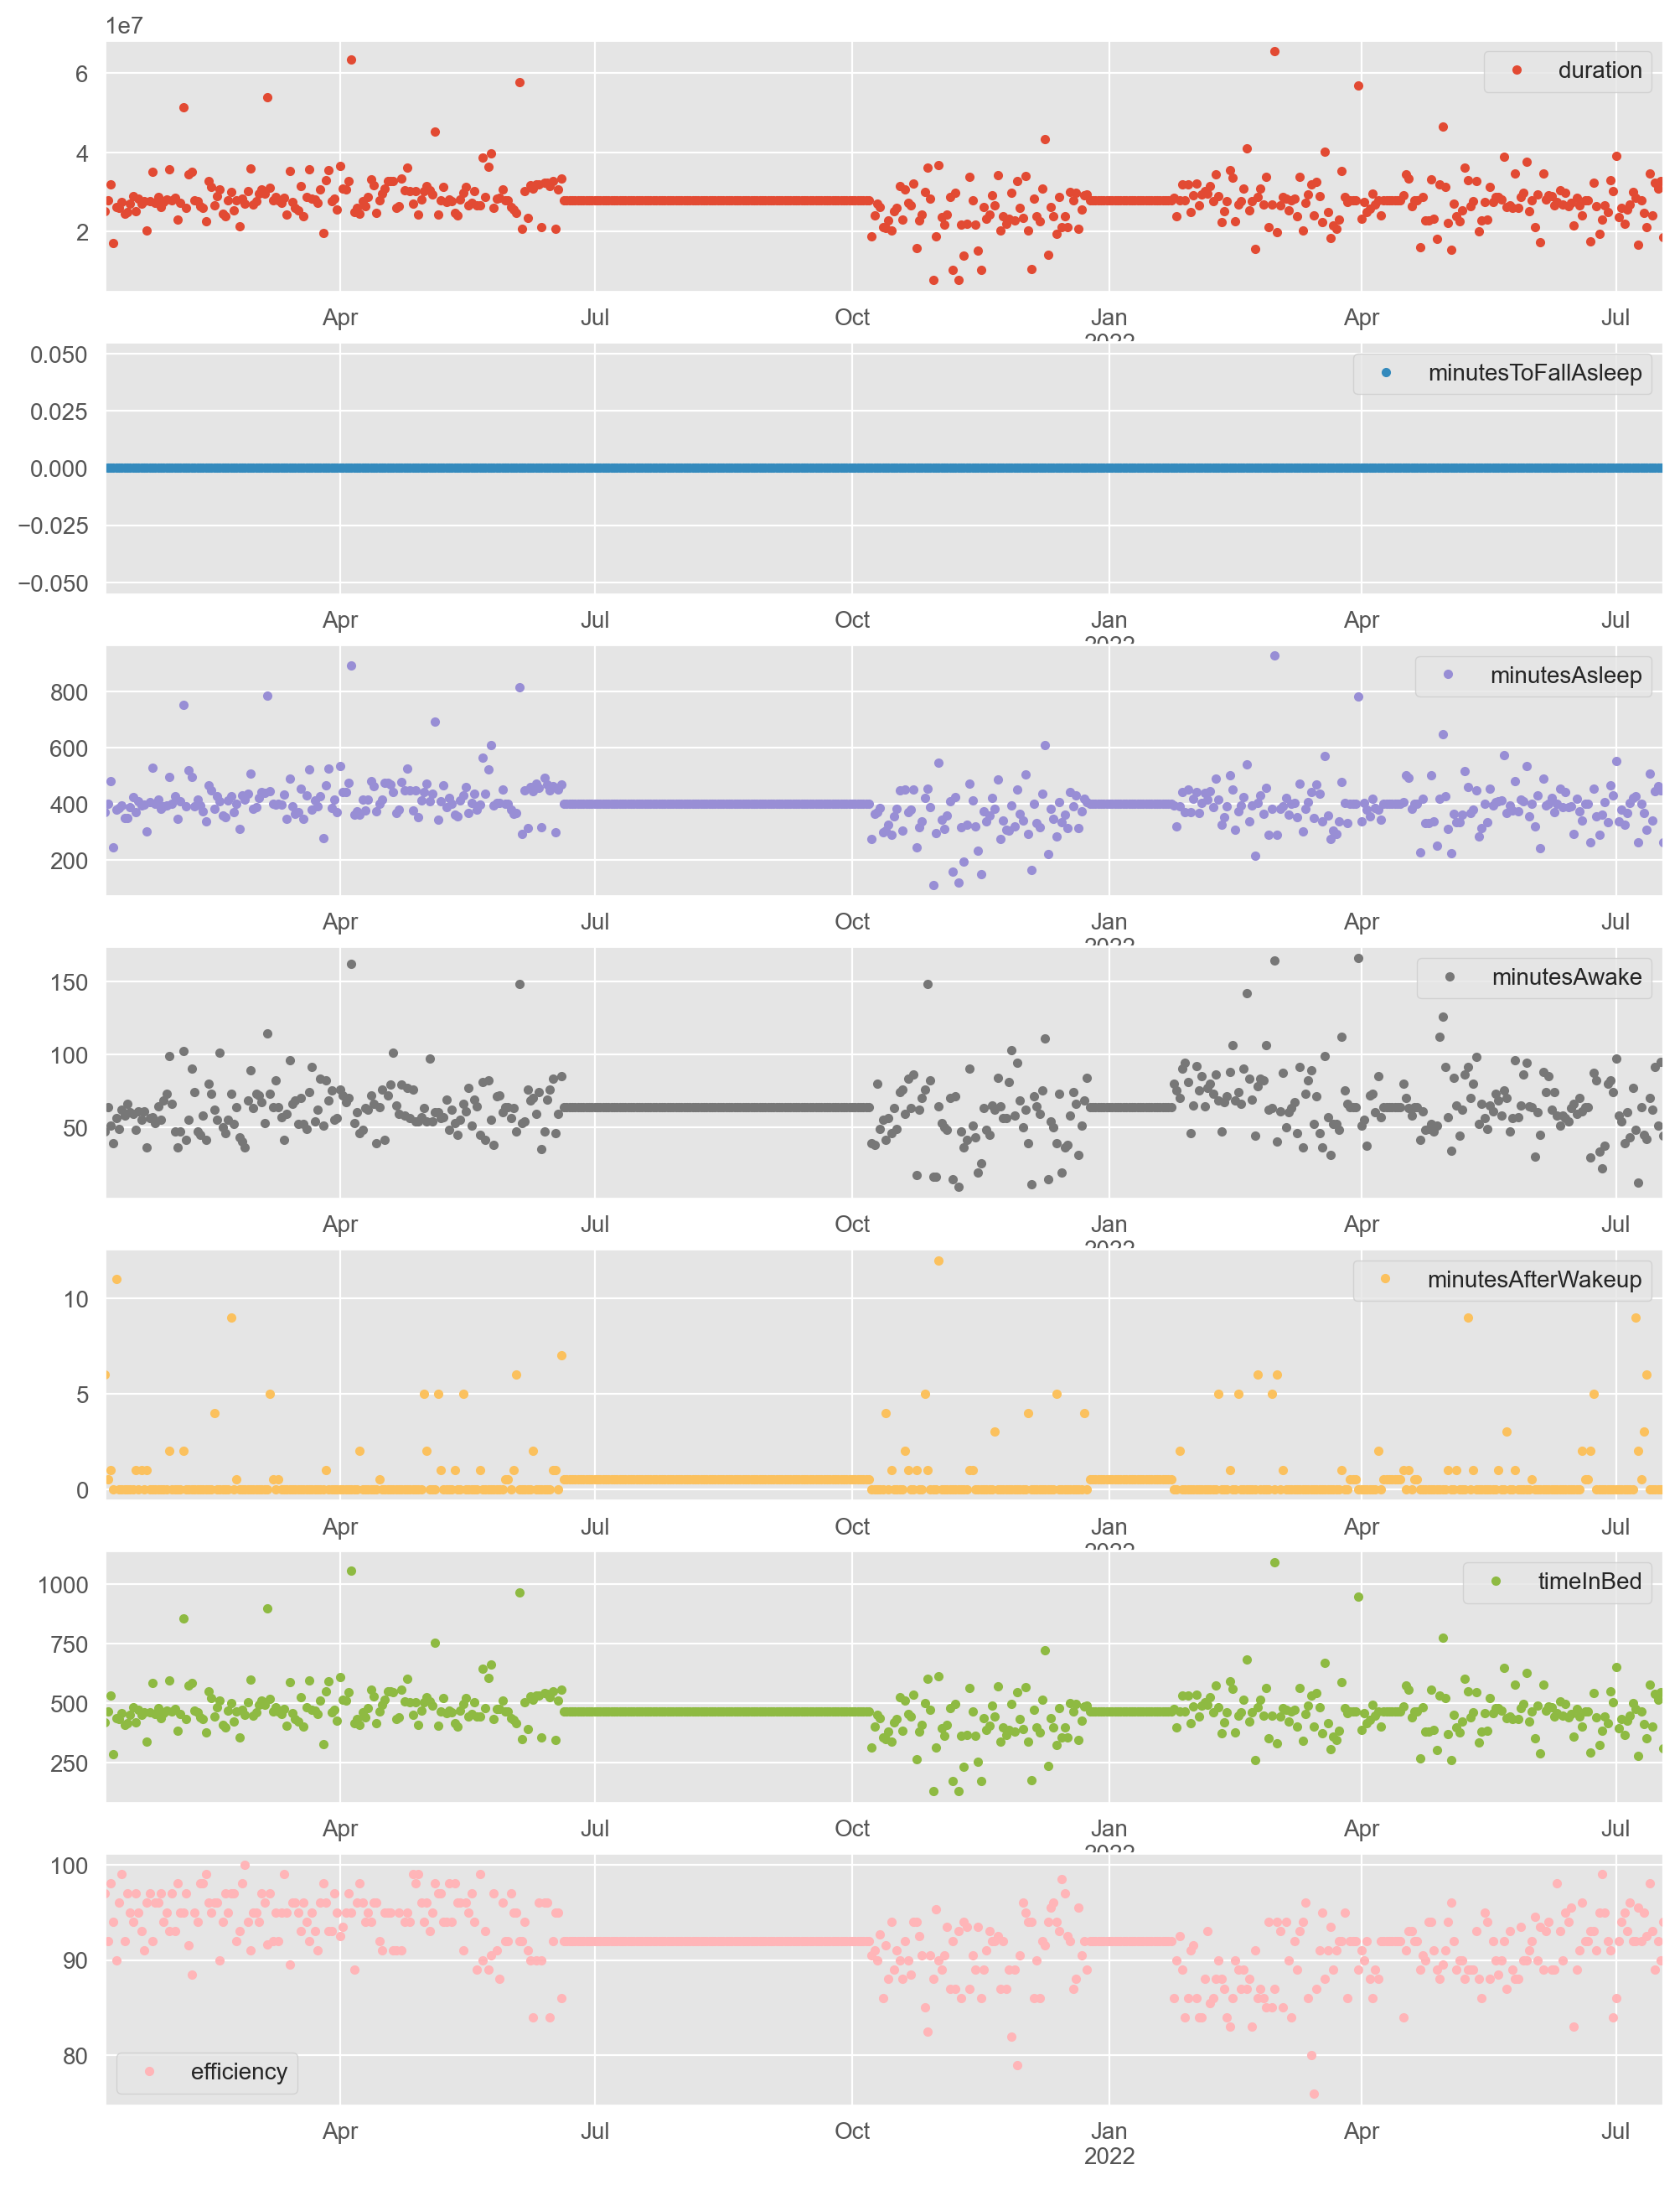

In [104]:
"""
   Visualizing the data, column by column to check for trends, distribution, mapping
   
   minutesAsleep - visually it seems from September 2021 onwards a majority of the times the sleep hits 
   under 400 minutes (avg 399.98) which suggests that my theory of sleeping less time after the birth 
   could be supported and correct
   
   It is quite clear to see the affect of filling in the missing data with the mean
   during July, August, September as the data points during this span are flat compared to the rest of the time
   series.
"""

%matplotlib inline

## Import matplotlib, set style and ignore warning
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

plt.style.use('ggplot')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.')
)

## Create, plot and customize in one step
df.plot(
       subplots=True,
       sharex=False,
       figsize=(12,16),
       linestyle='none',
       marker='o',
       markersize=3,
             )

## Show plot
plt.show()

In [140]:
"""
    Deep dive into my sleep Statistics 
"""

# What is the average time you are asleep?
avg_minutesAsleep = df['minutesAsleep'].mean()
print('On average, within the sampled time period, I have slept, {0} minutes'.format(avg_minutesAsleep))

# Have you been sleeping worse since Coby was born?

# df_short.head()


# Calculate Monthly statistics
# print('How my average sleep looks in last 4 years:')
# display(df.resample('A').mean())


# Calculate Monthly statistics
# print('How my average sleep looks in last 1.5 years (Monthly):')
# display(df.resample('M').mean())

# # Calculate Weekly statistics
# print('How my average sleep looks in last 1.5 years (Weekly):')
# display(df_aggregated.resample('W').mean())

# Calculate weekly statistics
# print('Weekly averages of last 4 years:')
# display(runs_subset_2015_2018.resample('W').mean().mean())

# # Mean monthly counts
# monthly_counts_average = df_aggregated['duration'].resample('M').count().mean()
monthly_average = df['minutesAsleep'].resample('M').mean()
# print('How many recorded sleep per month I had on average:', monthly_counts_average)
print(monthly_average)

On average, within the sampled time period, I have slept, 399.9898734177215 minutes
2021-01-31    394.799595
2021-02-28    422.321067
2021-03-31    423.321927
2021-04-30    444.532996
2021-05-31    434.902572
2021-06-30    421.429620
2021-07-31    399.989873
2021-08-31    399.989873
2021-09-30    399.989873
2021-10-31    359.707391
2021-11-30    341.100000
2021-12-31    375.675133
2022-01-31    398.798938
2022-02-28    398.678571
2022-03-31    415.482891
2022-04-30    395.630295
2022-05-31    394.774194
2022-06-30    384.665654
2022-07-31    390.777215
Freq: M, Name: minutesAsleep, dtype: float64


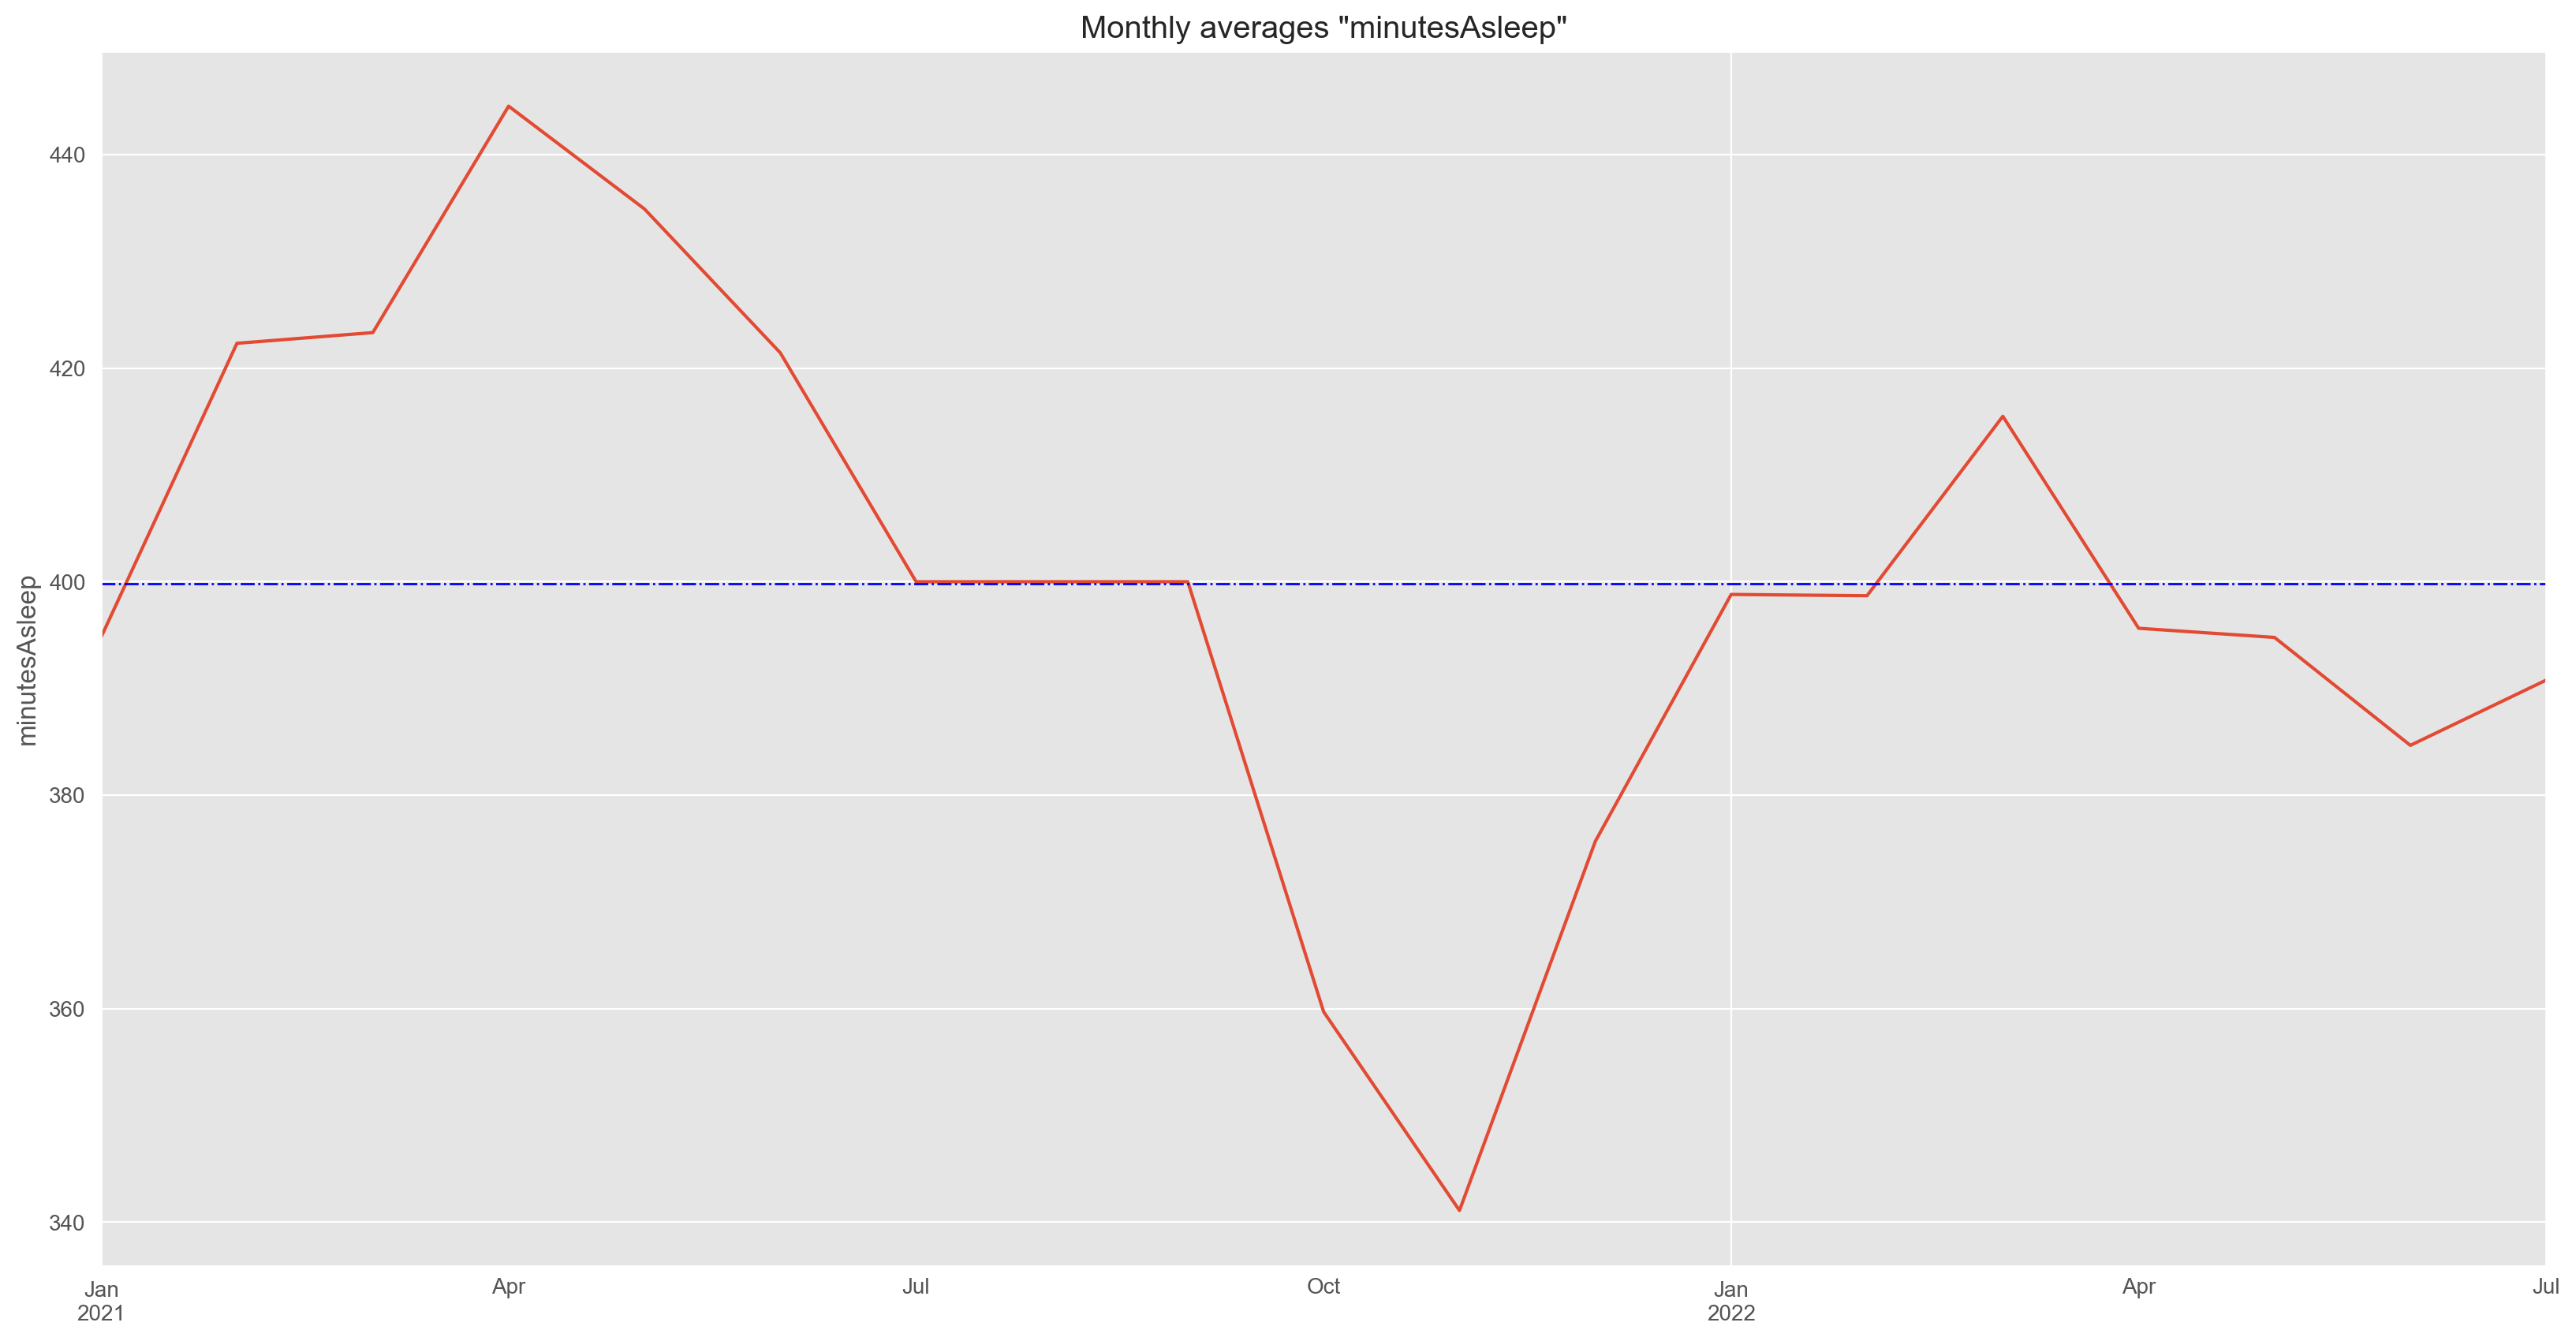

In [106]:
# Plot and customize first subplot
fig, (ax1) = plt.subplots(1,sharex=True, figsize=(20,10))
monthly_average.plot(ax=ax1)

ax1.set(ylabel='minutesAsleep', title='Monthly averages "minutesAsleep"')
ax1.axhline(monthly_average.mean(), color='blue', linewidth=1, linestyle='-.')

# Show plot
plt.show()

In [179]:
monthly_mean = df.loc['2021-04-01':'2021-07-01'].resample('M').mean()
print(monthly_mean)

                duration  minutesToFallAsleep  minutesAsleep  minutesAwake  \
2021-04-30  3.072013e+07                  0.0     444.532996     67.462785   
2021-05-31  2.976025e+07                  0.0     434.902572     61.089261   
2021-06-30  2.923145e+07                  0.0     421.429620     65.690633   
2021-07-31  2.784395e+07                  0.0     399.989873     63.883544   

            minutesAfterWakeup   timeInBed  efficiency  
2021-04-30            0.084473  512.002194   94.598917  
2021-05-31            0.679624  496.004247   94.175323  
2021-06-30            0.795865  487.190802   92.054754  
2021-07-31            0.534177  464.065823   91.967511  


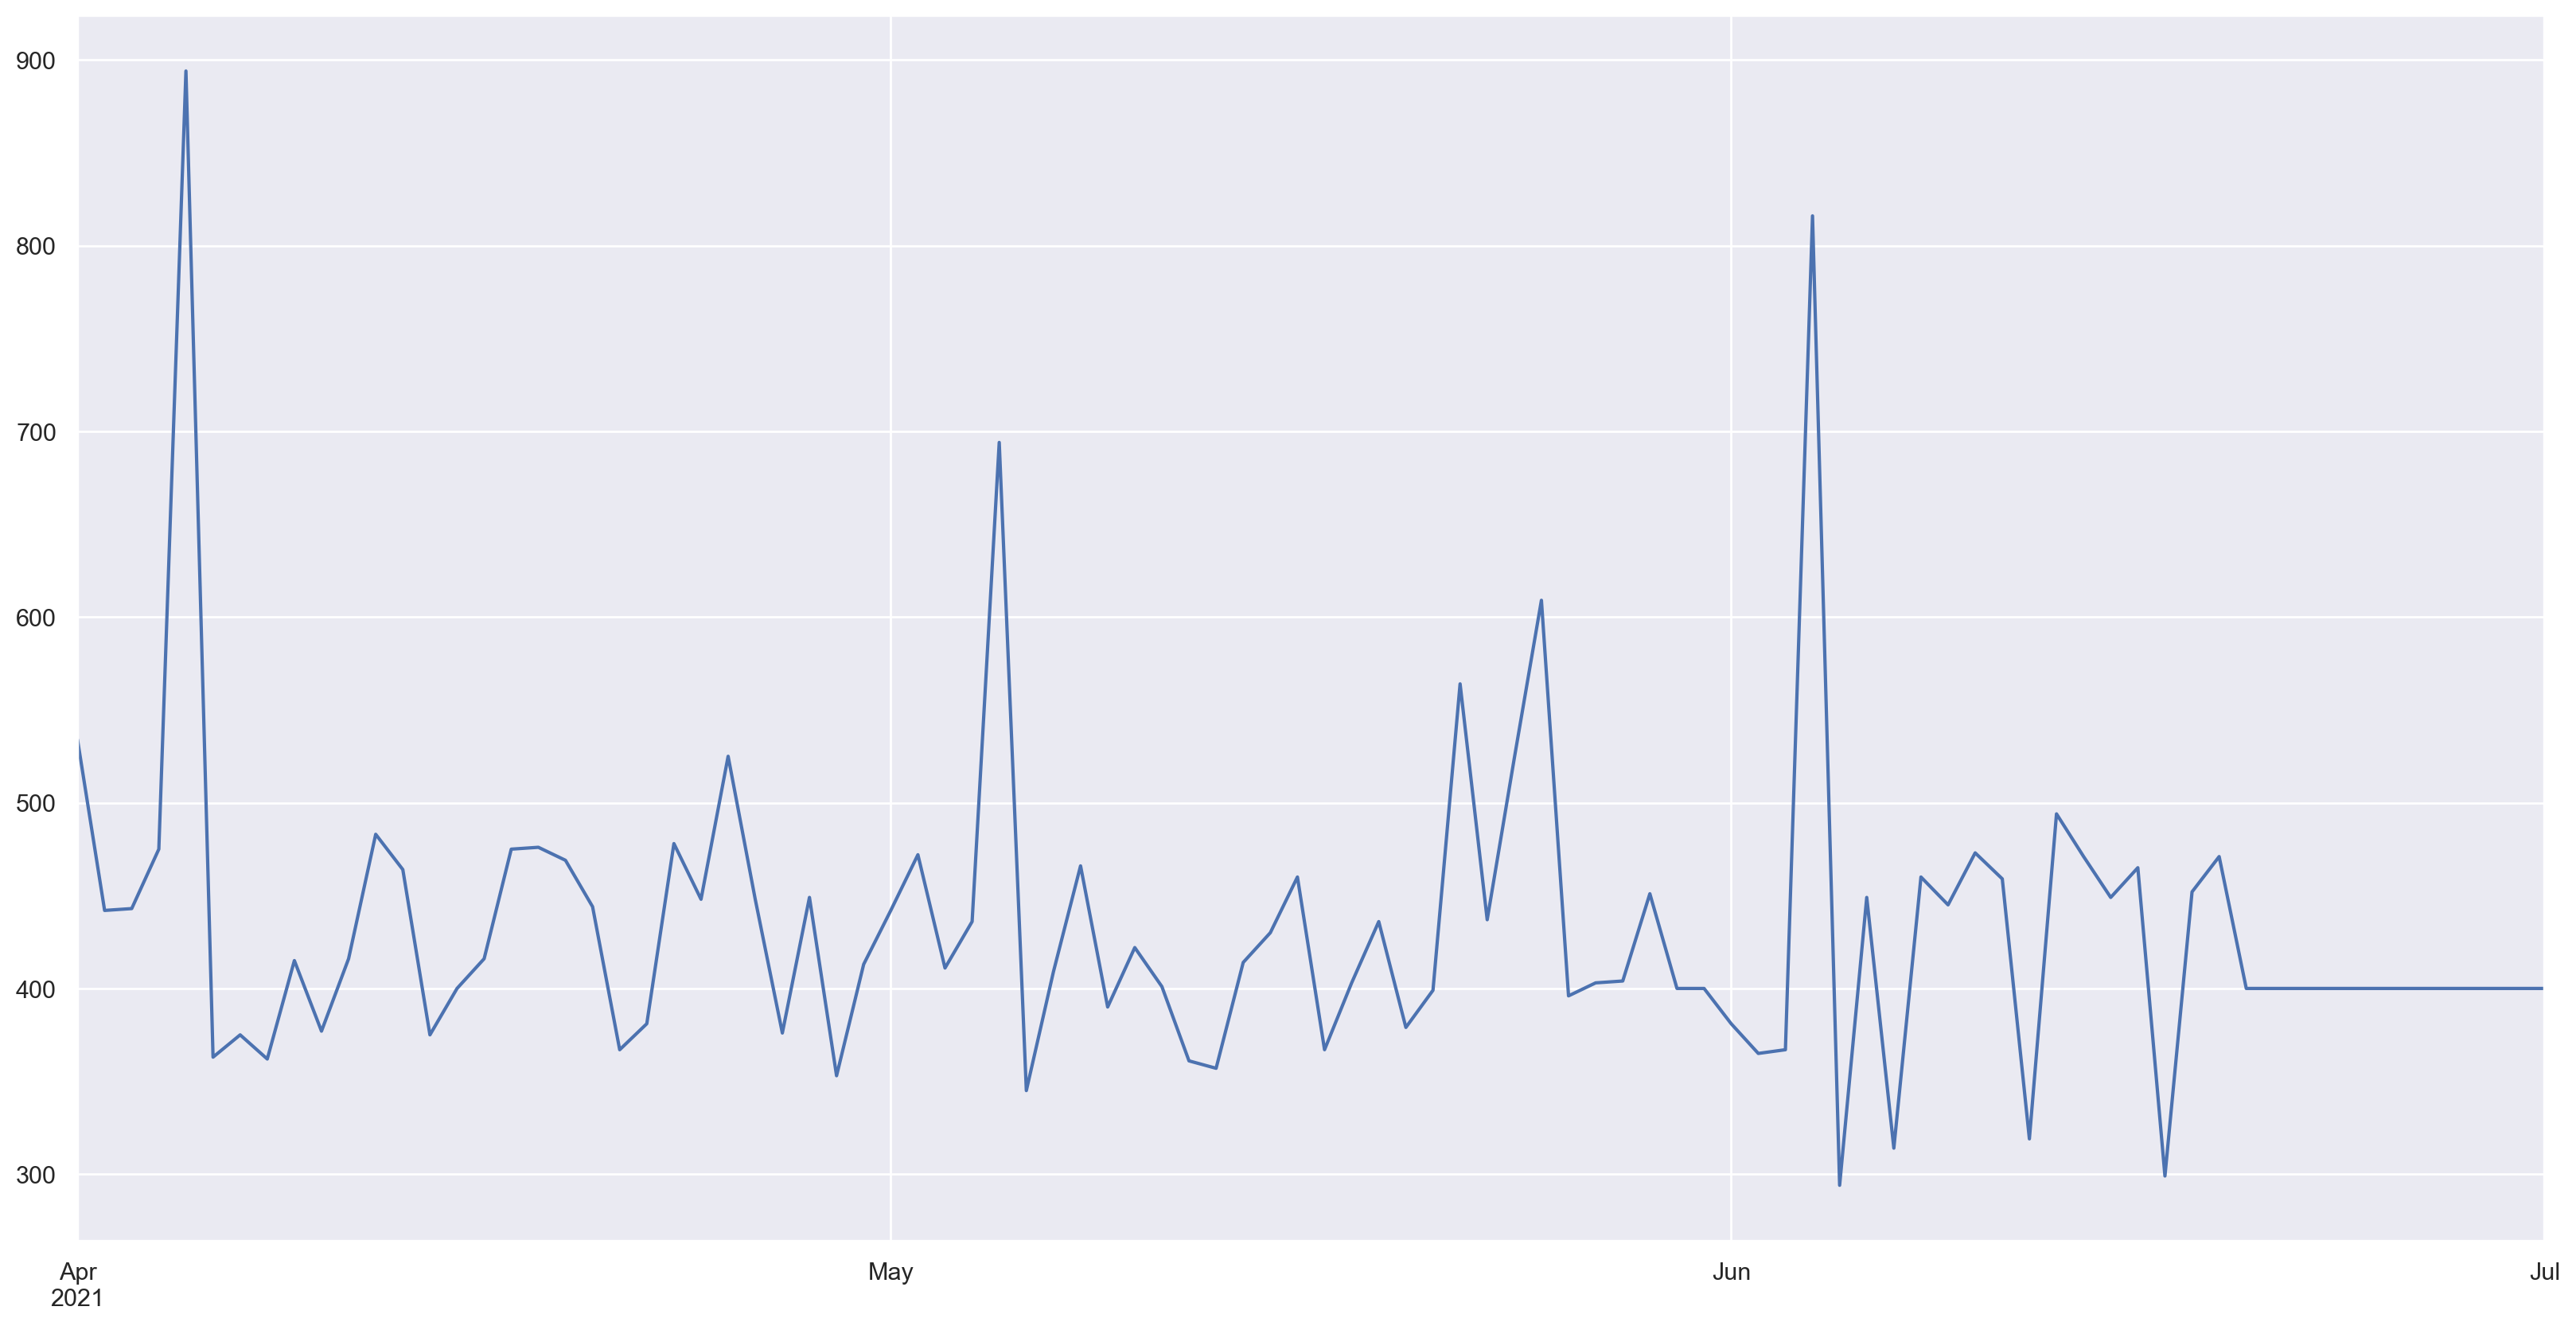

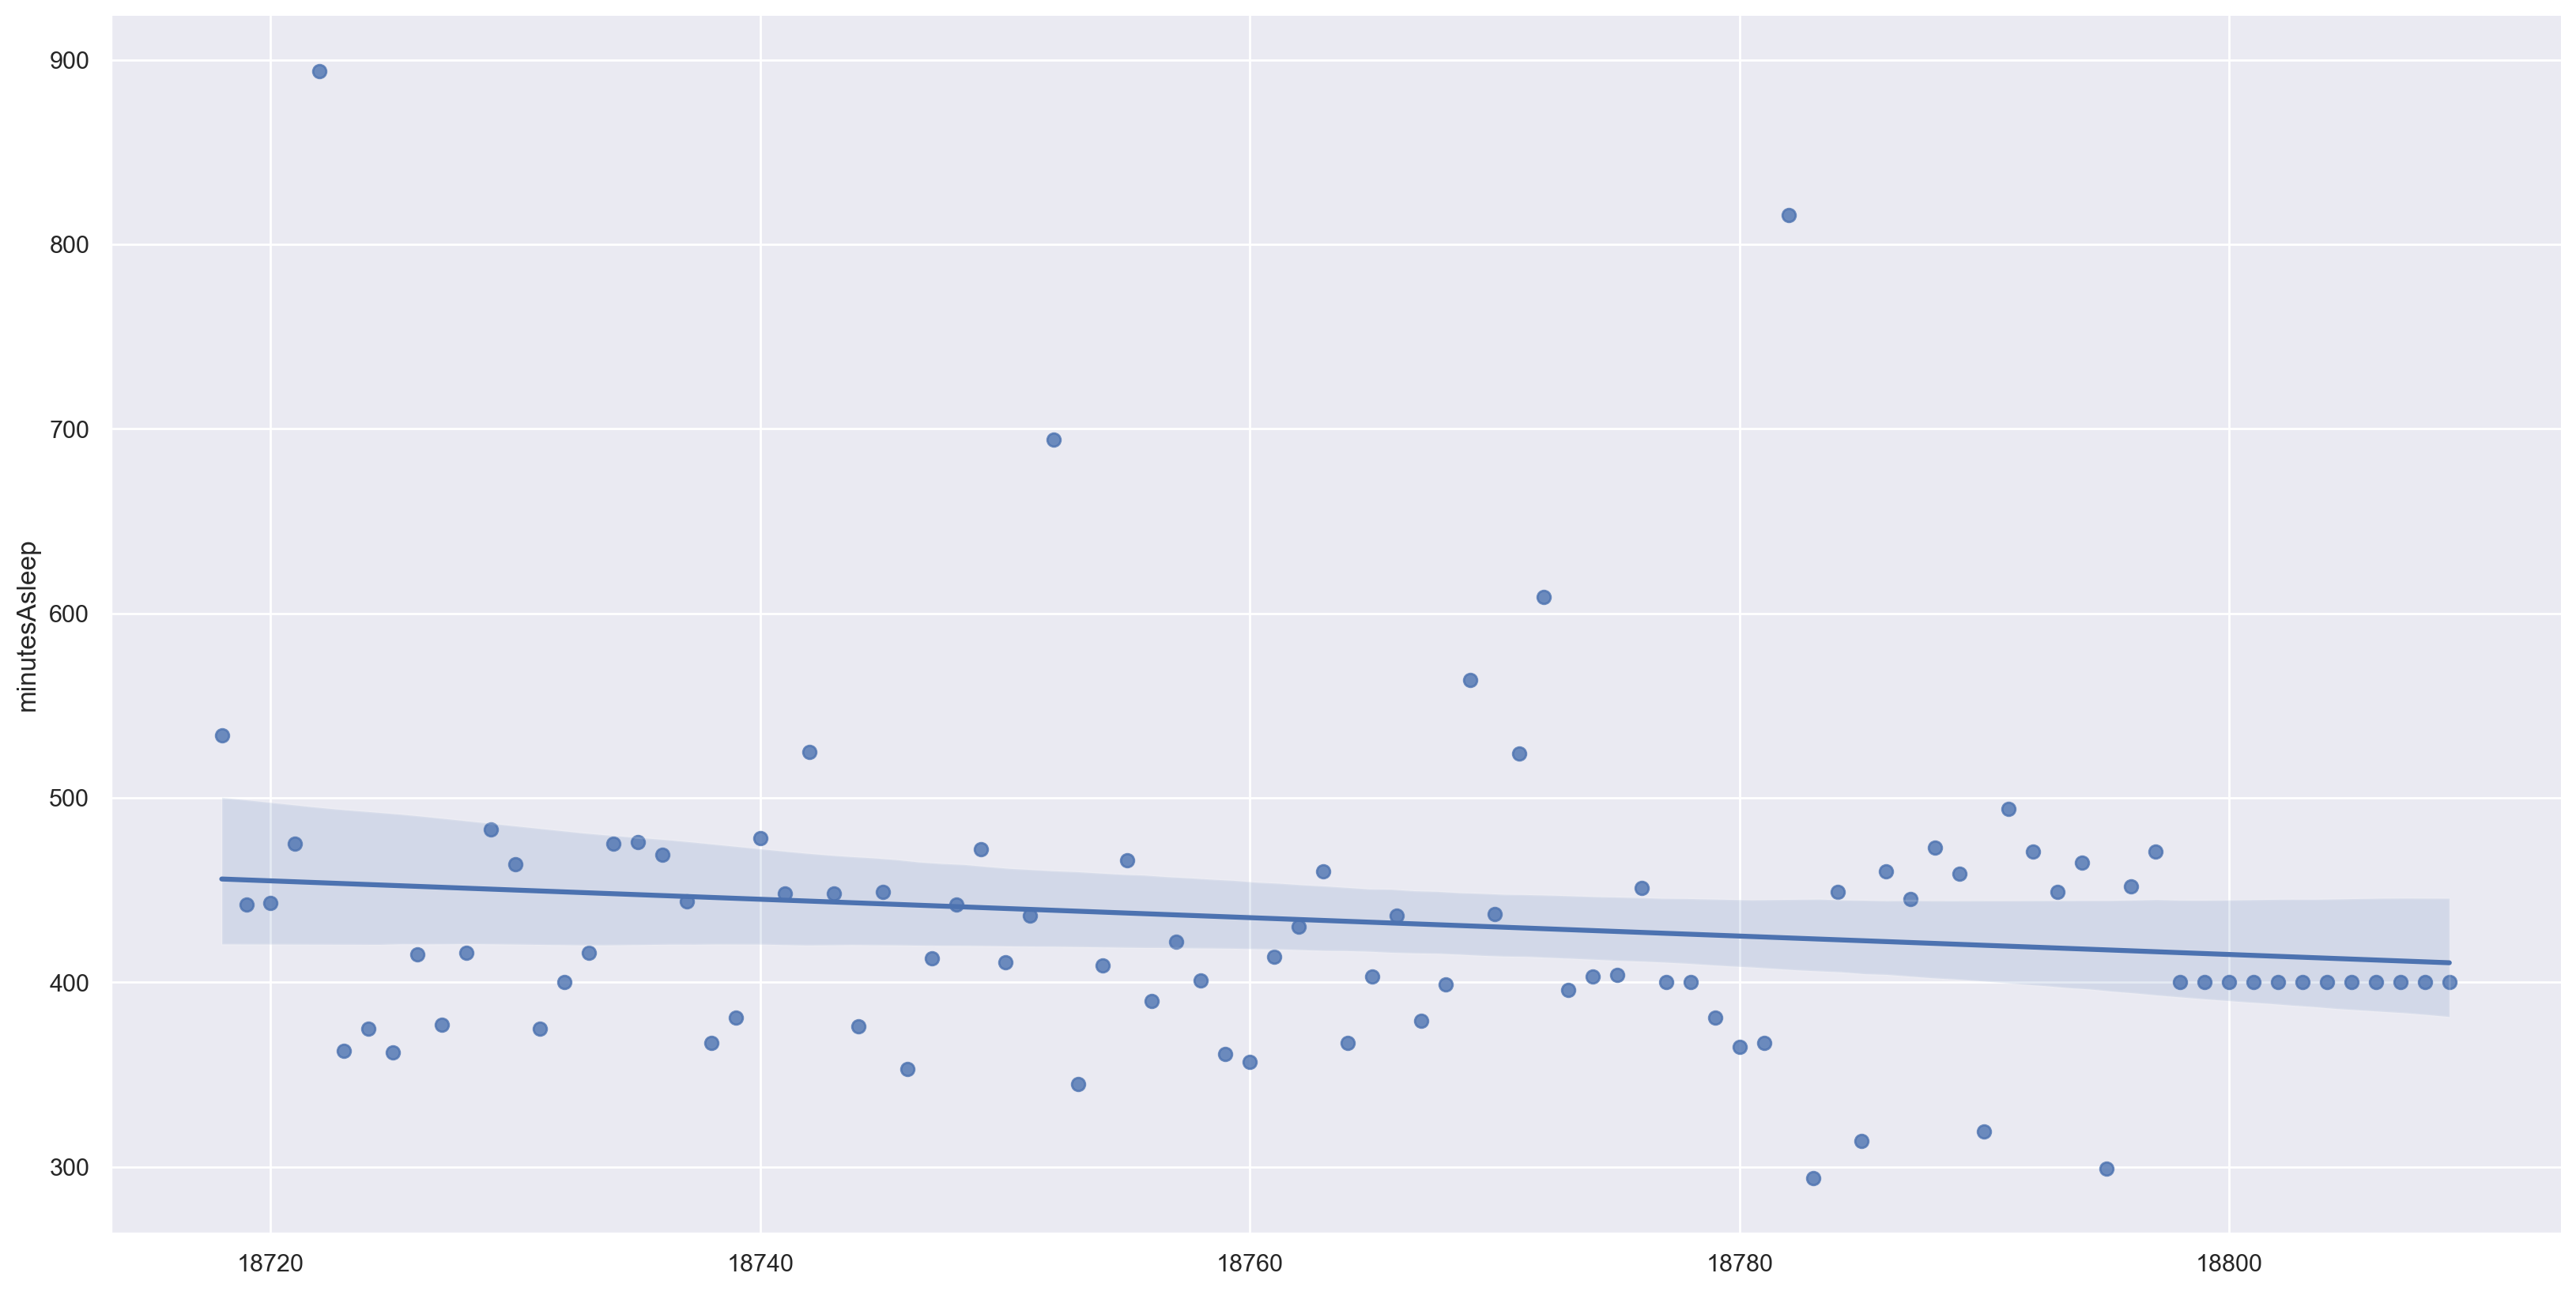

In [201]:
import matplotlib.dates as dates
""""
    Slice dataset to a 3-month period before birth (also excluding 2021-07 - 2021-09 since there is no data)
    The logic here is to look closer to the period prior to the birth rather across the whole timeline to
    identify whether we can see evidence suggesting the state of sleep then given that we have a lack of
    data in the most relevant time.
    
    In the top chart, we can see a number of findings:
    - there are three days where I slept in total over 680 minutes (more than ten hours)
    - i've sleept less than 300 minutes (or five hours) only once during this period
    - the majority of days I slept within the 400-500 minutes mark (6.6h - 8.3h)
    
    In the bottom chart, the findings suggest:
    - it is clear to see the regression shows a downwards trend, depicting that during this period 
    the number of minutes I slept on average decreases
    - during this time the confidence interval band grith reduces (especially in the middle of the said period), 
    clustering together to illustrate that the minutes of sleep became more consistent and fell within a smaller
    range 480-420 minutes during this period
"""
# Slice of data from the 04-2021 to 07-2021
minutes_asleep_short = df.loc['2021-04-01':'2021-07-01'].resample('D').mean()

# Plot and customize first subplot
minutes_asleep_short['minutesAsleep'].plot(x='minutesAsleep', y='index',figsize=(20,10))

# Show plot
plt.show()

# Plot chart (wiht matplotlib conversion of timestamp to readible numeric values - caused error without conversion)
sns.regplot(data=minutes_asleep_short, x=dates.date2num(minutes_asleep_short.index), y="minutesAsleep")
sns.despine()

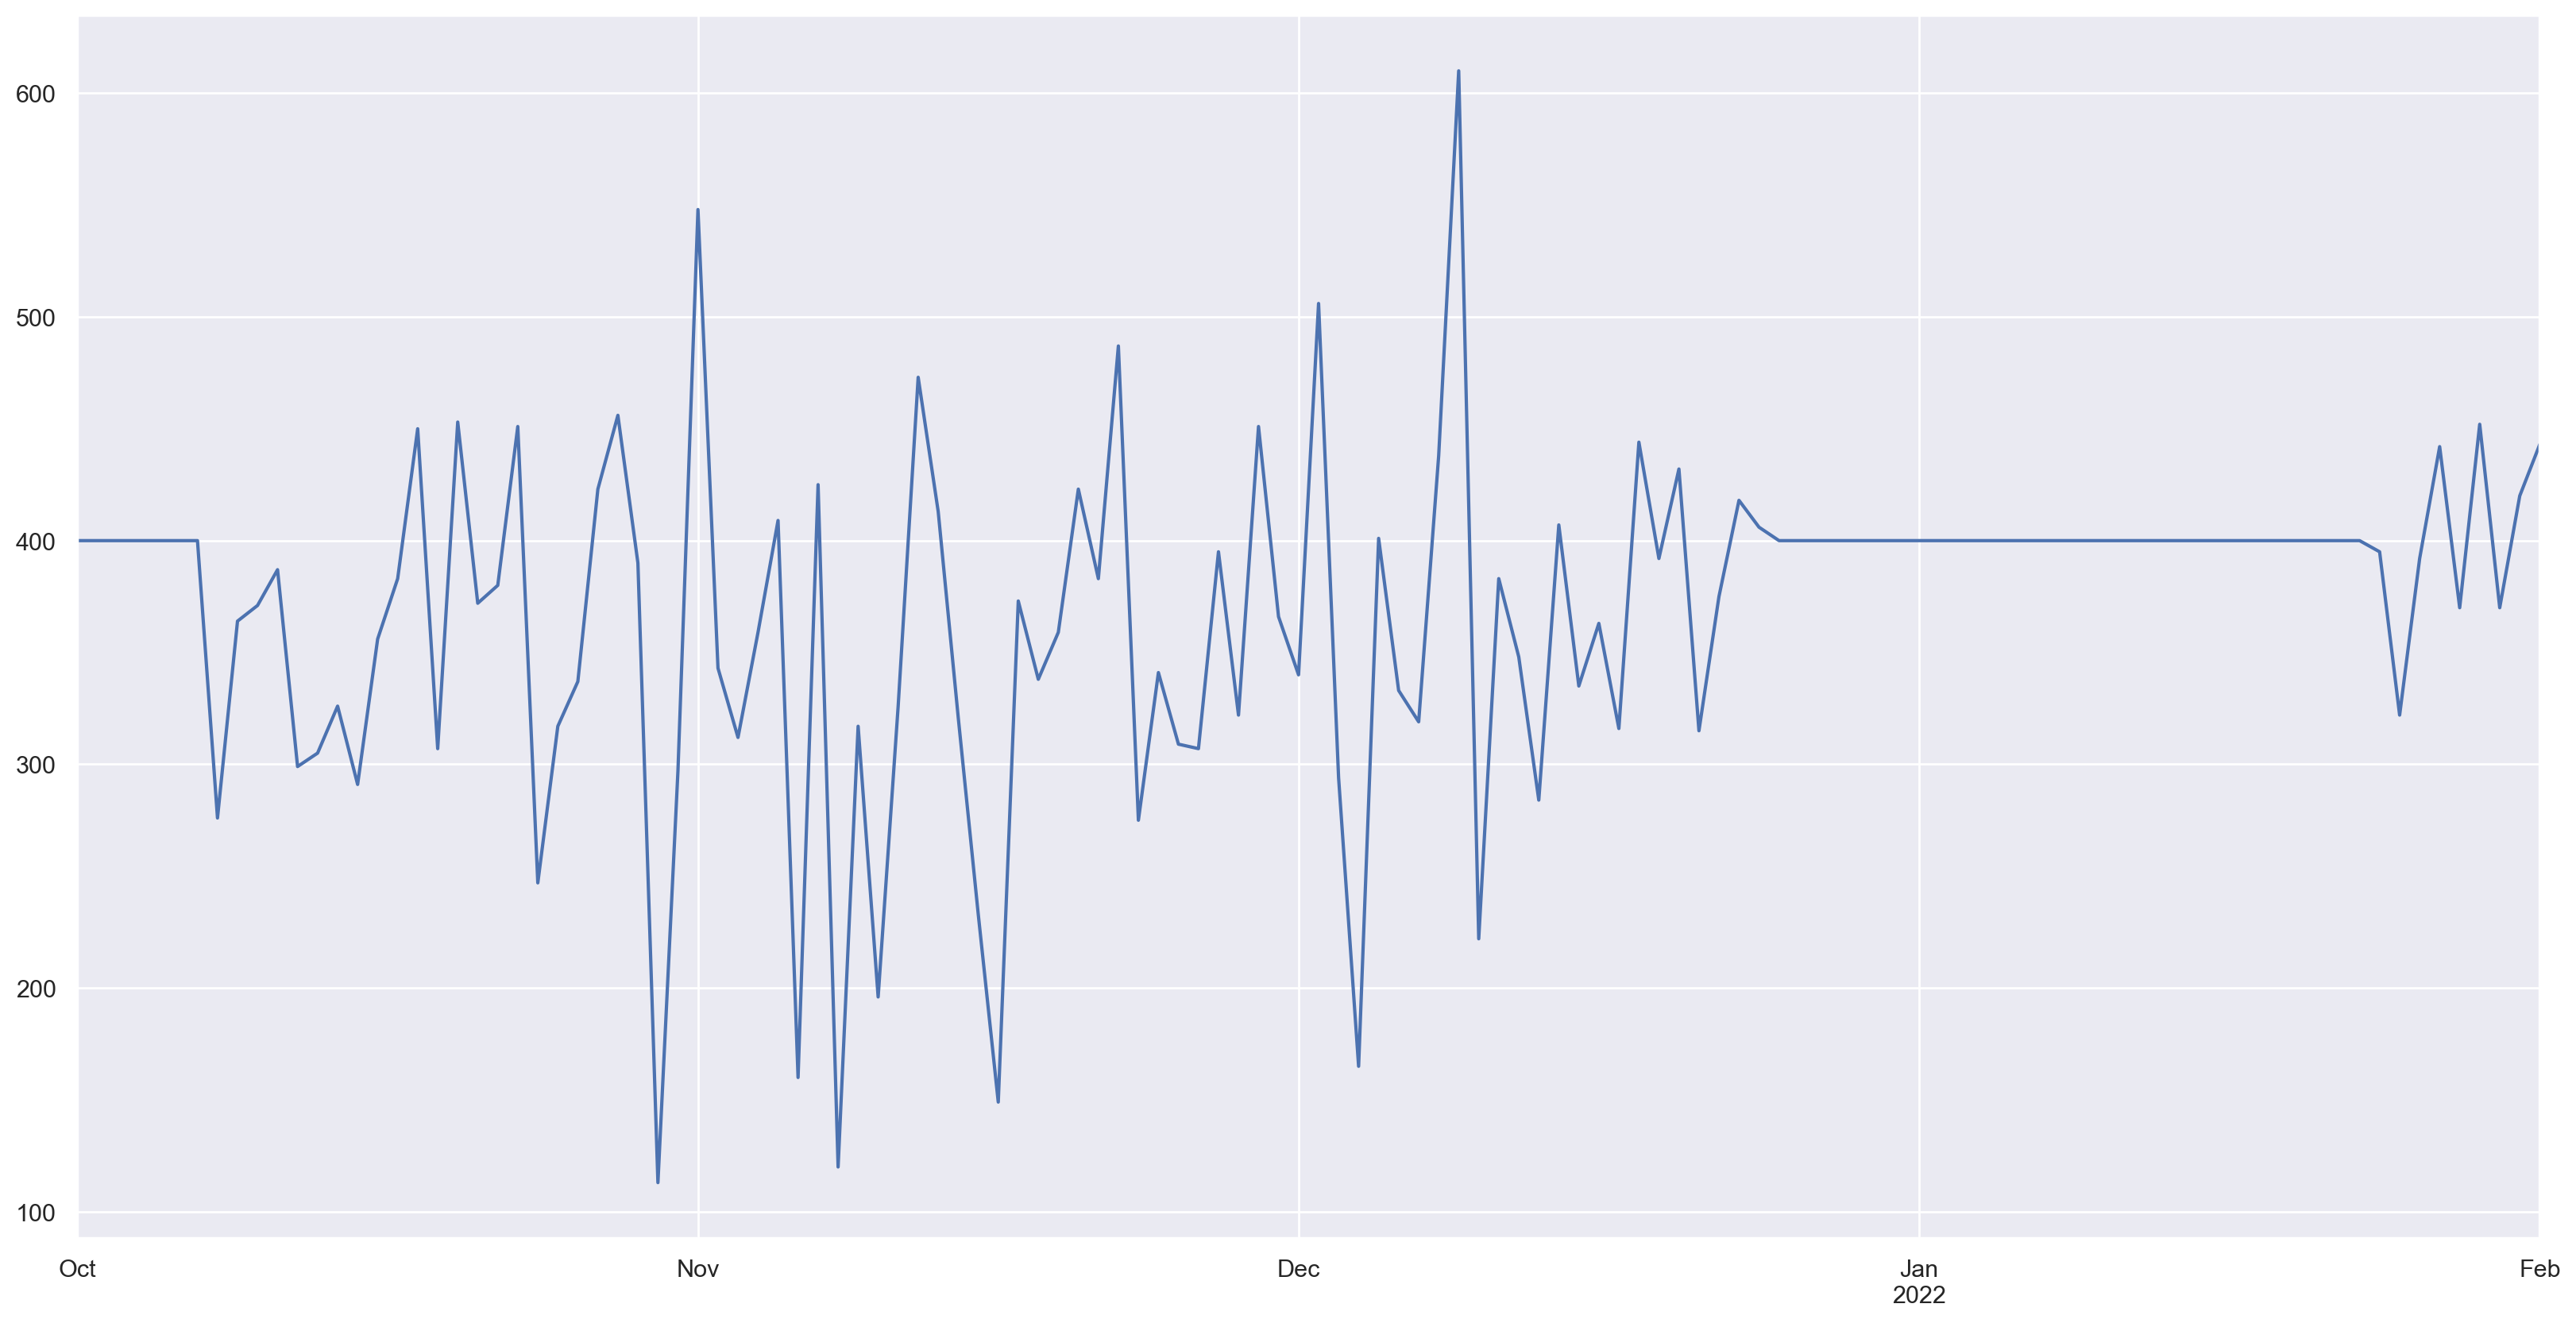

<AxesSubplot:ylabel='minutesAsleep'>

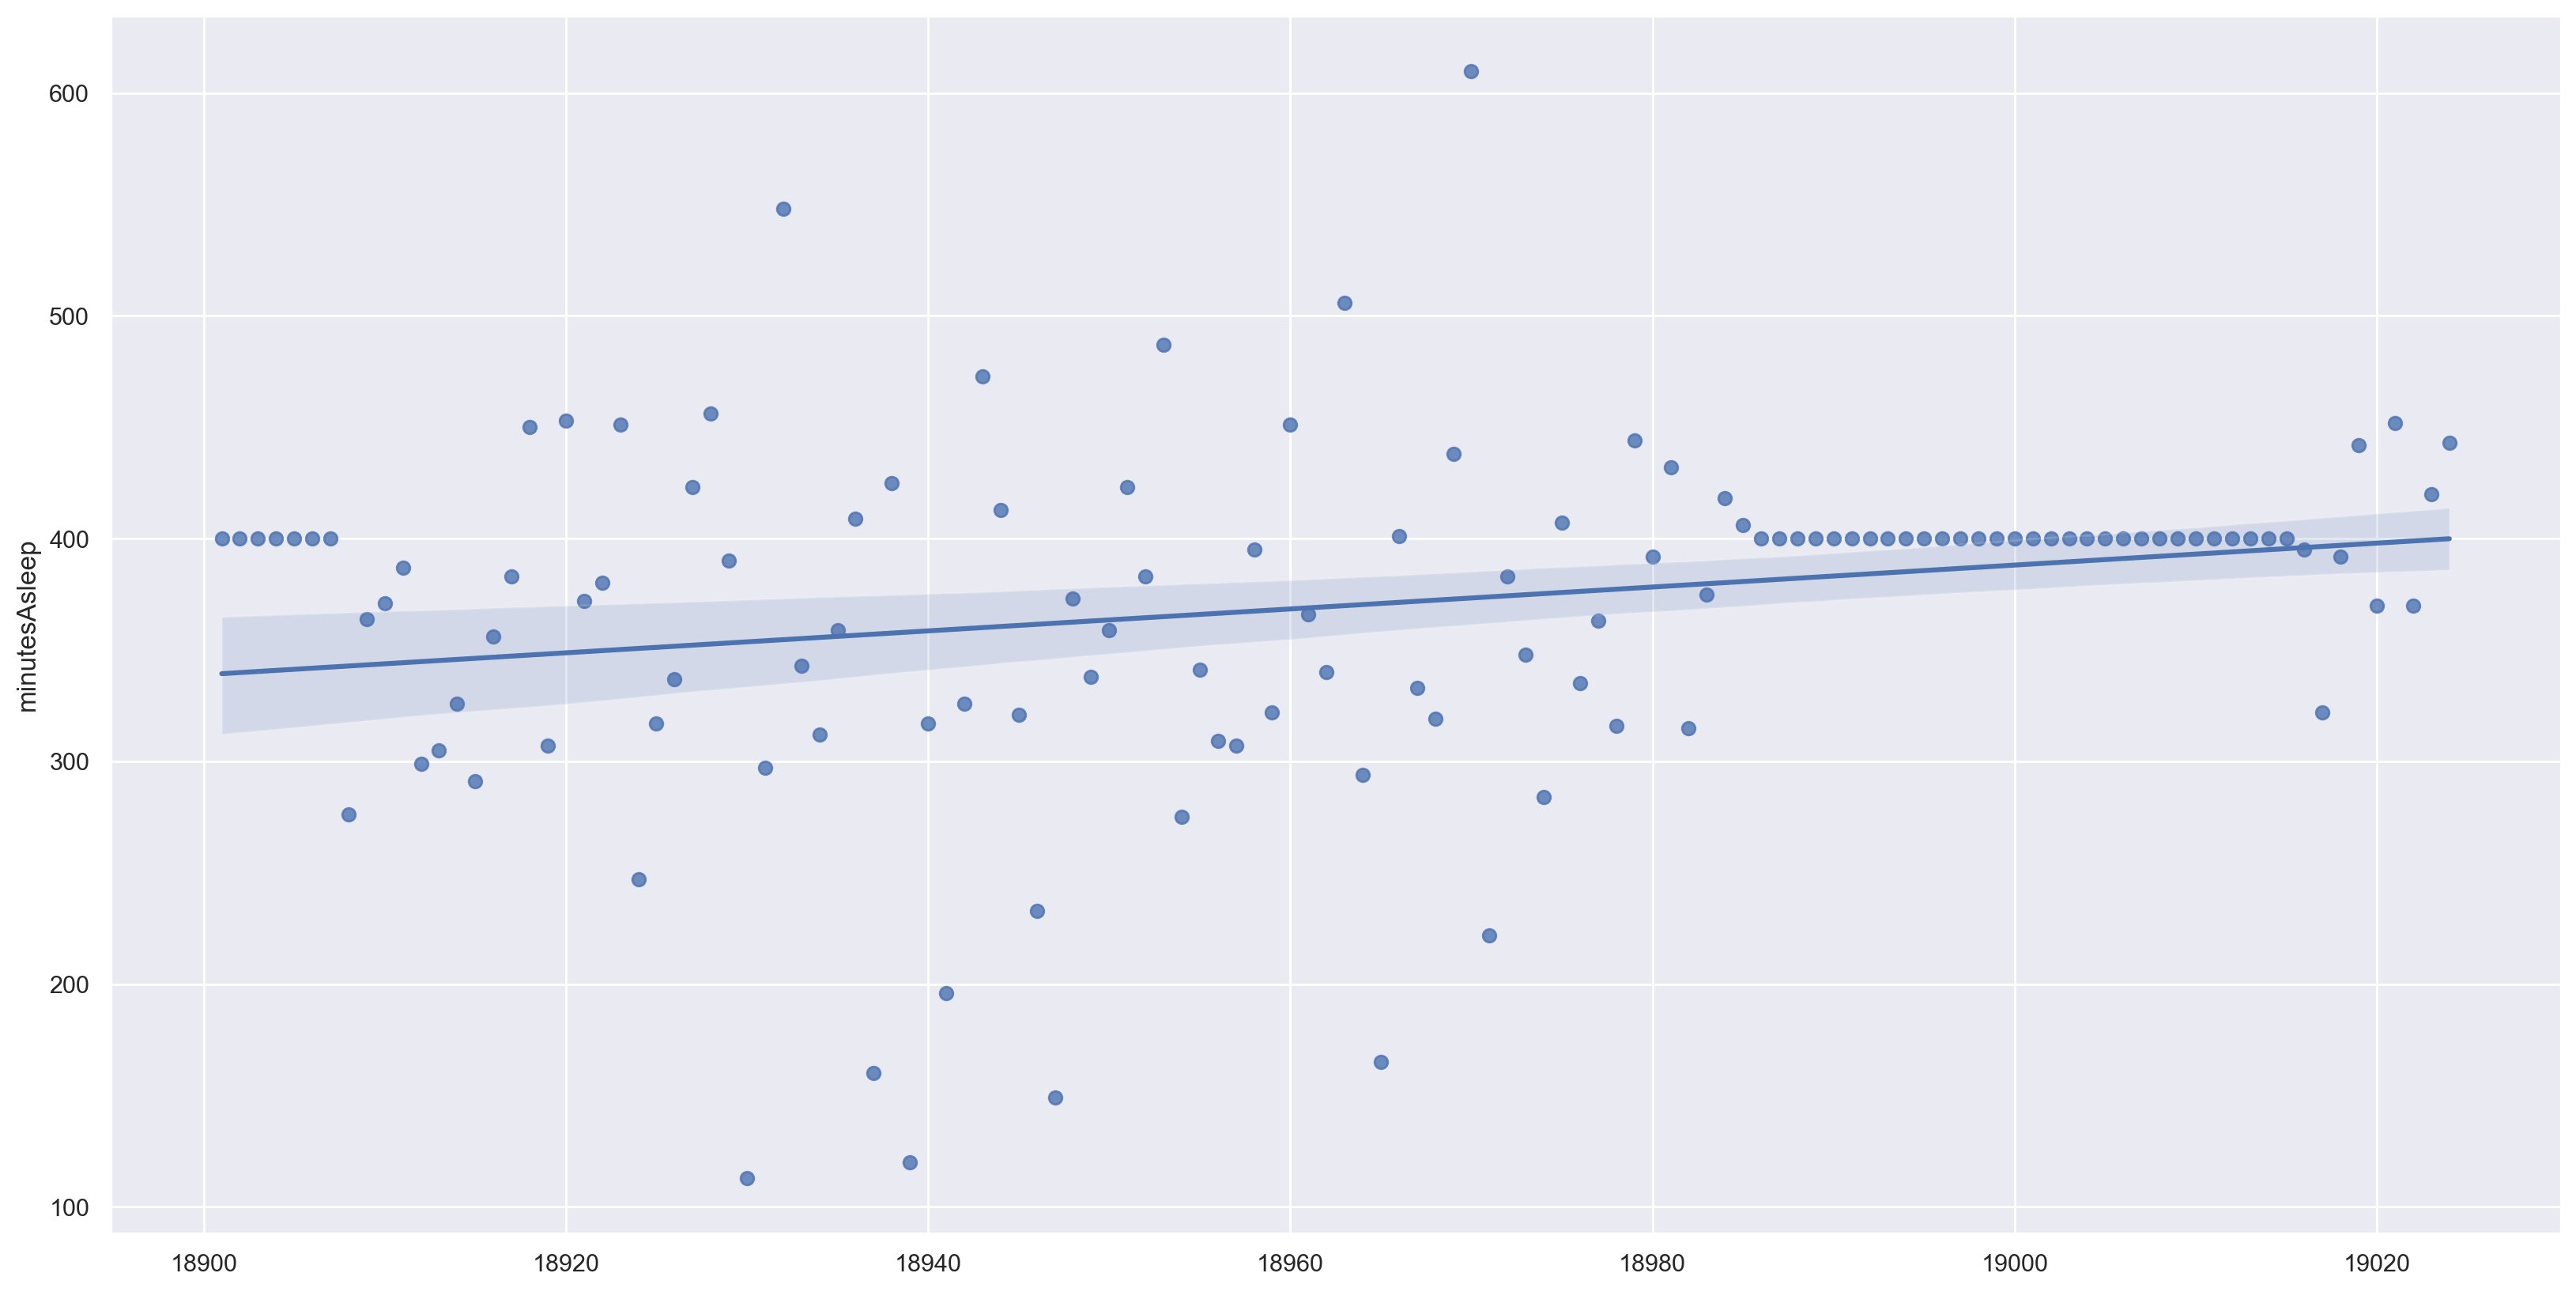

In [202]:
"""
    Slice dataset to a 3-month period before birth (also excluding 2021-07 - 2021-09 since there is no data)
    The logic here is to look closer to the period prior to the birth rather across the whole timeline to
    identify whether we can see evidence suggesting the state of sleep then given that we have a lack of
    data in the most relevant time.
    
    In the top chart, we can see a number of findings:
    - there are three days where I slept in total over 500 minutes (more than 8 hours)
    - i've sleept less than 300 minutes (or five hours) more than 10 times during this period
    - the majority of days I slept within the 300-400 minutes mark (5h - 6.6h)
    
    In the bottom chart, the findings suggest:
    - it is clear to see the regression shows an upwards trend, depicting that during this period 
    the number of minutes I slept on average increases
    - during this time the confidence interval band is more spread apart, illustrating a higher level of
    variance in my sleep during this period. On occasion, there were higher than average sleep minutes and
    on other days, lower than average minutes of sleep.
"""

# Slice of data from the 10-2021 to 02-2022
monthly_average_short = df.loc['2021-10-01':'2022-02-01'].resample('D').mean()

# Plot and customize first subplot
monthly_average_short['minutesAsleep'].plot(figsize=(20,10))

# Show plot
plt.show()

#define figure size
sns.set(rc={"figure.figsize":(20, 10)}) #width=20, height=10

# plot chart (wiht matplotlib conversion of timestamp to readible numeric values - caused error without conversion)
sns.regplot(data=monthly_average_short, x=dates.date2num(monthly_average_short.index), y="minutesAsleep")
# sns.despine()

## 7 Sleep Quality Score - Deep Dive

With this dataset, depicting the Sleep Quality Score, I would like to further analyze the quality of sleep during the same period of time to check what can be deducted from this feature or component of sleep and the relationship between the score and time spent asleep. 

In [280]:
# Define files directory
dir = "Sleep/"

In [281]:
"""
Sleep Analytics and EDA
sleep_score.csv
"""

# Import sleep_score csv
sleep_score = pd.read_csv("%ssleep_score.csv" % dir)

### 7a Sleep Quality Score - Exploratory Data Analysis

In [209]:
print(sleep_score.head(20))

    sleep_log_entry_id             timestamp  overall_score  \
0          37674732353  2022-07-18T05:35:00Z             67   
1          37668012181  2022-07-17T09:23:00Z             77   
2          37668012180  2022-07-16T07:55:00Z             82   
3          37637587505  2022-07-15T07:28:30Z             64   
4          37625922504  2022-07-14T06:26:00Z             63   
5          37626318323  2022-07-13T08:35:30Z             77   
6          37602027831  2022-07-12T02:53:00Z             55   
7          37590821128  2022-07-11T05:50:30Z             75   
8          37556590620  2022-07-08T07:16:00Z             77   
9          37542020931  2022-07-07T08:22:30Z             66   
10         37536715704  2022-07-06T06:10:30Z             77   
11         37526004501  2022-07-05T06:06:00Z             77   
12         37516051389  2022-07-04T05:56:00Z             76   
13         37516051388  2022-07-03T08:26:00Z             79   
14         37516051387  2022-07-02T06:04:00Z           

In [210]:
pd.DatetimeIndex(sleep_score['timestamp'])

# Convert the timestamp column to datetime type and strip the time
sleep_score['timestamp'] = pd.to_datetime(sleep_score['timestamp']).dt.date

days = pd.date_range(sleep_score.index.min(), sleep_score.index.max(), freq='D')

score = sleep_score

In [211]:
print(score.tail())
print(score.index)

     sleep_log_entry_id   timestamp  overall_score  composition_score  \
393         30445165535  2021-01-12             72                 17   
394         30428588605  2021-01-11             73                 18   
395         30414856423  2021-01-10             61                 20   
396         30402518412  2021-01-09             87                 21   
397         30383692633  2021-01-07             72                 17   

     revitalization_score  duration_score  deep_sleep_in_minutes  \
393                    18              37                     51   
394                    18              37                     85   
395                    16              25                     49   
396                    20              46                     77   
397                    18              37                     58   

     resting_heart_rate  restlessness  
393                  53      0.070520  
394                  52      0.097762  
395                  54      0.0

In [212]:
"""
    Discard data points we do not wish to analyze at this point, more specifically columns:
    
    sleep_log_entry_id
    composition_score
    revitalizaiton_score
    duration_score
    resting_heart_rate
    
"""
score = score[['timestamp', 'overall_score', 'deep_sleep_in_minutes', 'restlessness']]

In [213]:
score.tail(20)

,timestamp,overall_score,deep_sleep_in_minutes,restlessness
378,2021-01-27,72,45,0.076923
379,2021-01-26,80,78,0.088727
380,2021-01-25,77,50,0.108380
381,2021-01-24,69,72,0.093787
382,2021-01-23,79,94,0.078453
383,2021-01-22,63,46,0.082474
384,2021-01-21,73,78,0.097973
385,2021-01-20,71,61,0.097669
386,2021-01-19,77,58,0.077908
387,2021-01-18,74,50,0.094545


In [214]:
# Define which aggregation functions should be used for each column
aggregation = {'restlessness':'mean', 'deep_sleep_in_minutes':'sum', 'overall_score':'mean'}

In [215]:
"""
    We identified in addition that there are dates within the dataset that do not exist entirely, this is said to 
    be as I wasn't wearing the device on that date properly since it was charged and then forgotten or similar.
    In order to overcome this issue, I am forced to create a complete date range (all_days) and plug
    this date as the index of the dataframe to Group By the data and later fill in those records that have
    no values (further down the code)
"""

pd.DatetimeIndex(score['timestamp'])
score['date'] = score['timestamp']

score.set_index('date', inplace=True)

# Get all days between min/max availale in dataset (as there are missing dates)
days = pd.date_range(score['timestamp'].min(), score['timestamp'].max(), freq='D')

# Transform the range into a Pandas Series
days = pd.to_datetime(days, errors='coerce')
days = days.to_series()

# Set Index as value of 'date' column 
score['date'] = pd.Series(days)
score.set_index('date', inplace=True)

# Groupby date (yyyy-mm-dd) as there are might be multiple records for given days
score = score.groupby('date').agg(aggregation)

/var/folders/hn/2p2dnxld60q7q3j001y4vm9c0000gn/T/ipykernel_3644/2975367411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score['date'] = score['timestamp']
/var/folders/hn/2p2dnxld60q7q3j001y4vm9c0000gn/T/ipykernel_3644/2975367411.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score['date'] = pd.Series(days)


In [216]:
"""
    Add missing dates into index
    Find min and max dates and create Daily Range Frequency
    Reindex dataset with entire date range to include missing Dates
"""

# days = pd.date_range(score['date'].index.min(), score['date'].index.max(), freq='D')
# days = pd.to_datetime(days, errors='coerce')

# score.index = pd.DatetimeIndex(score['date'].index)
score = score.reindex(days)

In [217]:
score.tail(20)

,restlessness,deep_sleep_in_minutes,overall_score
2022-06-29,0.179298,42.0,57.0
2022-06-30,0.168484,43.0,65.0
2022-07-01,0.150579,80.0,69.0
2022-07-02,0.091623,45.0,72.0
2022-07-03,0.102804,68.0,79.0
2022-07-04,0.082418,70.0,76.0
2022-07-05,0.092771,82.0,77.0
2022-07-06,0.086034,57.0,77.0
2022-07-07,0.171171,67.0,66.0
2022-07-08,0.110988,73.0,77.0


In [218]:
""" 
    Fill in records that are missing data (for those days that were not captured by the device
    with average of each column respectively.
   
   overall_score
   deep_sleep_in_minutes
   restlessnesss
"""

# Finding and capturing the average for each column
avg_overall_score = score['overall_score'].mean()
avg_deep_sleep_in_minutes = score['deep_sleep_in_minutes'].mean()
avg_restlessness = score['restlessness'].mean()

# Filling missing values with counted means  
score['overall_score'].fillna(avg_overall_score, inplace=True)
score['deep_sleep_in_minutes'].fillna(avg_deep_sleep_in_minutes, inplace=True)
score['restlessness'].fillna(avg_restlessness, inplace=True)

In [219]:
score.shape # (398,9) - so 397 rows
# sleep_score['timestamp'].min() #'2021-01-07T07:36:00Z'
# sleep_score['timestamp'].max() #'2022-07-18T05:35:00Z'

(558, 3)

### 7b. Exploratory Data Analysis (EDA)

How my average sleep score looks in last 1.5 years (Monthly):


<AxesSubplot:ylabel='overall_score'>

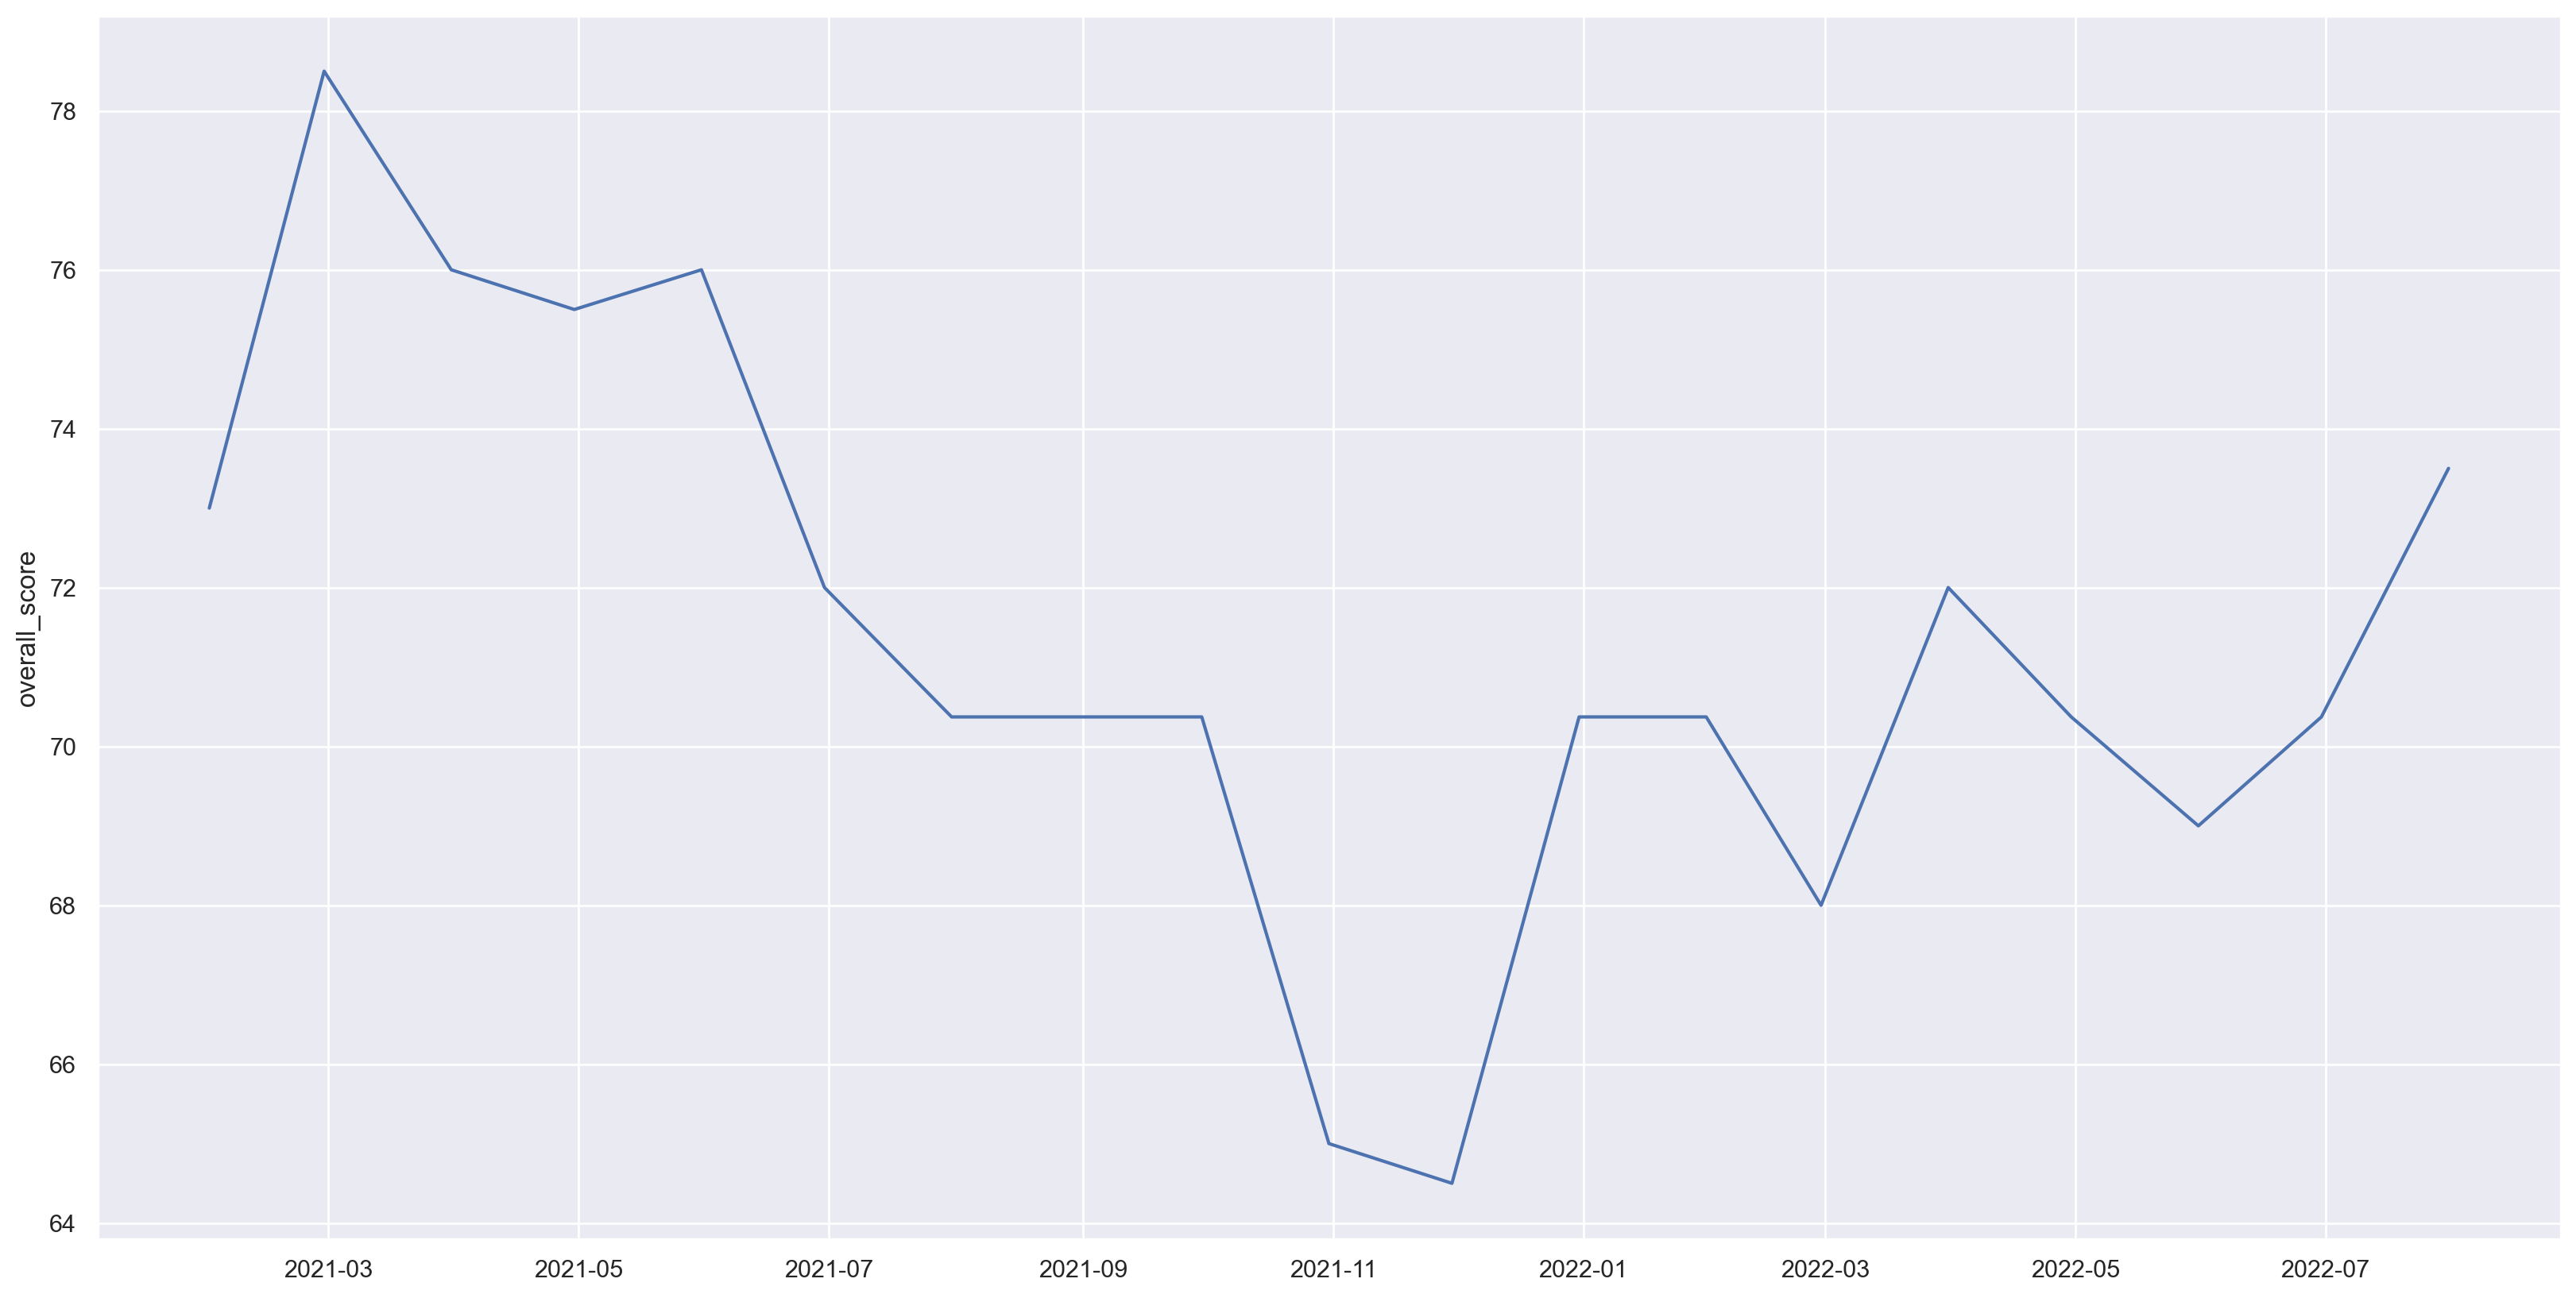

In [220]:
"""
    Sleep Score - Investigation
    
    The chart below is almost identical to the previous chart depicting the minutesAsleep during
    this period. This point requires further investigation of the relationship between
    the overall_score ('sleep score') and minutesAlseep
"""

# Calculate Monthly statistics
print('How does my average sleep score looks in last 1.5 years (Monthly):')

# Sample the data - take the monthly average over the period of time
sleep_score_sample = score.resample('M').mean()

# Plot setting (figure size)
fig, ax = plt.subplots(figsize=(20,10))

# Plot the overall_score monthly overtime
sns.lineplot(data=sleep_score_sample, x=sleep_score_sample.index, y='overall_score', palette="deep", ax=ax)

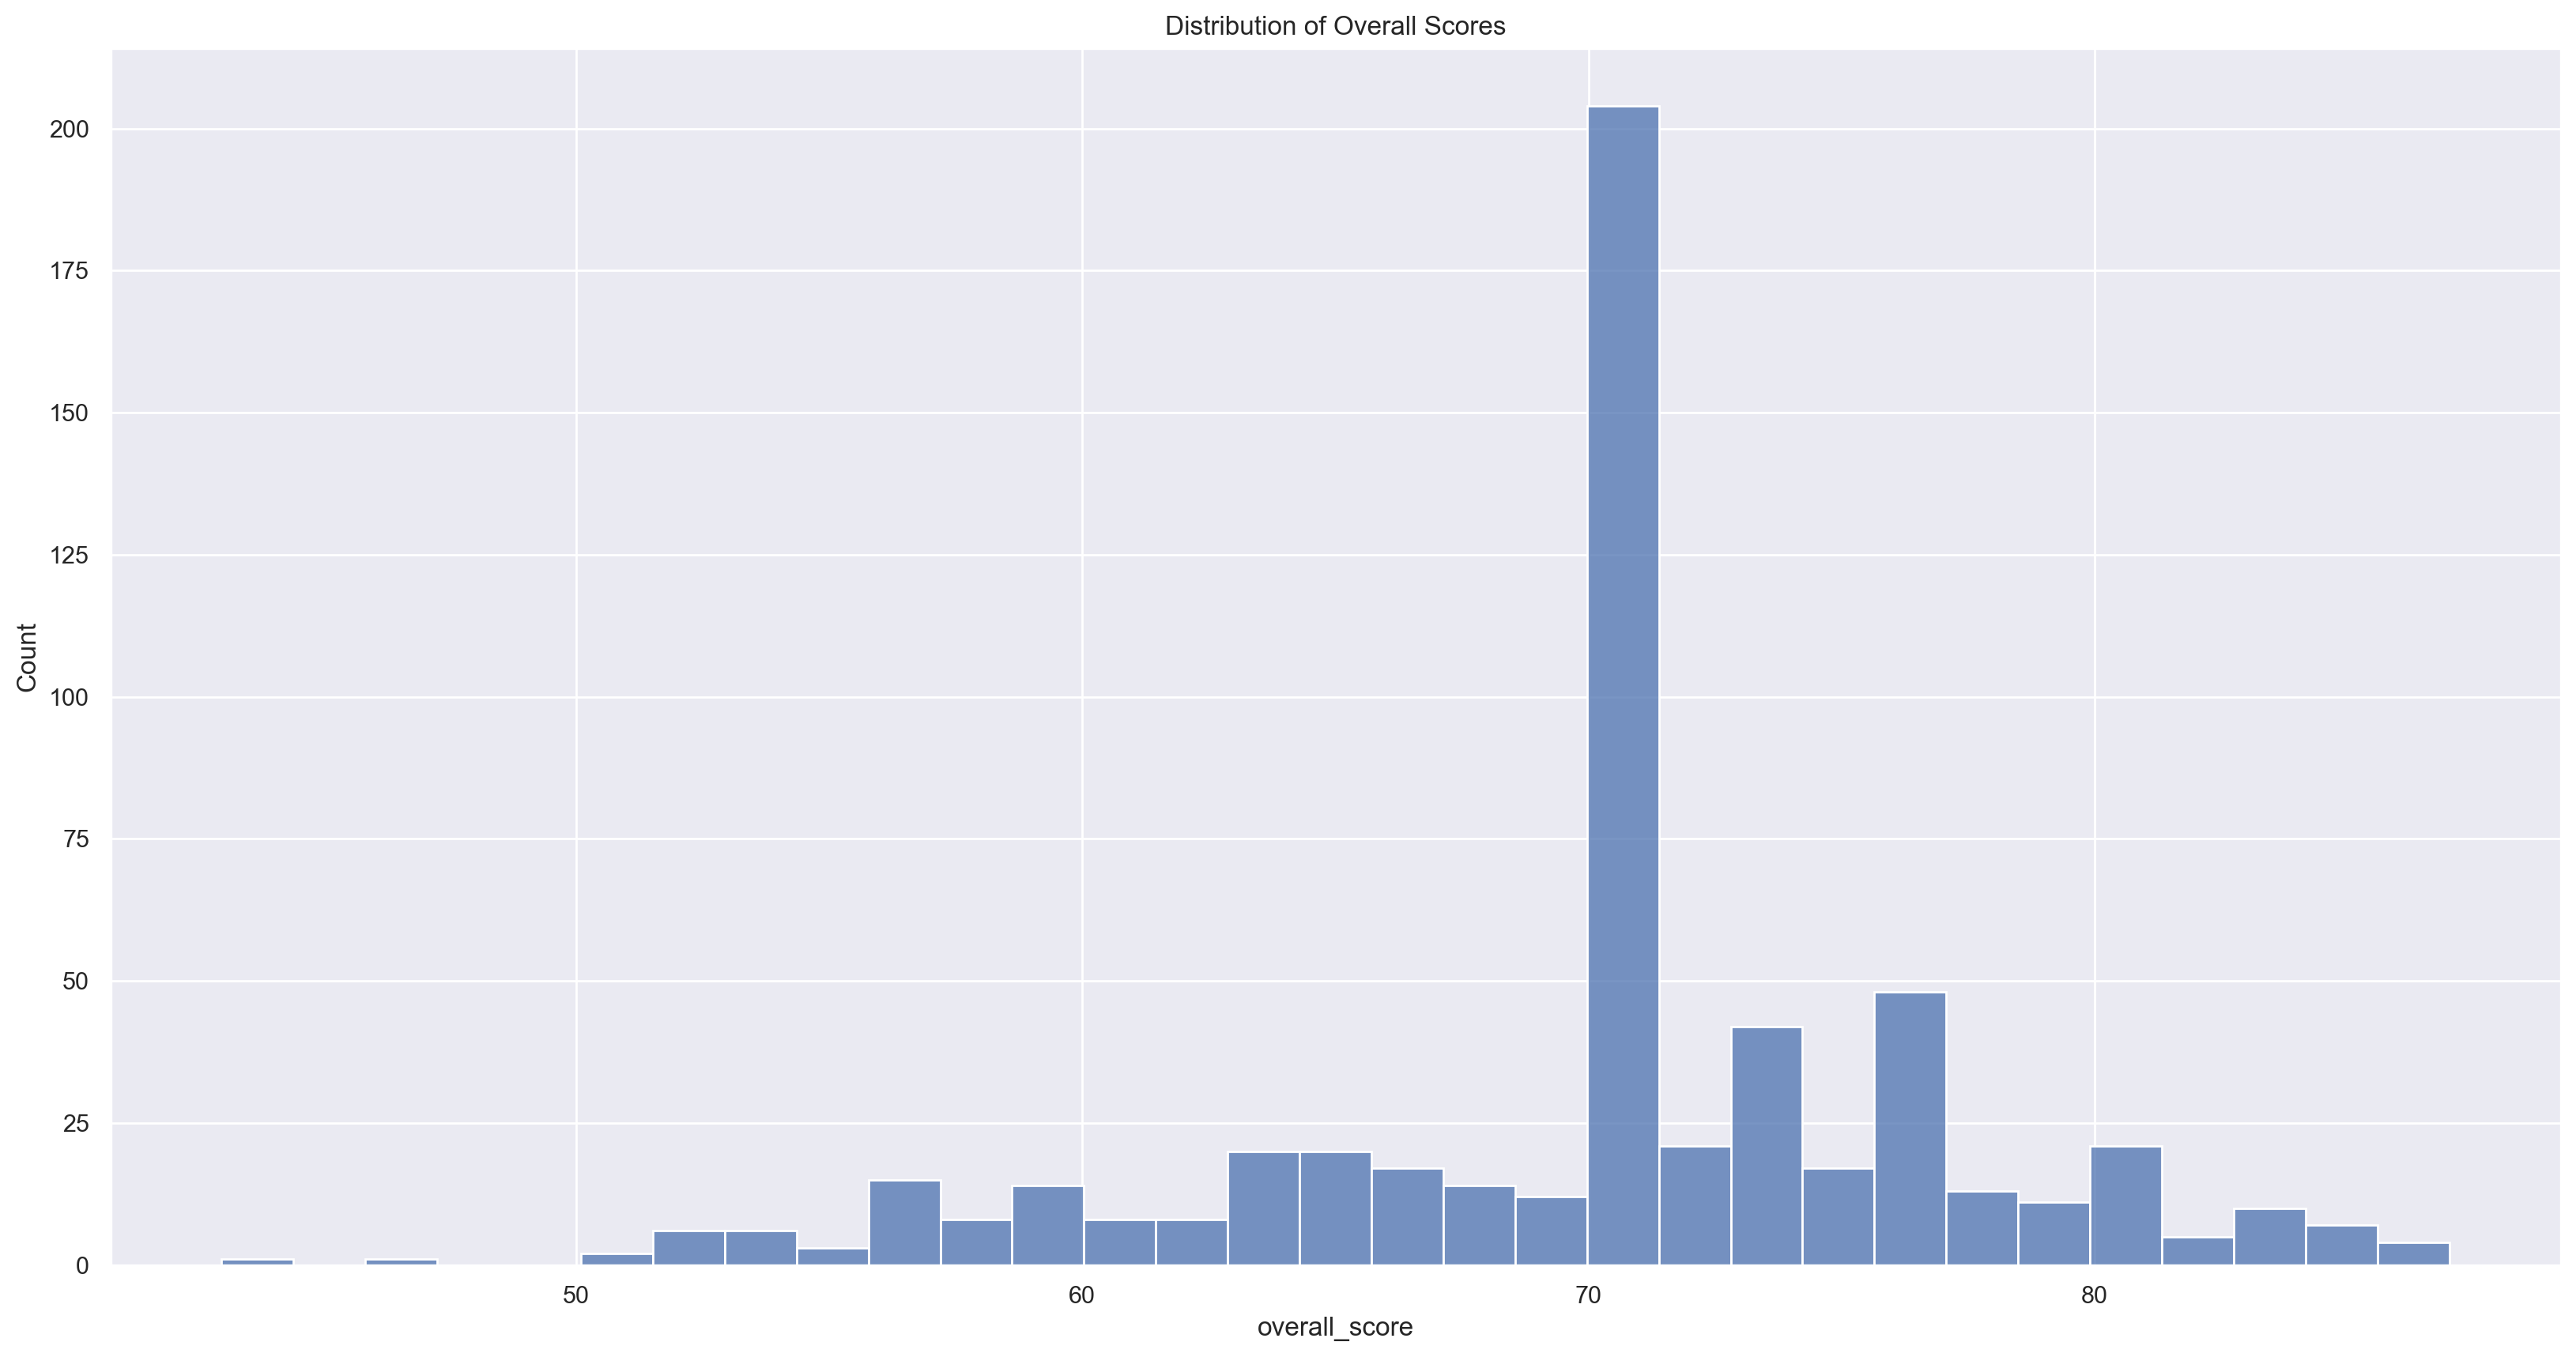

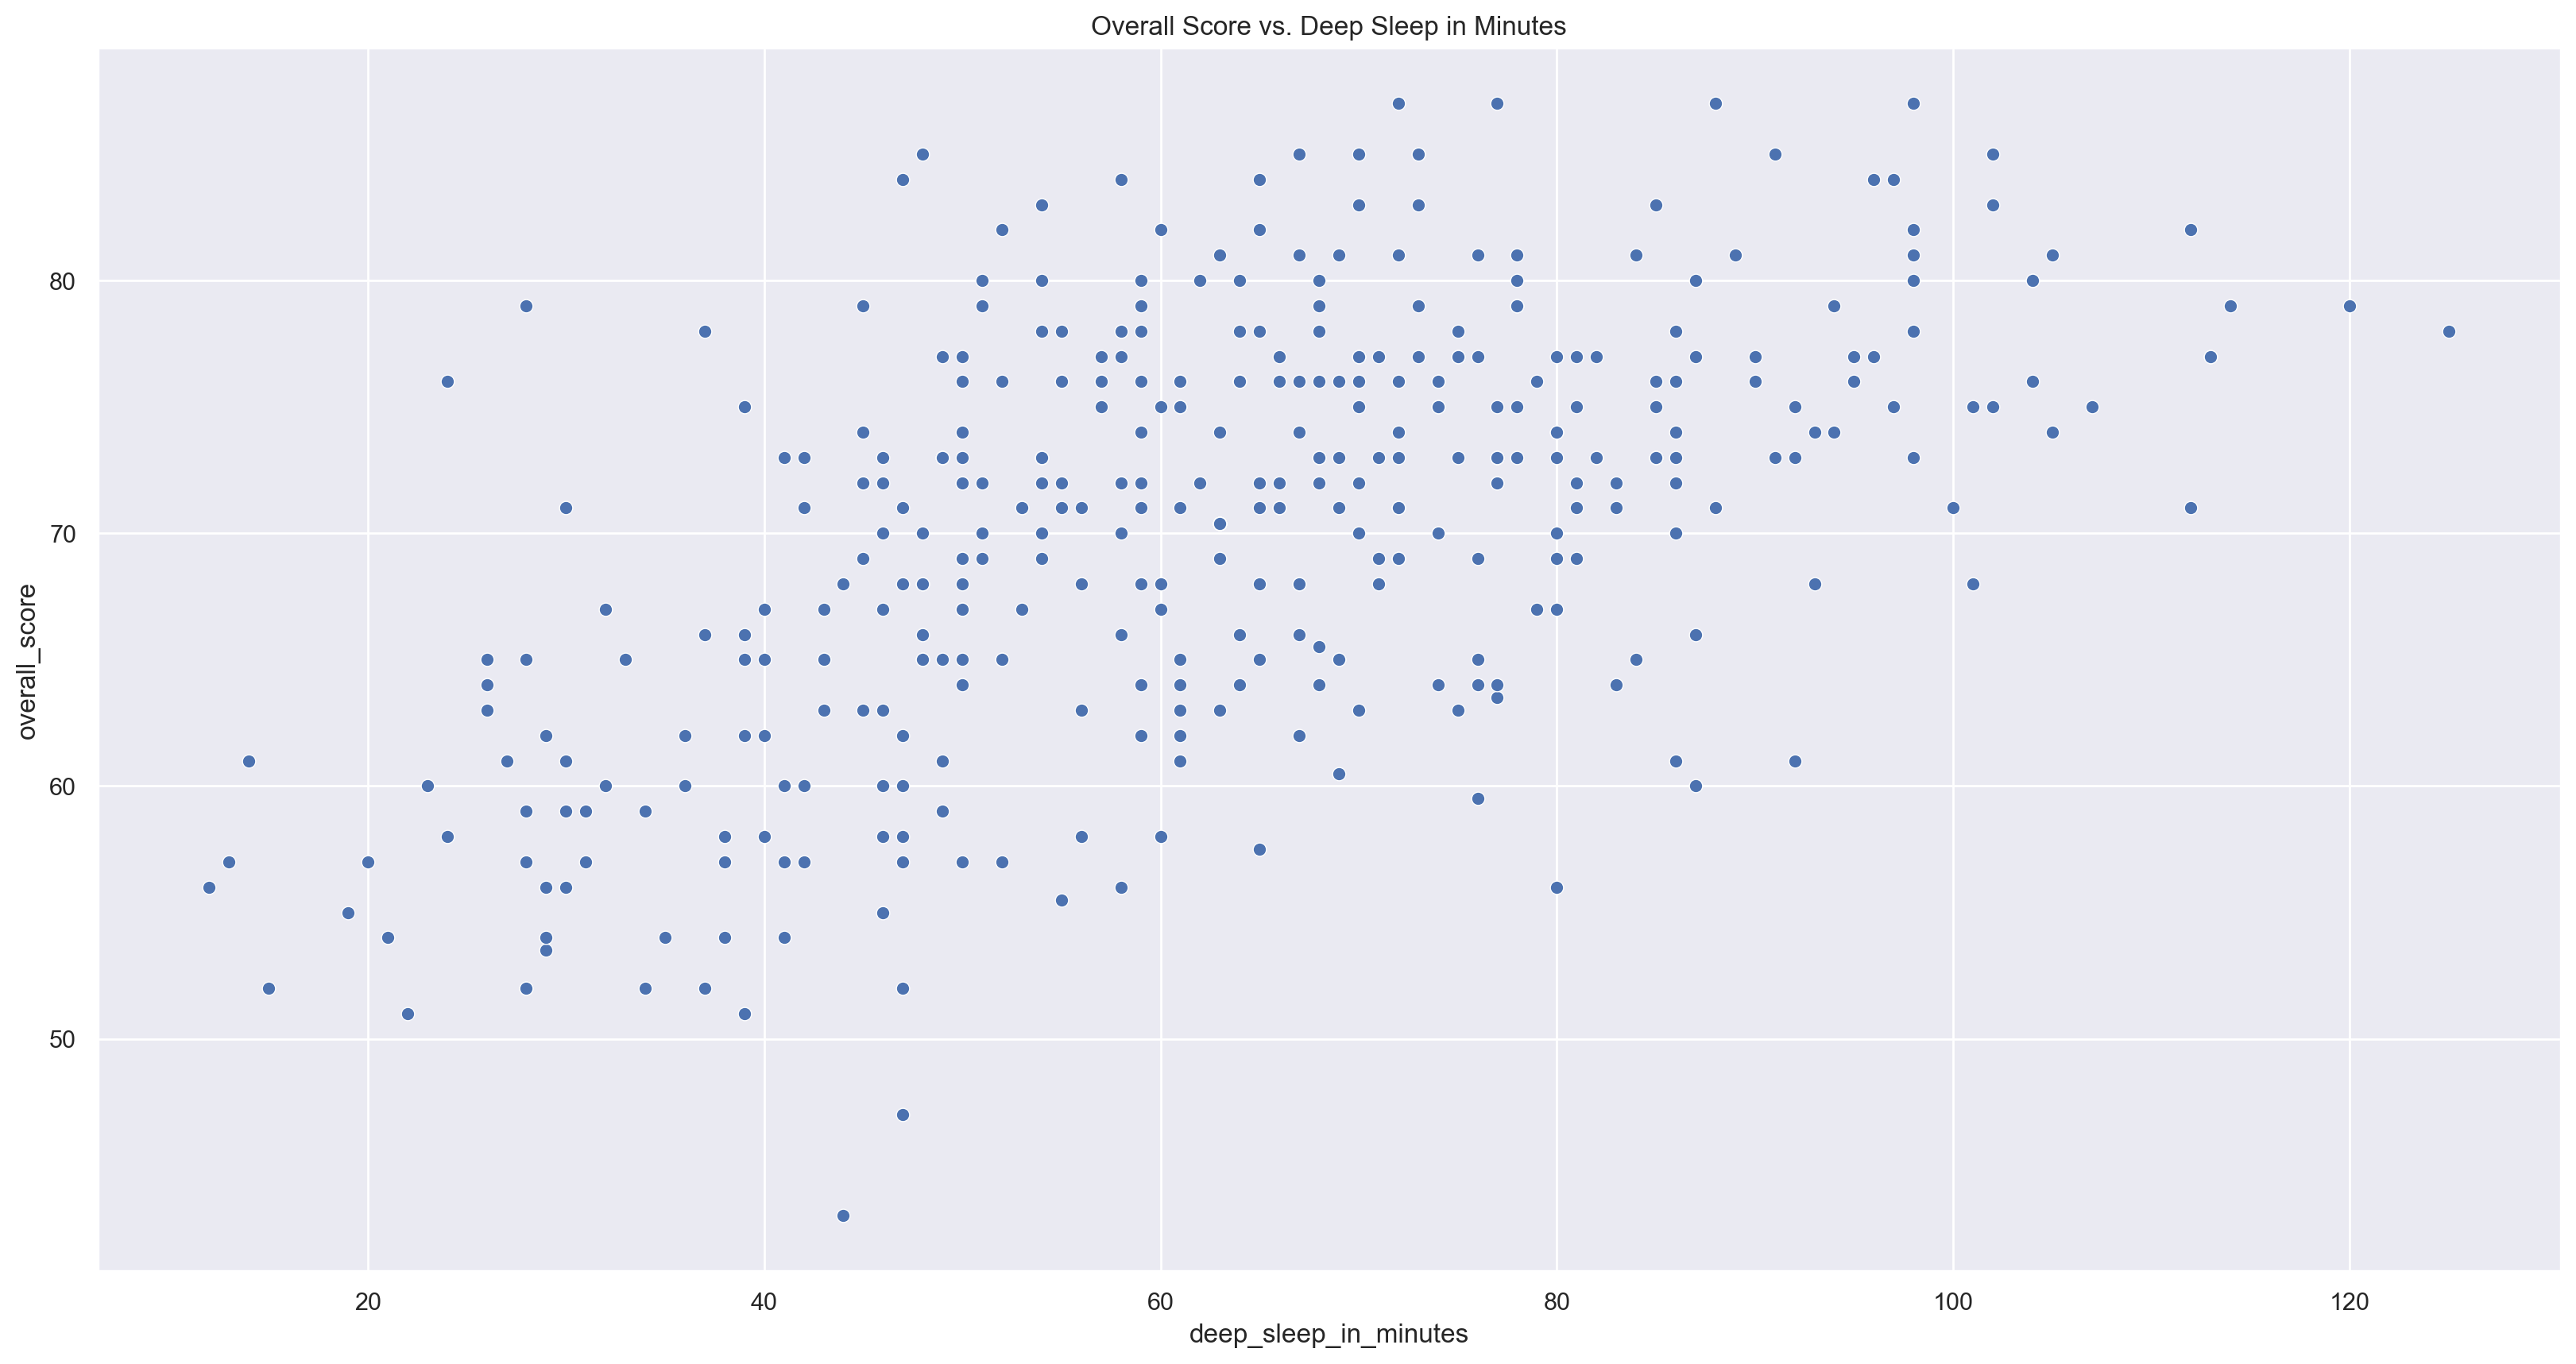

In [222]:
"""
    top chart:
    
    Before we do that, let's look at the distribution of the overall_score in the dataset.
    We can attribute the most frequent overall_score to the 163 instances which we had to back-fill with
    the average overall_score (in the entire period)*.
    Nevertheless, the distribution is skewed to the right, more often than not the scores are over 60 
    
    *note: prehaps in another iteration, we should backfill the data differently, average of X within the month 
    and not in the overall period, to remove this strong skewing
    
    bottom chart:
    
    Here we tested for the relationship between the overall_score (the overall sleep score) and deep_sleep_in_minutes
    which tracks the number of minutes I was in the 'best' level of sleep. This level in the field of sleep by
    definition relates to sleep quality normally.

"""
# Plotting the distribution of overall scores
sns.histplot(score['overall_score'])

# Adding the chart title
plt.title('Distribution of Overall Scores')

# Plotting the distribution
plt.show()

# Plotting the relationship between overall score and deep sleep in minutes
sns.scatterplot(x='deep_sleep_in_minutes', y='overall_score', data=score)

# Adding the chart title
plt.title('Overall Score vs. Deep Sleep in Minutes')

# Plotting the chart
plt.show()

### 7c. Correlation

Here I take a look at the correlation between the variables within the dataset. 
The correlation matrix below strengthens the data depicted in the chart above, that there is only a moderate positive relationship between overall_score and deep_sleep_in_minutes at least with regards to the dataset 
I have in hand.

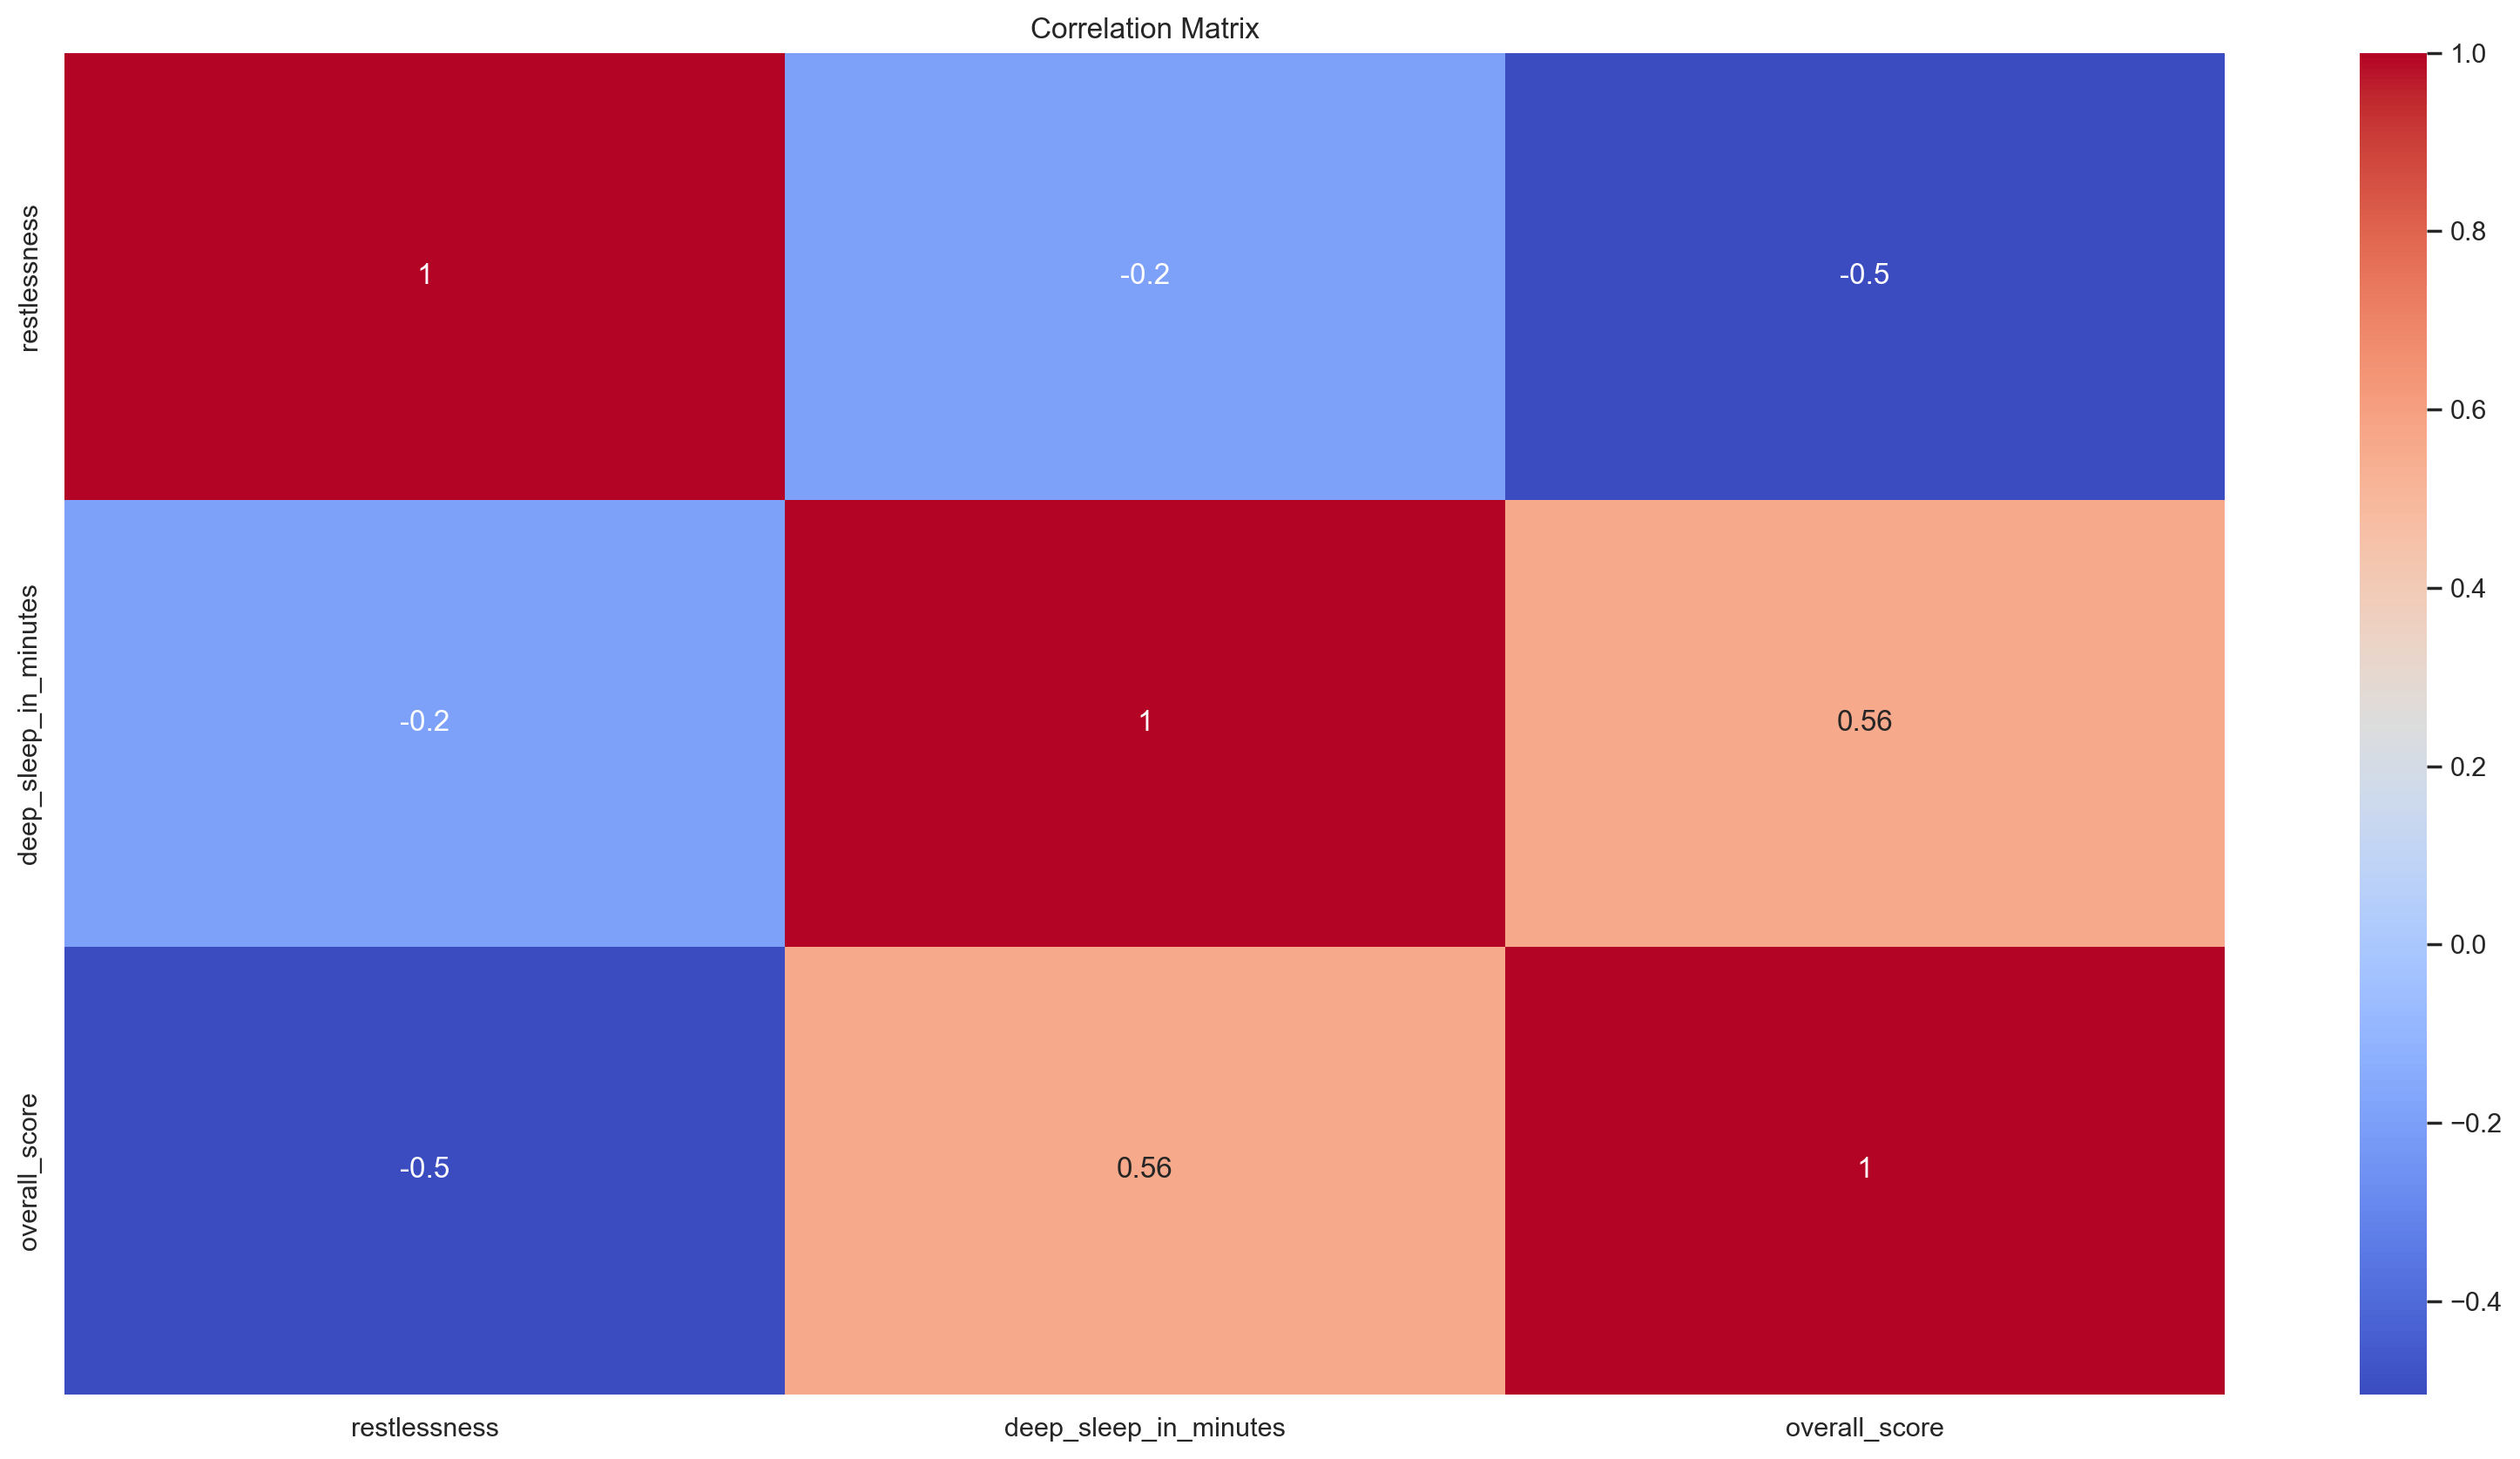

In [223]:
# Correlation Matrix between the features of the combined dataset
correlation_matrix = score.corr()

# Display the Correlation Matrix as a heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set title for matrix
plt.title('Correlation Matrix')

# show matrix
plt.show()

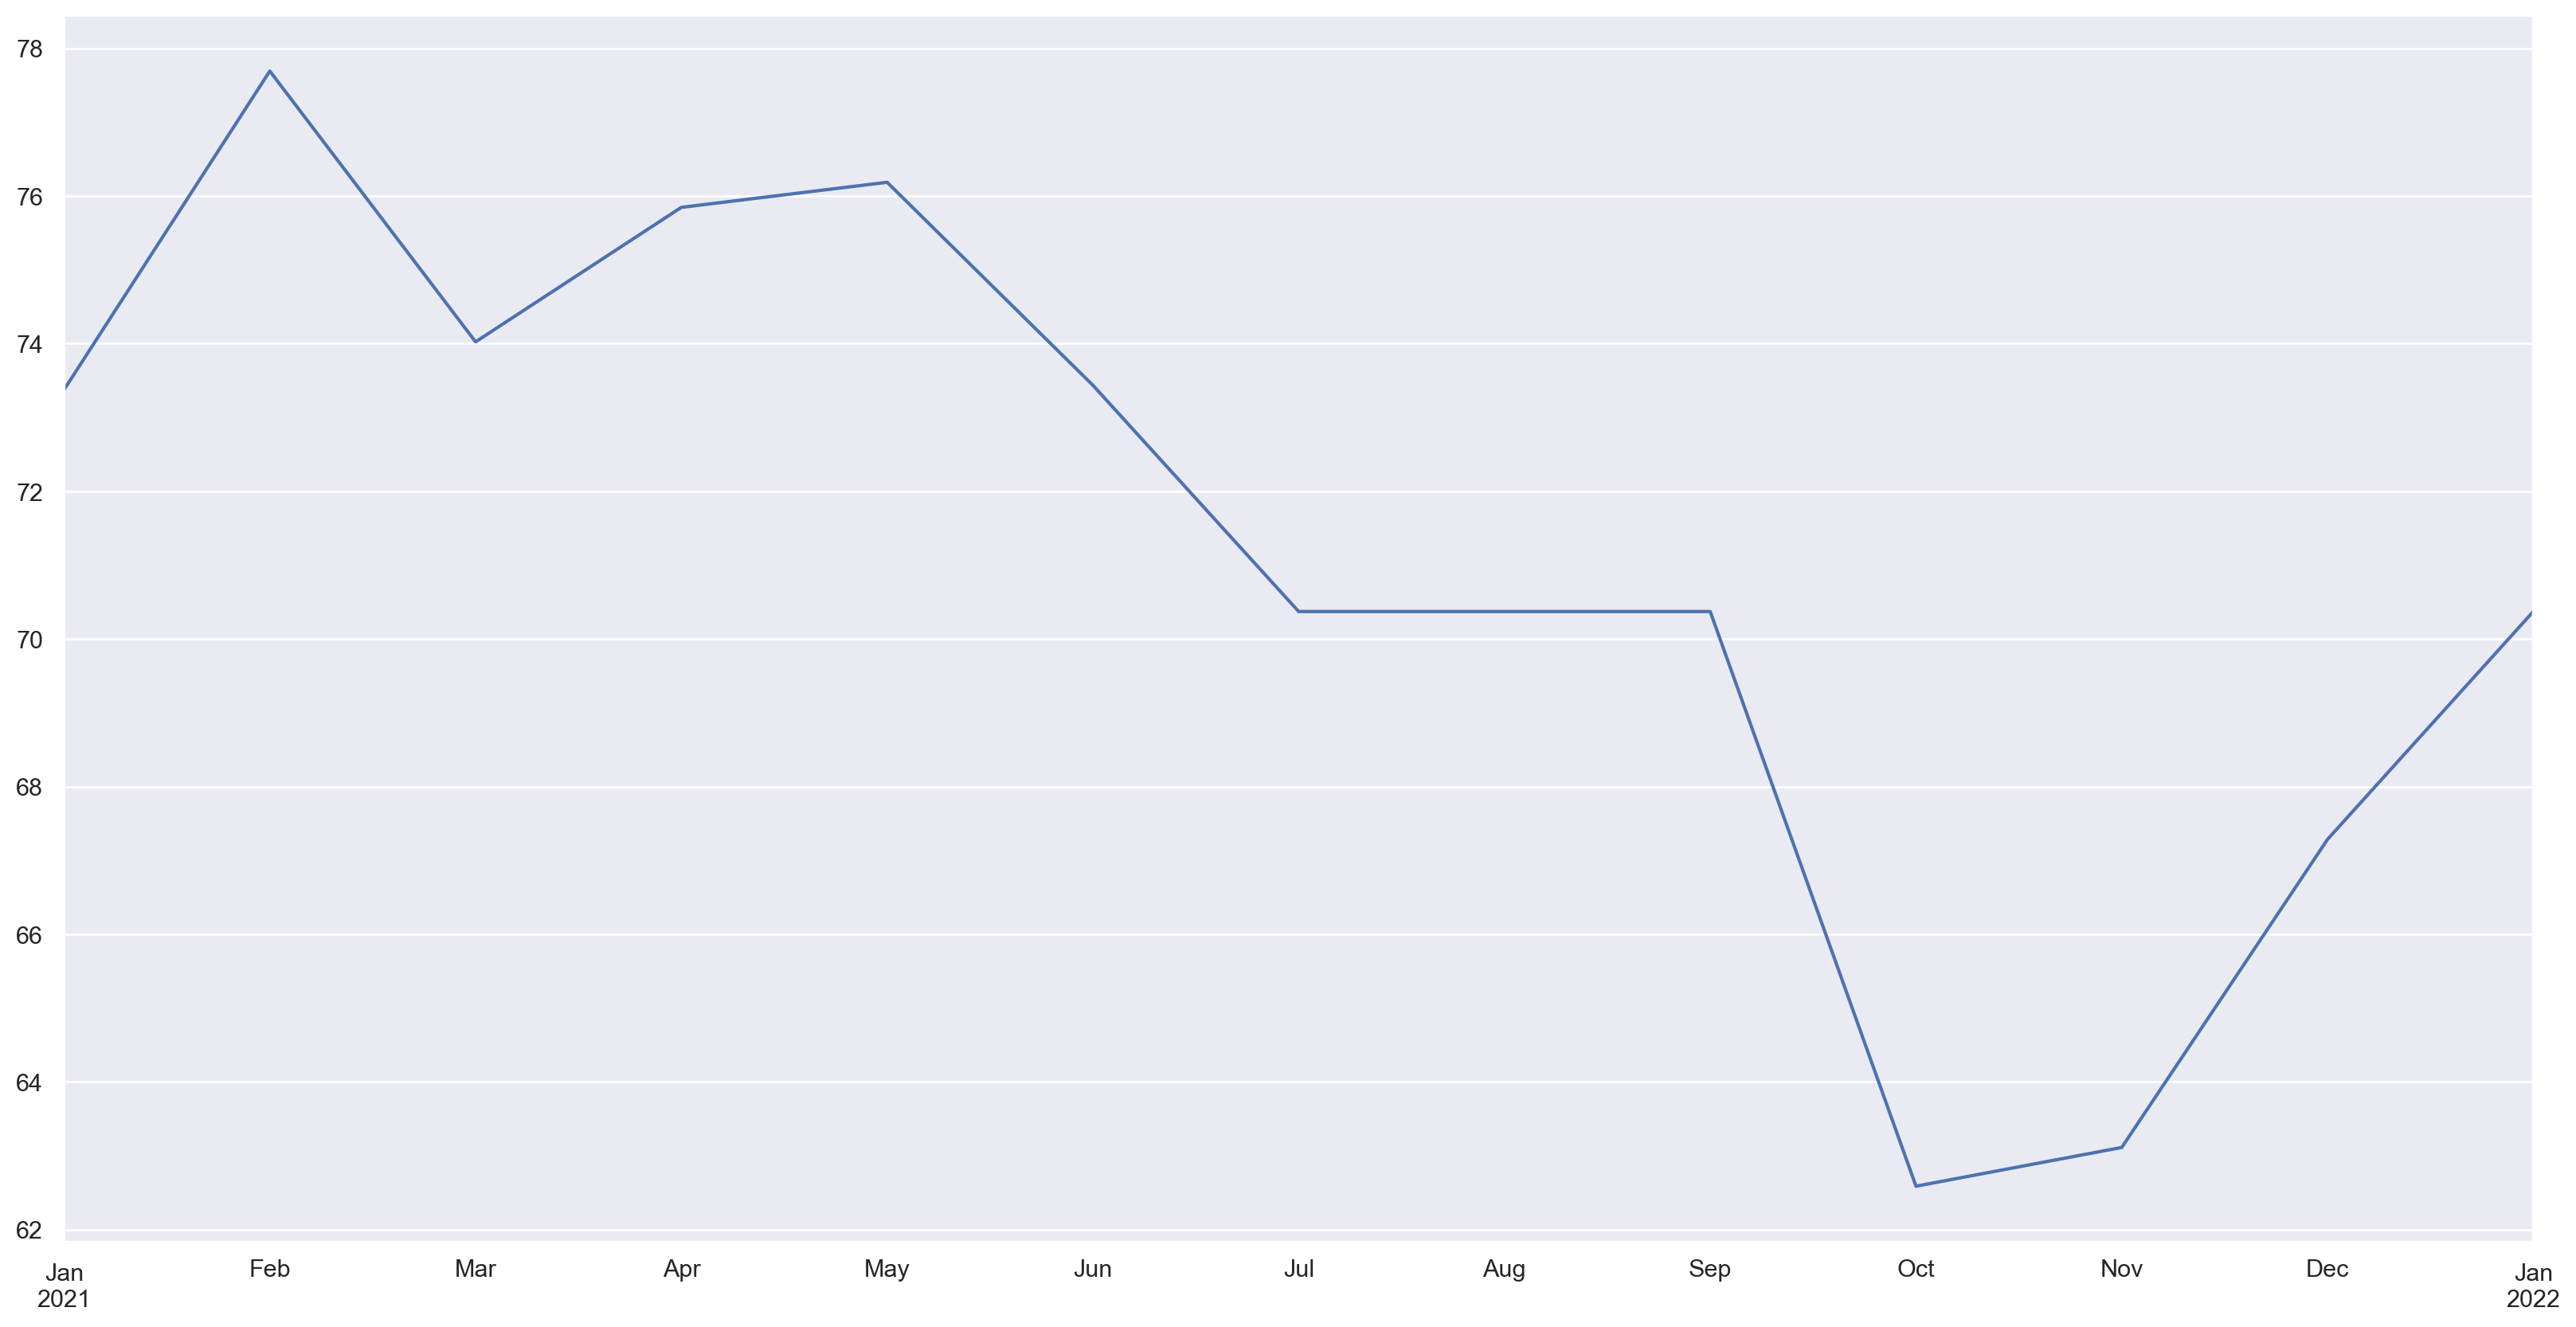

<AxesSubplot:ylabel='overall_score'>

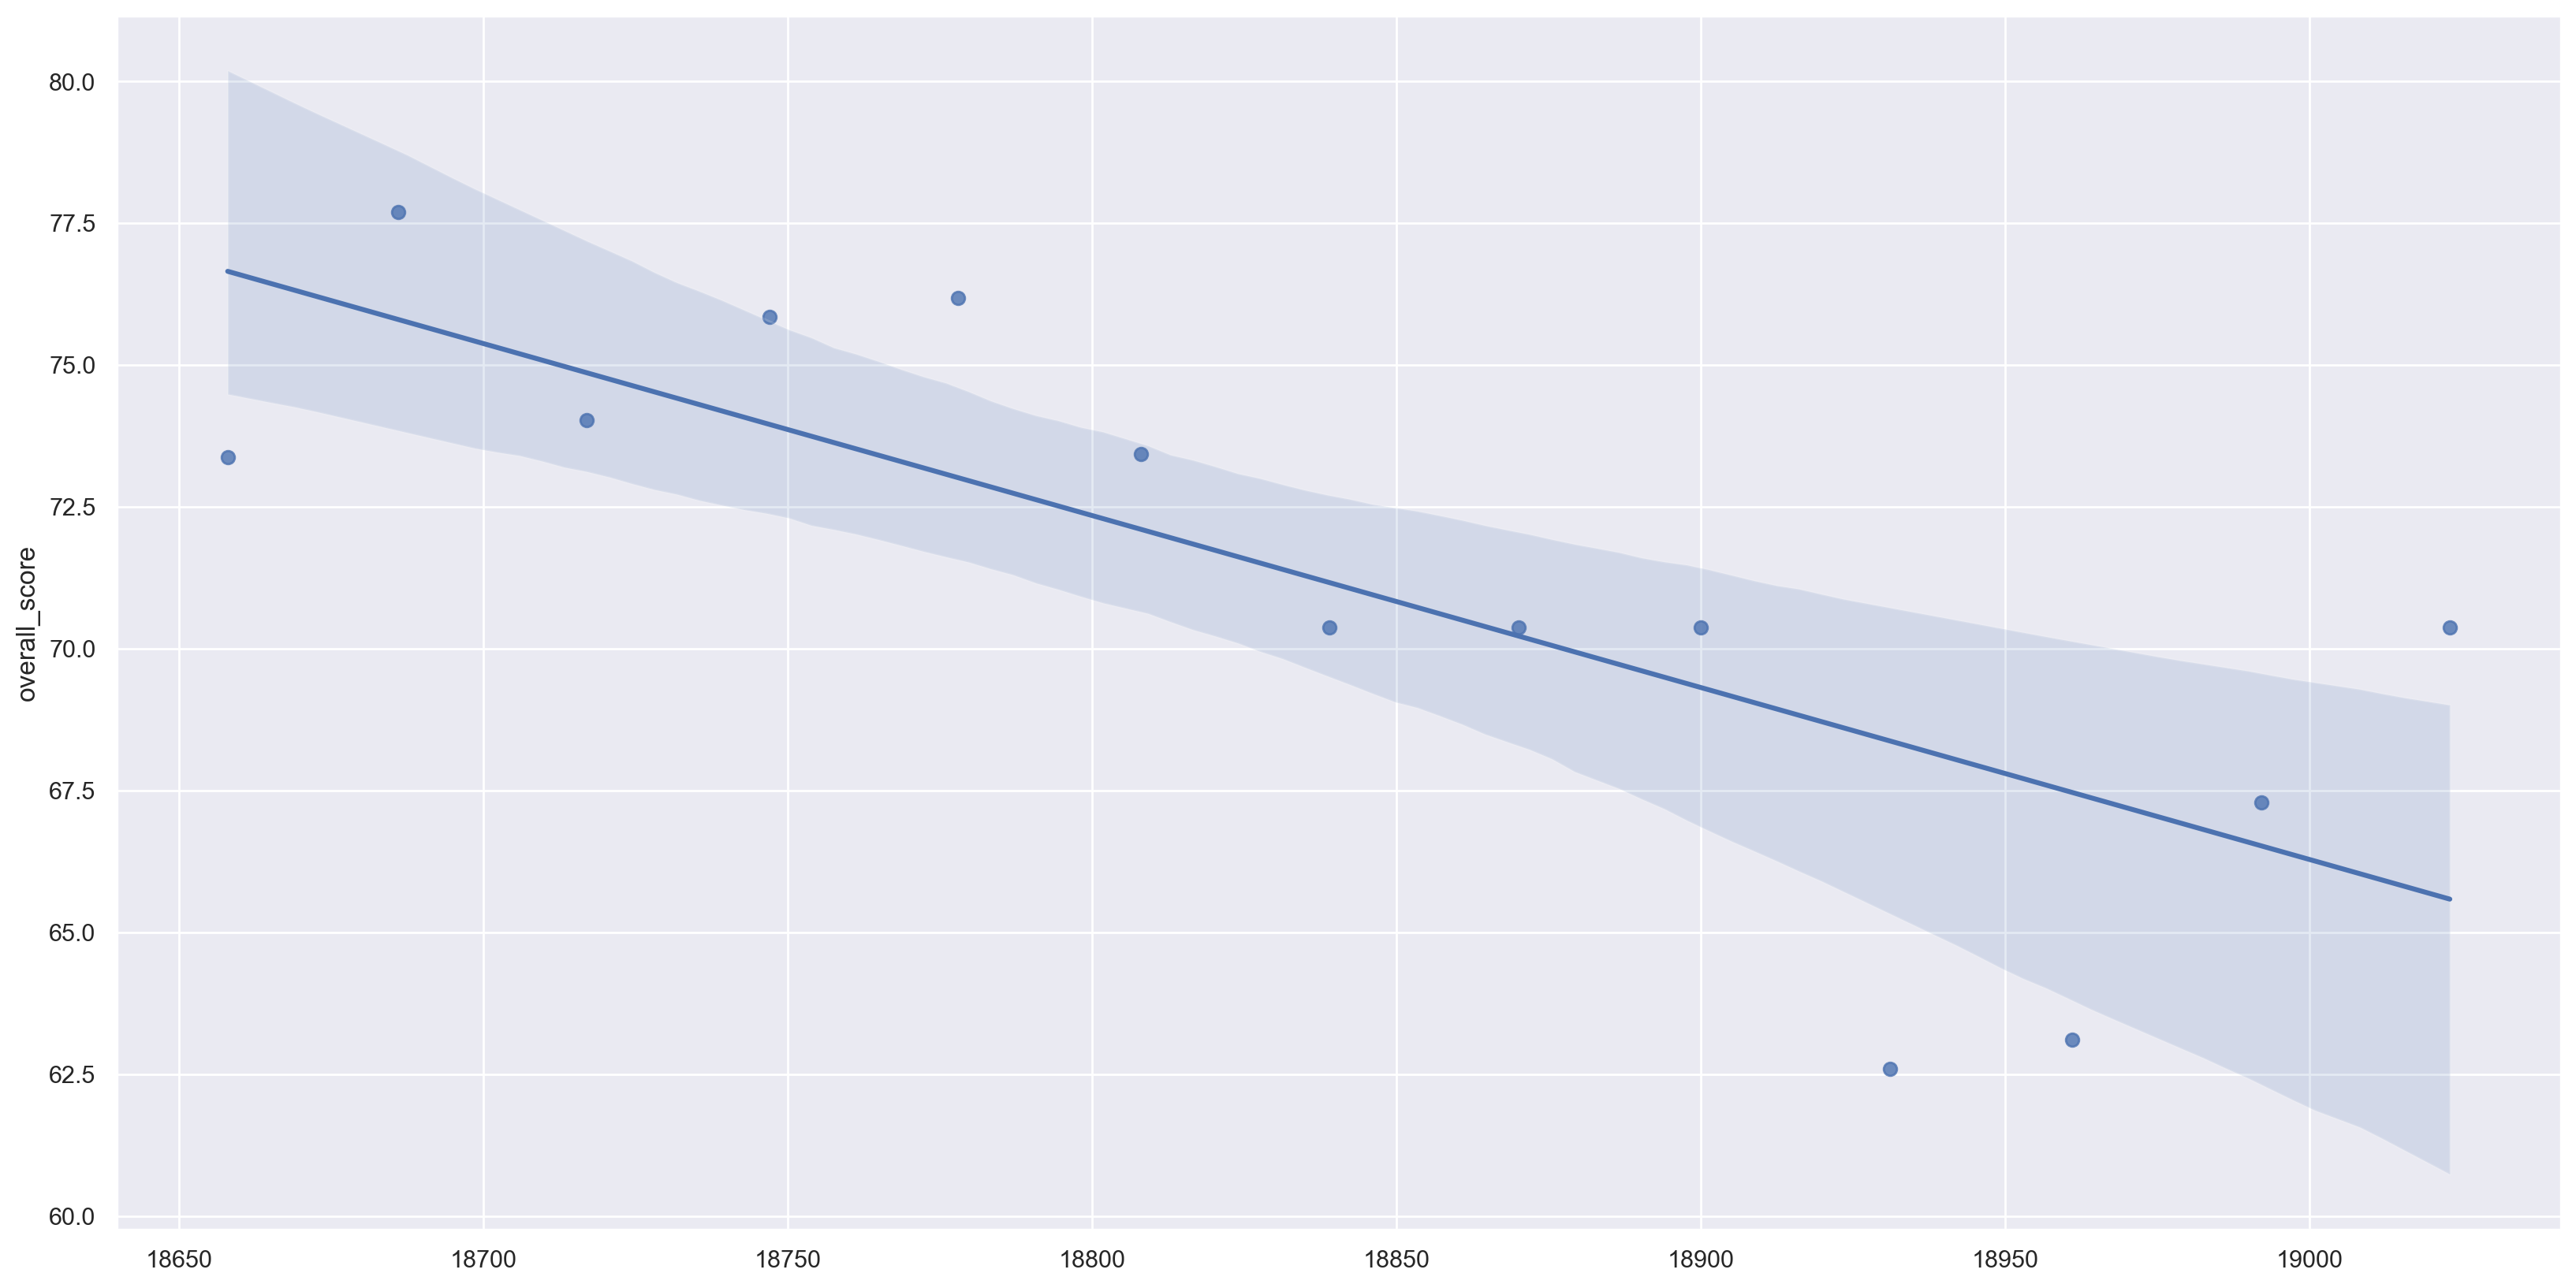

In [224]:
# Slice the data on a monthly basis average for the period '2021-01-01':'2022-01-01'
monthly_average_short = score.loc['2021-01-01':'2022-01-01'].resample('M').mean()

# Plot and customize first subplot
monthly_average_short['overall_score'].plot(figsize=(20,10))

# Show plot
plt.show()

# plot chart (wiht matplotlib conversion of timestamp to readible numeric values - caused error without conversion)
sns.regplot(data=monthly_average_short, x=dates.date2num(monthly_average_short.index), y="overall_score")

## 8. Combining everything together

In this secion I decided to combine the two datasets (related to 'minutesAsleep' and 'score') in order to
look at the relationship between the features we previously analyzed in the hope to reveal
some additional insights about my sleep. As revealed earlier, during the analysis I had theroized that 
'deep_sleep_in_minutes' should be correlated significantly to 'overall_score', that what made sense to me -
if you have more minutes when one is in deep-sleep (regardless of how long) you should achieve a better sleep.

In [228]:
# Concatenate the two datasets using the same index (date of sleep)
all_sleep = pd.concat([df, score], axis=1)

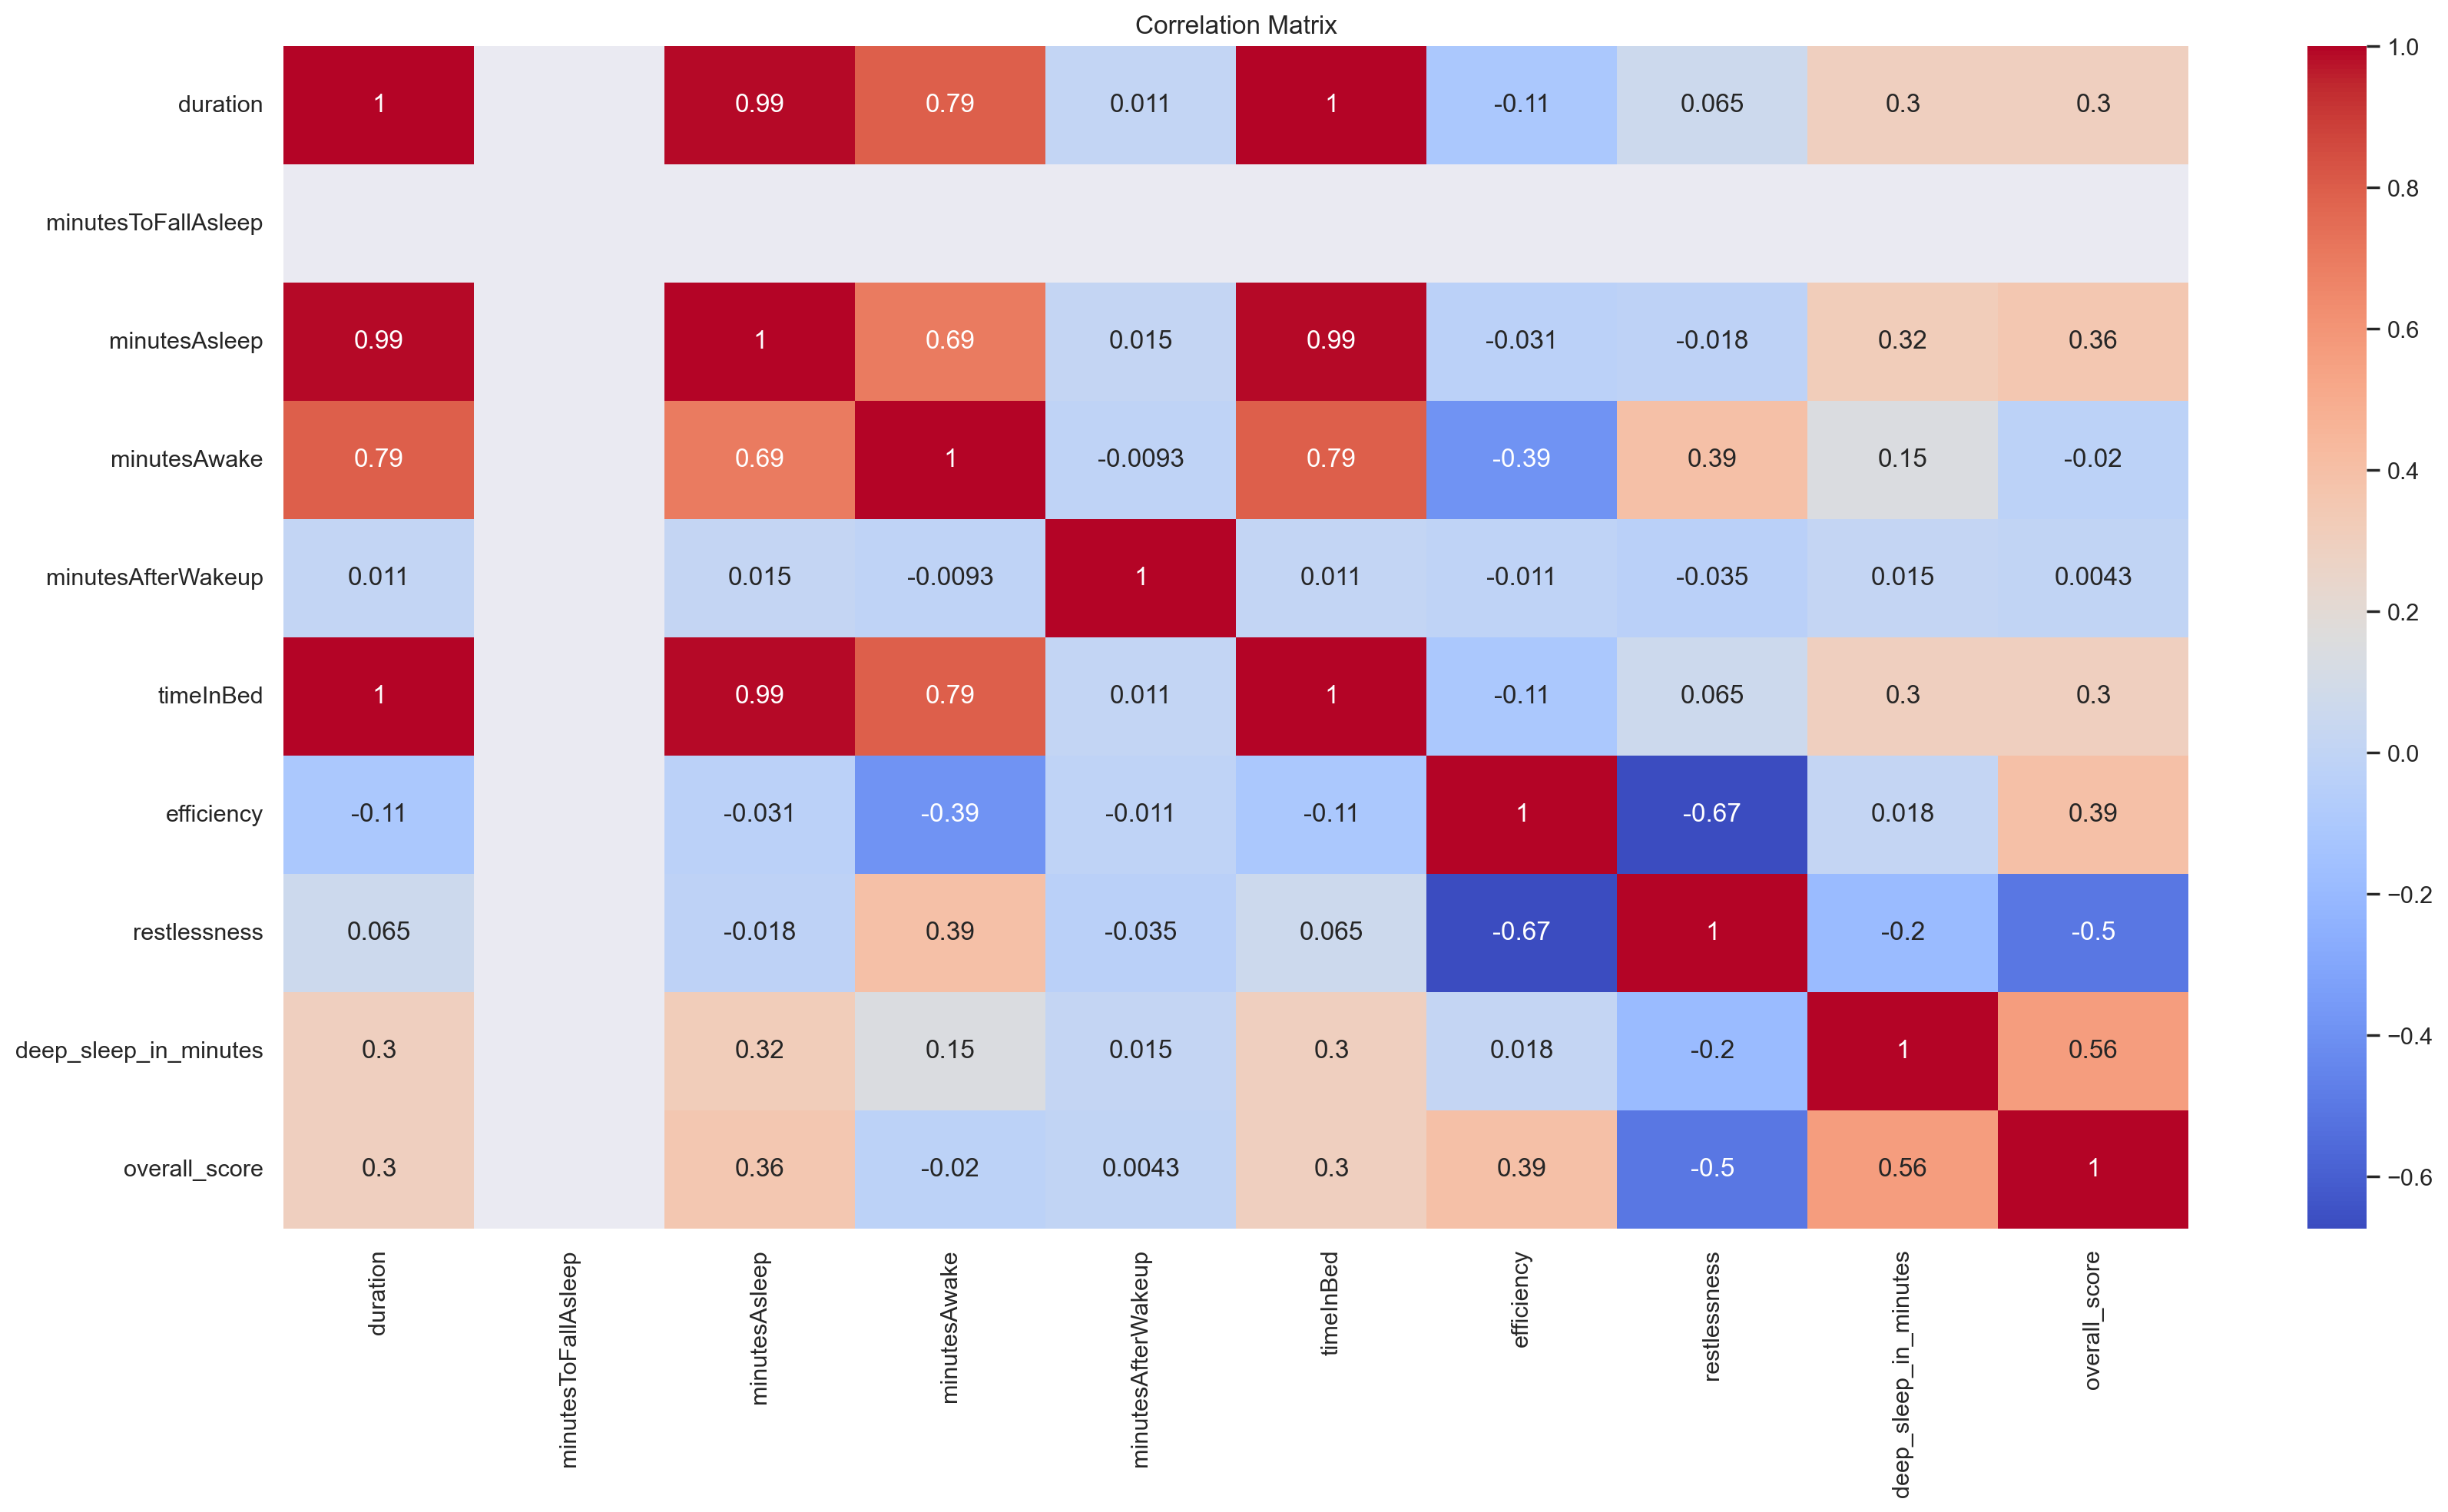

In [230]:
"""
   Result:
    The relationship between 'overall_score' and 'deep_sleep_in_minutes' has a positive relation of 0.56.
    I was surprised as I expected a higher positive correlation.
"""

# Correlation Matrix between the features of the combined dataset
correlation_matrix = all_sleep.corr()

# Display the Correlation Matrix as a heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Matrix')

# Display the matrix
plt.show()

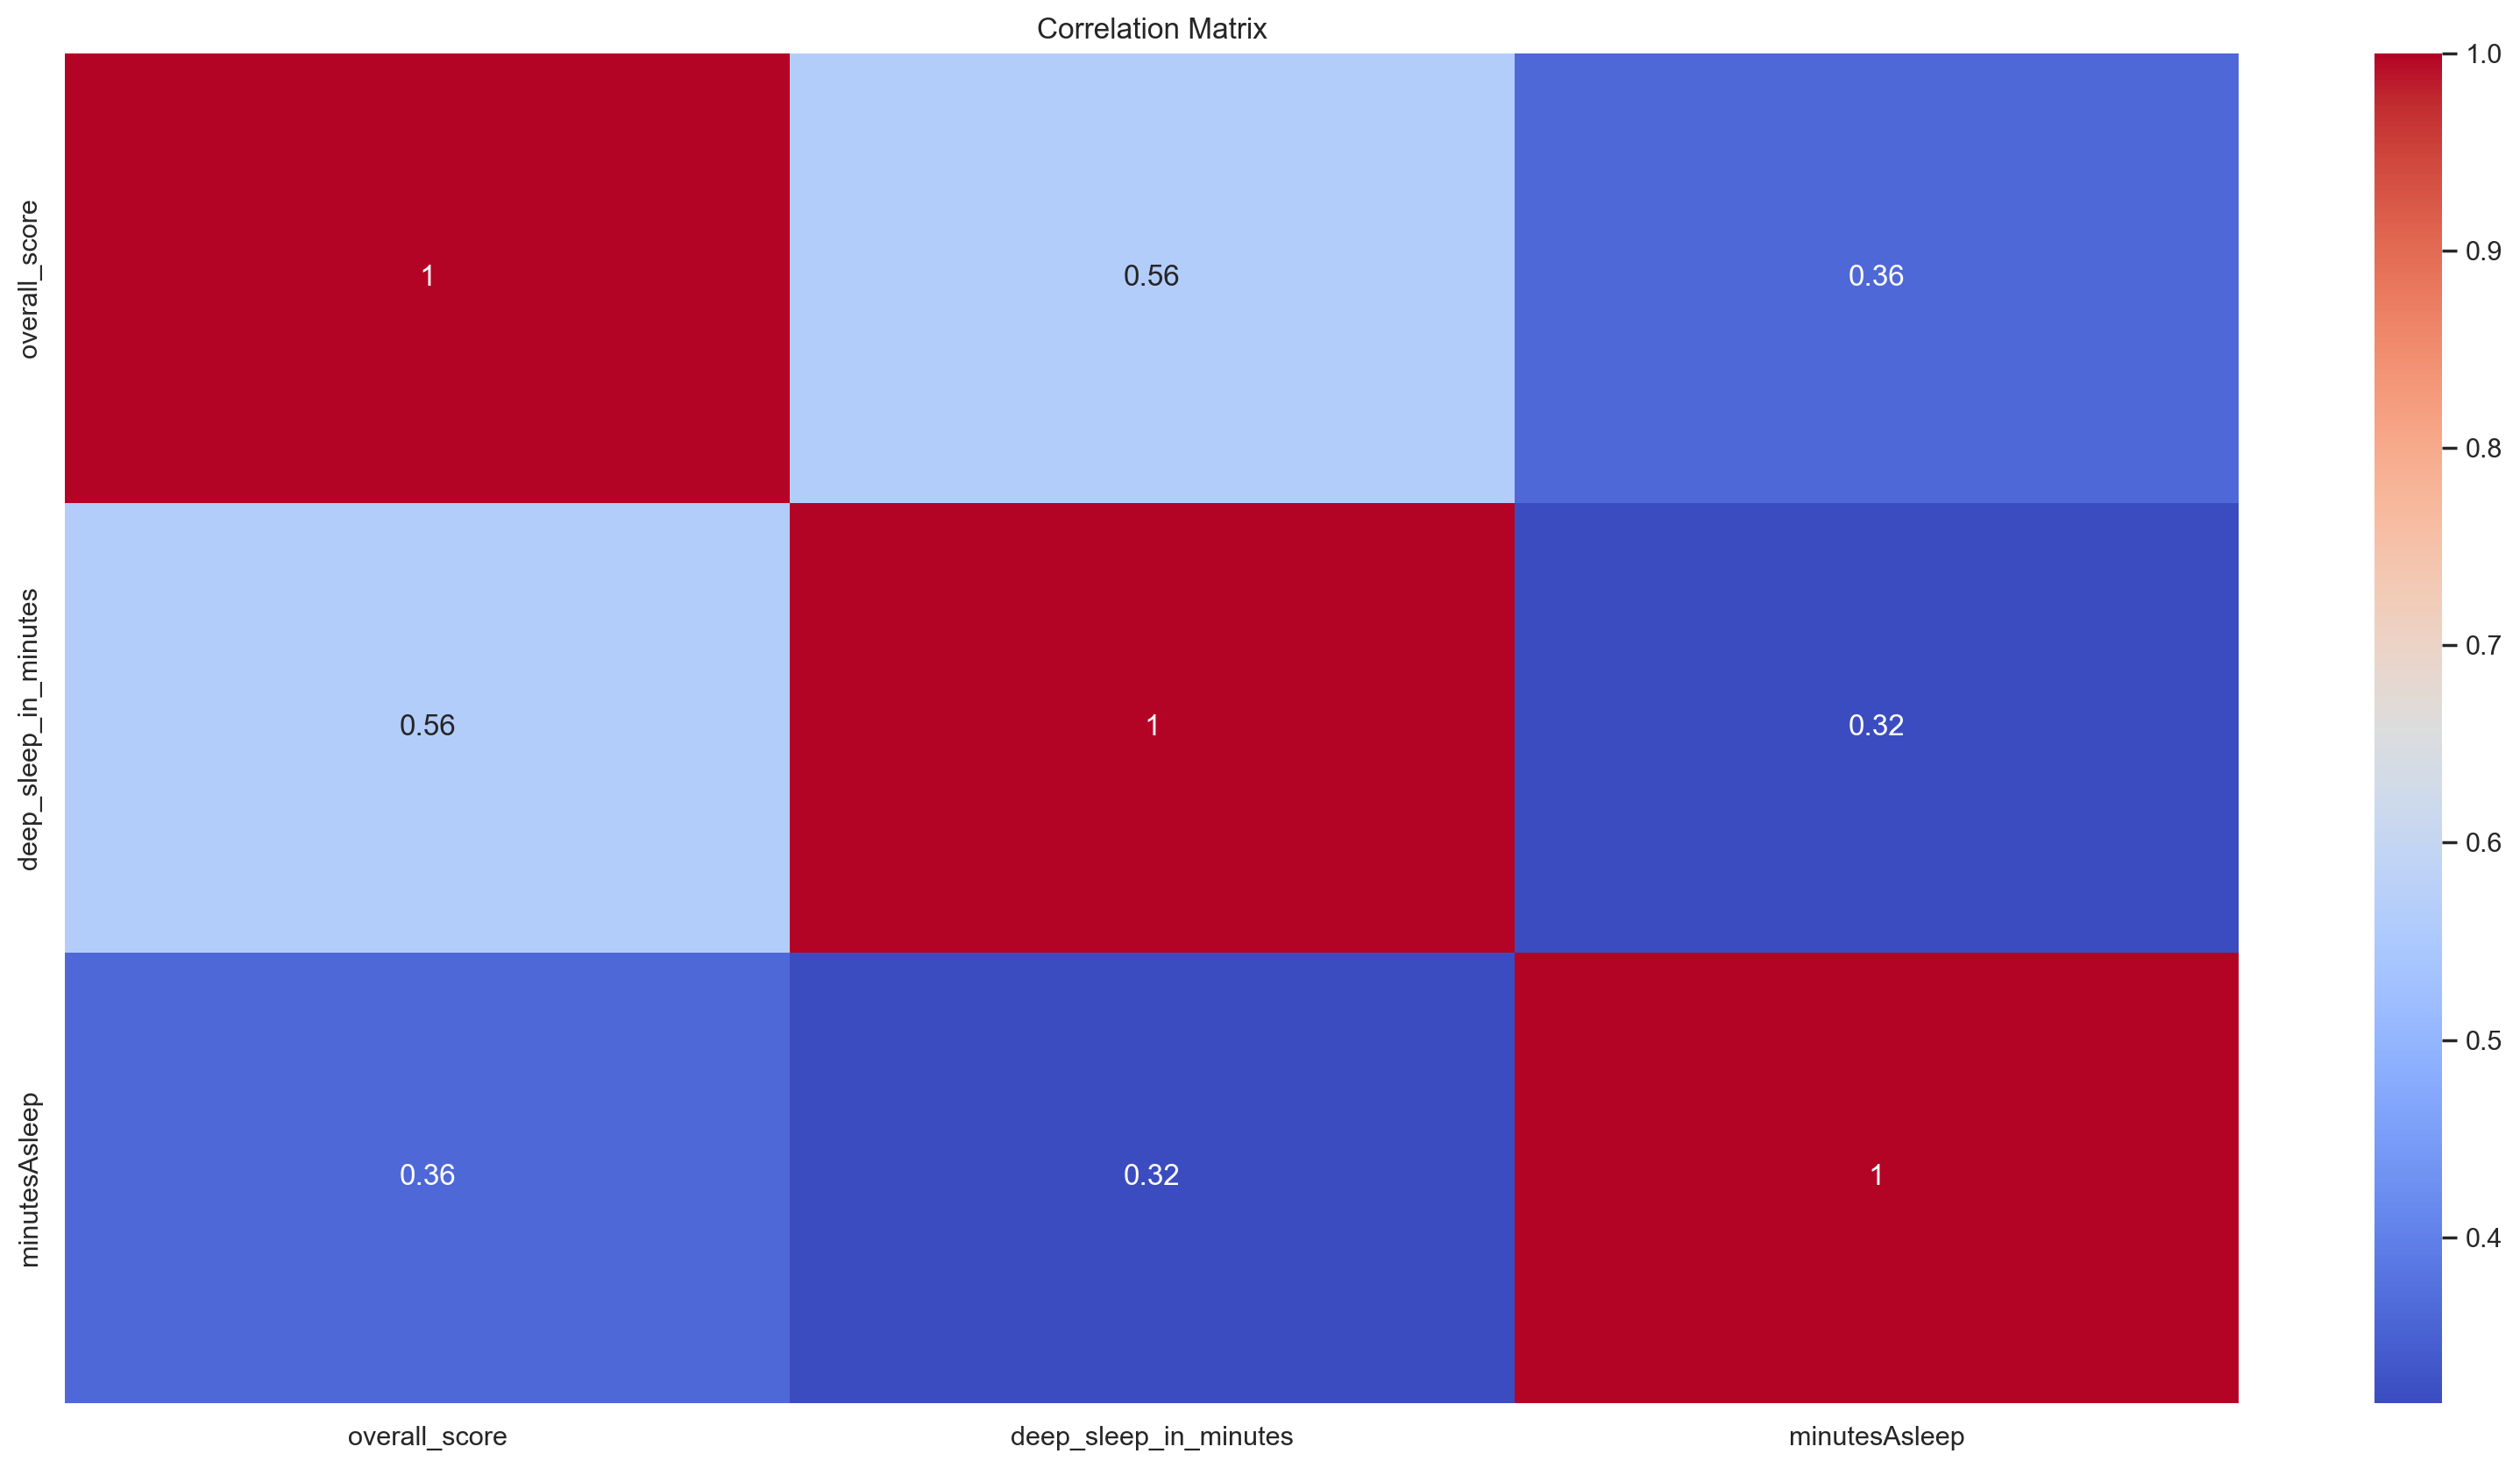

In [261]:
"""
   Investigating correlation on a smaller feature set in order to focus on the variables I 
   have decided to look into.
   
   'overall_score','deep_sleep_in_minutes', 'minutesAsleep'
   
   Result:
    The relationship between 'overall_score' and 'deep_sleep_in_minutes' has a positive relation of 0.56.
    I was surprised as I expected a higher positive correlation.
"""

# Correlation Matrix between the features of the combined dataset
correlation_matrix = all_sleep[['overall_score','deep_sleep_in_minutes', 'minutesAsleep']].corr()

# Display the Correlation Matrix as a heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Matrix')

# Display the matrix
plt.show()

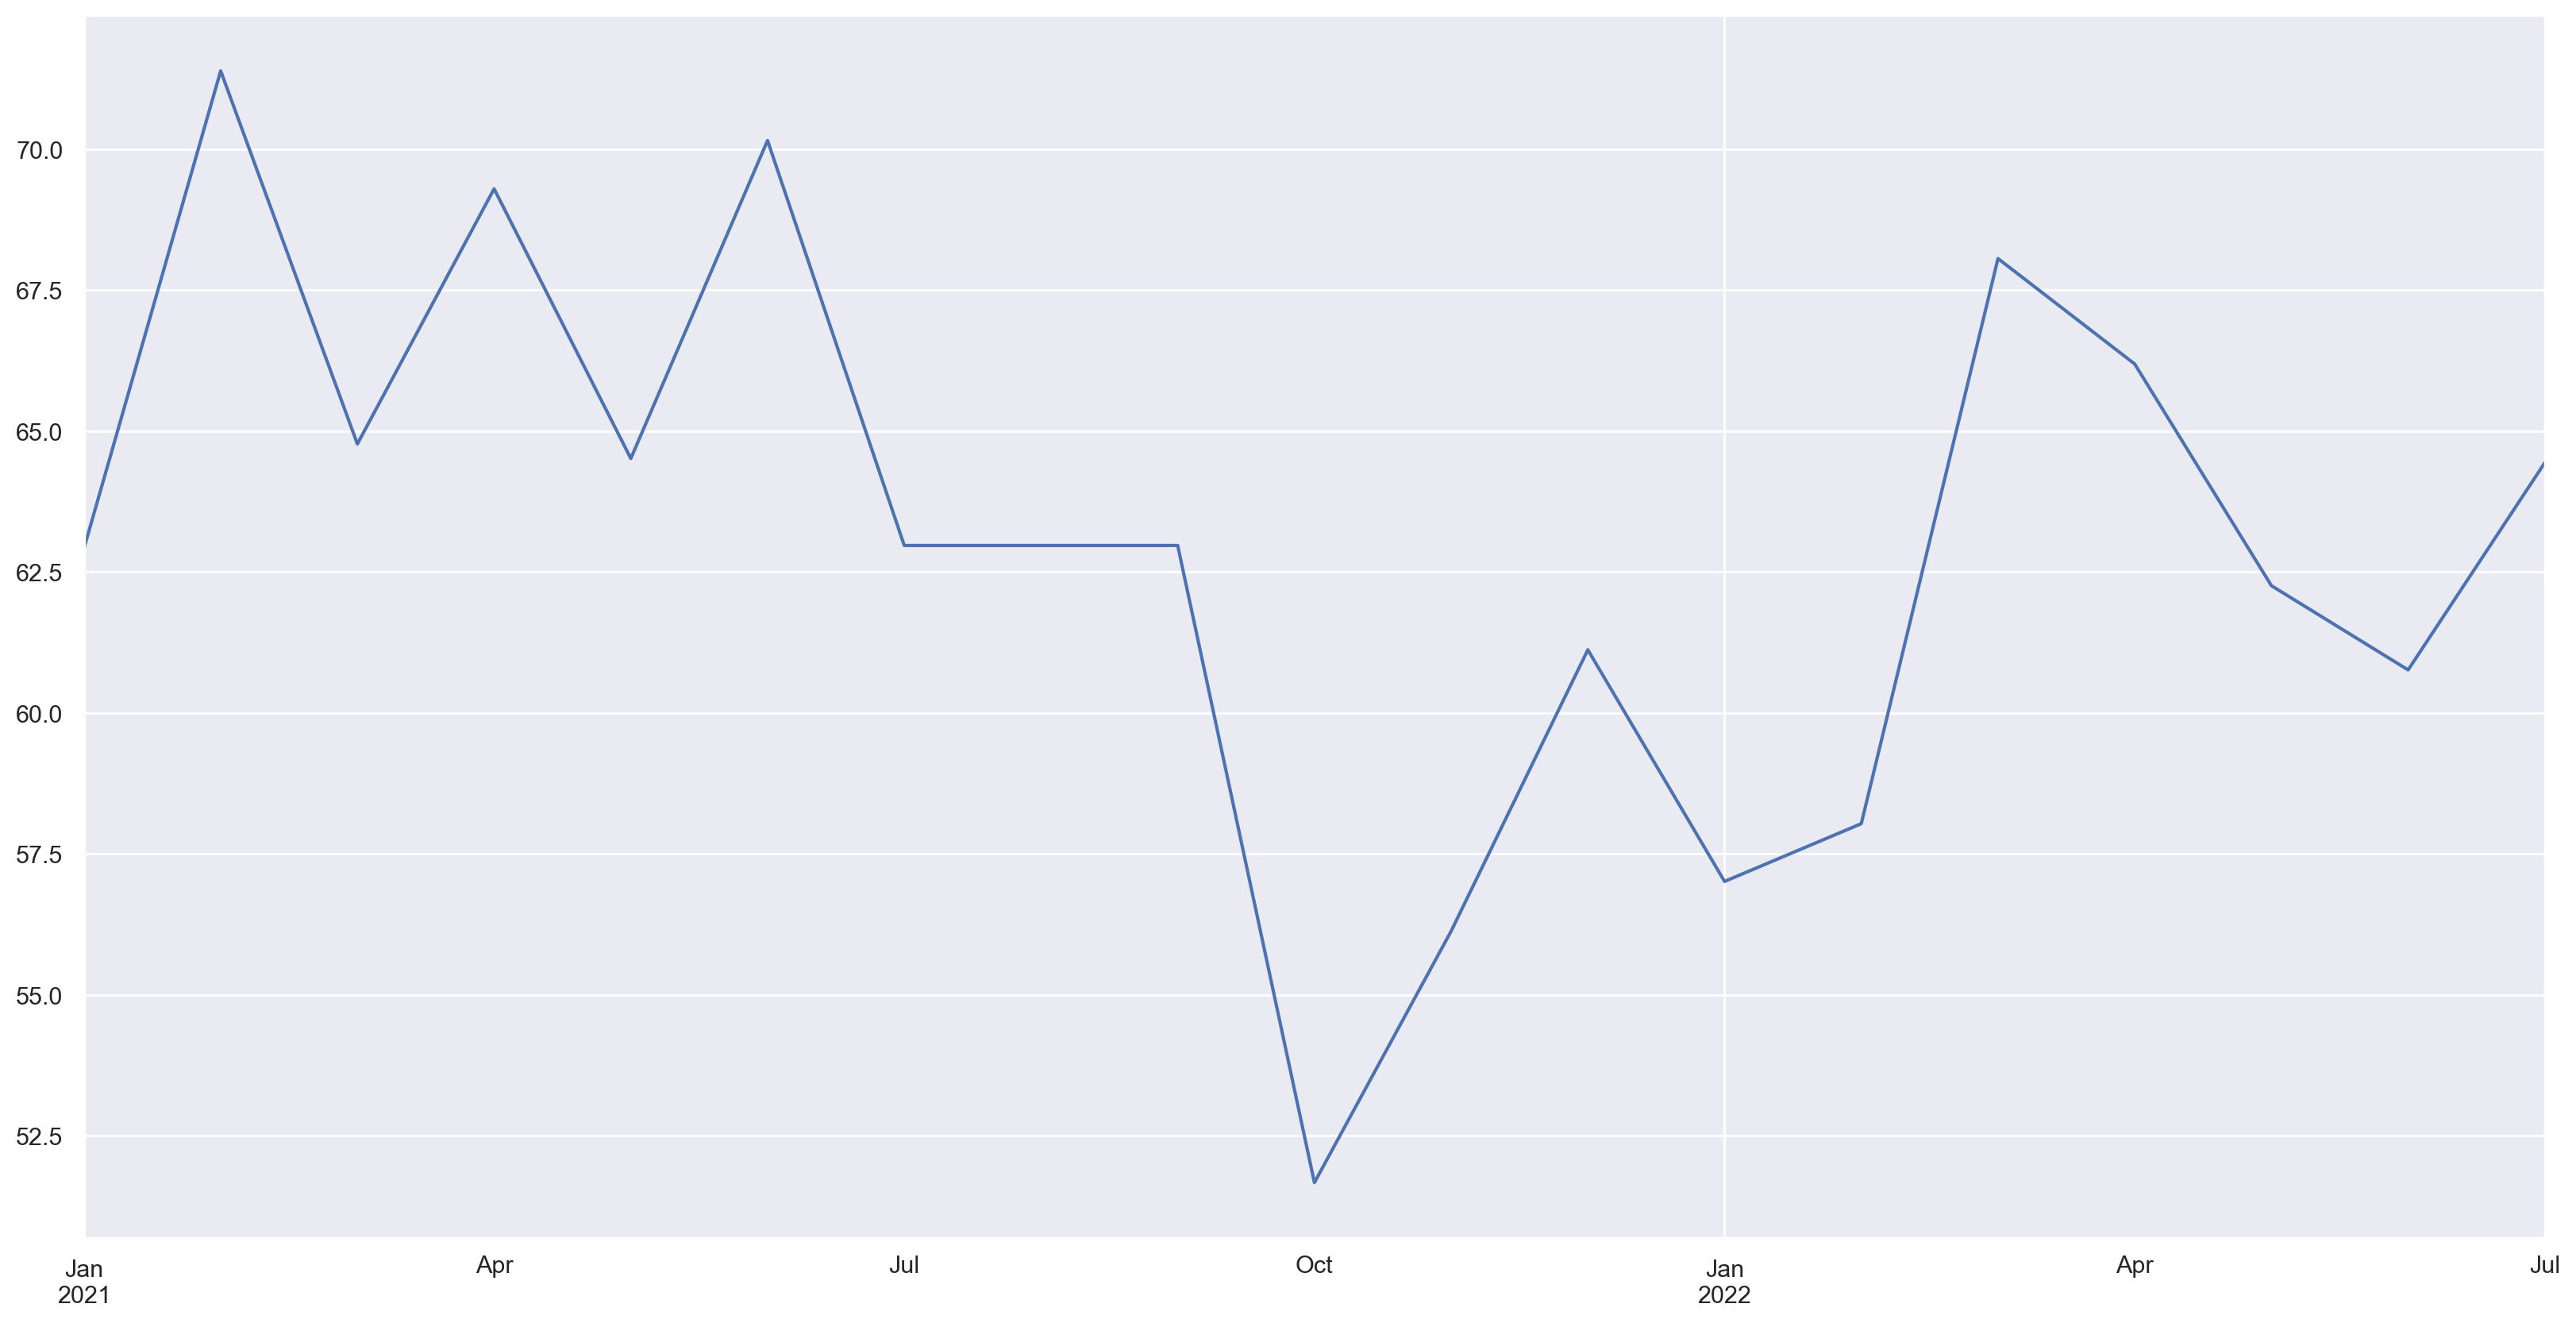

<AxesSubplot:ylabel='deep_sleep_in_minutes'>

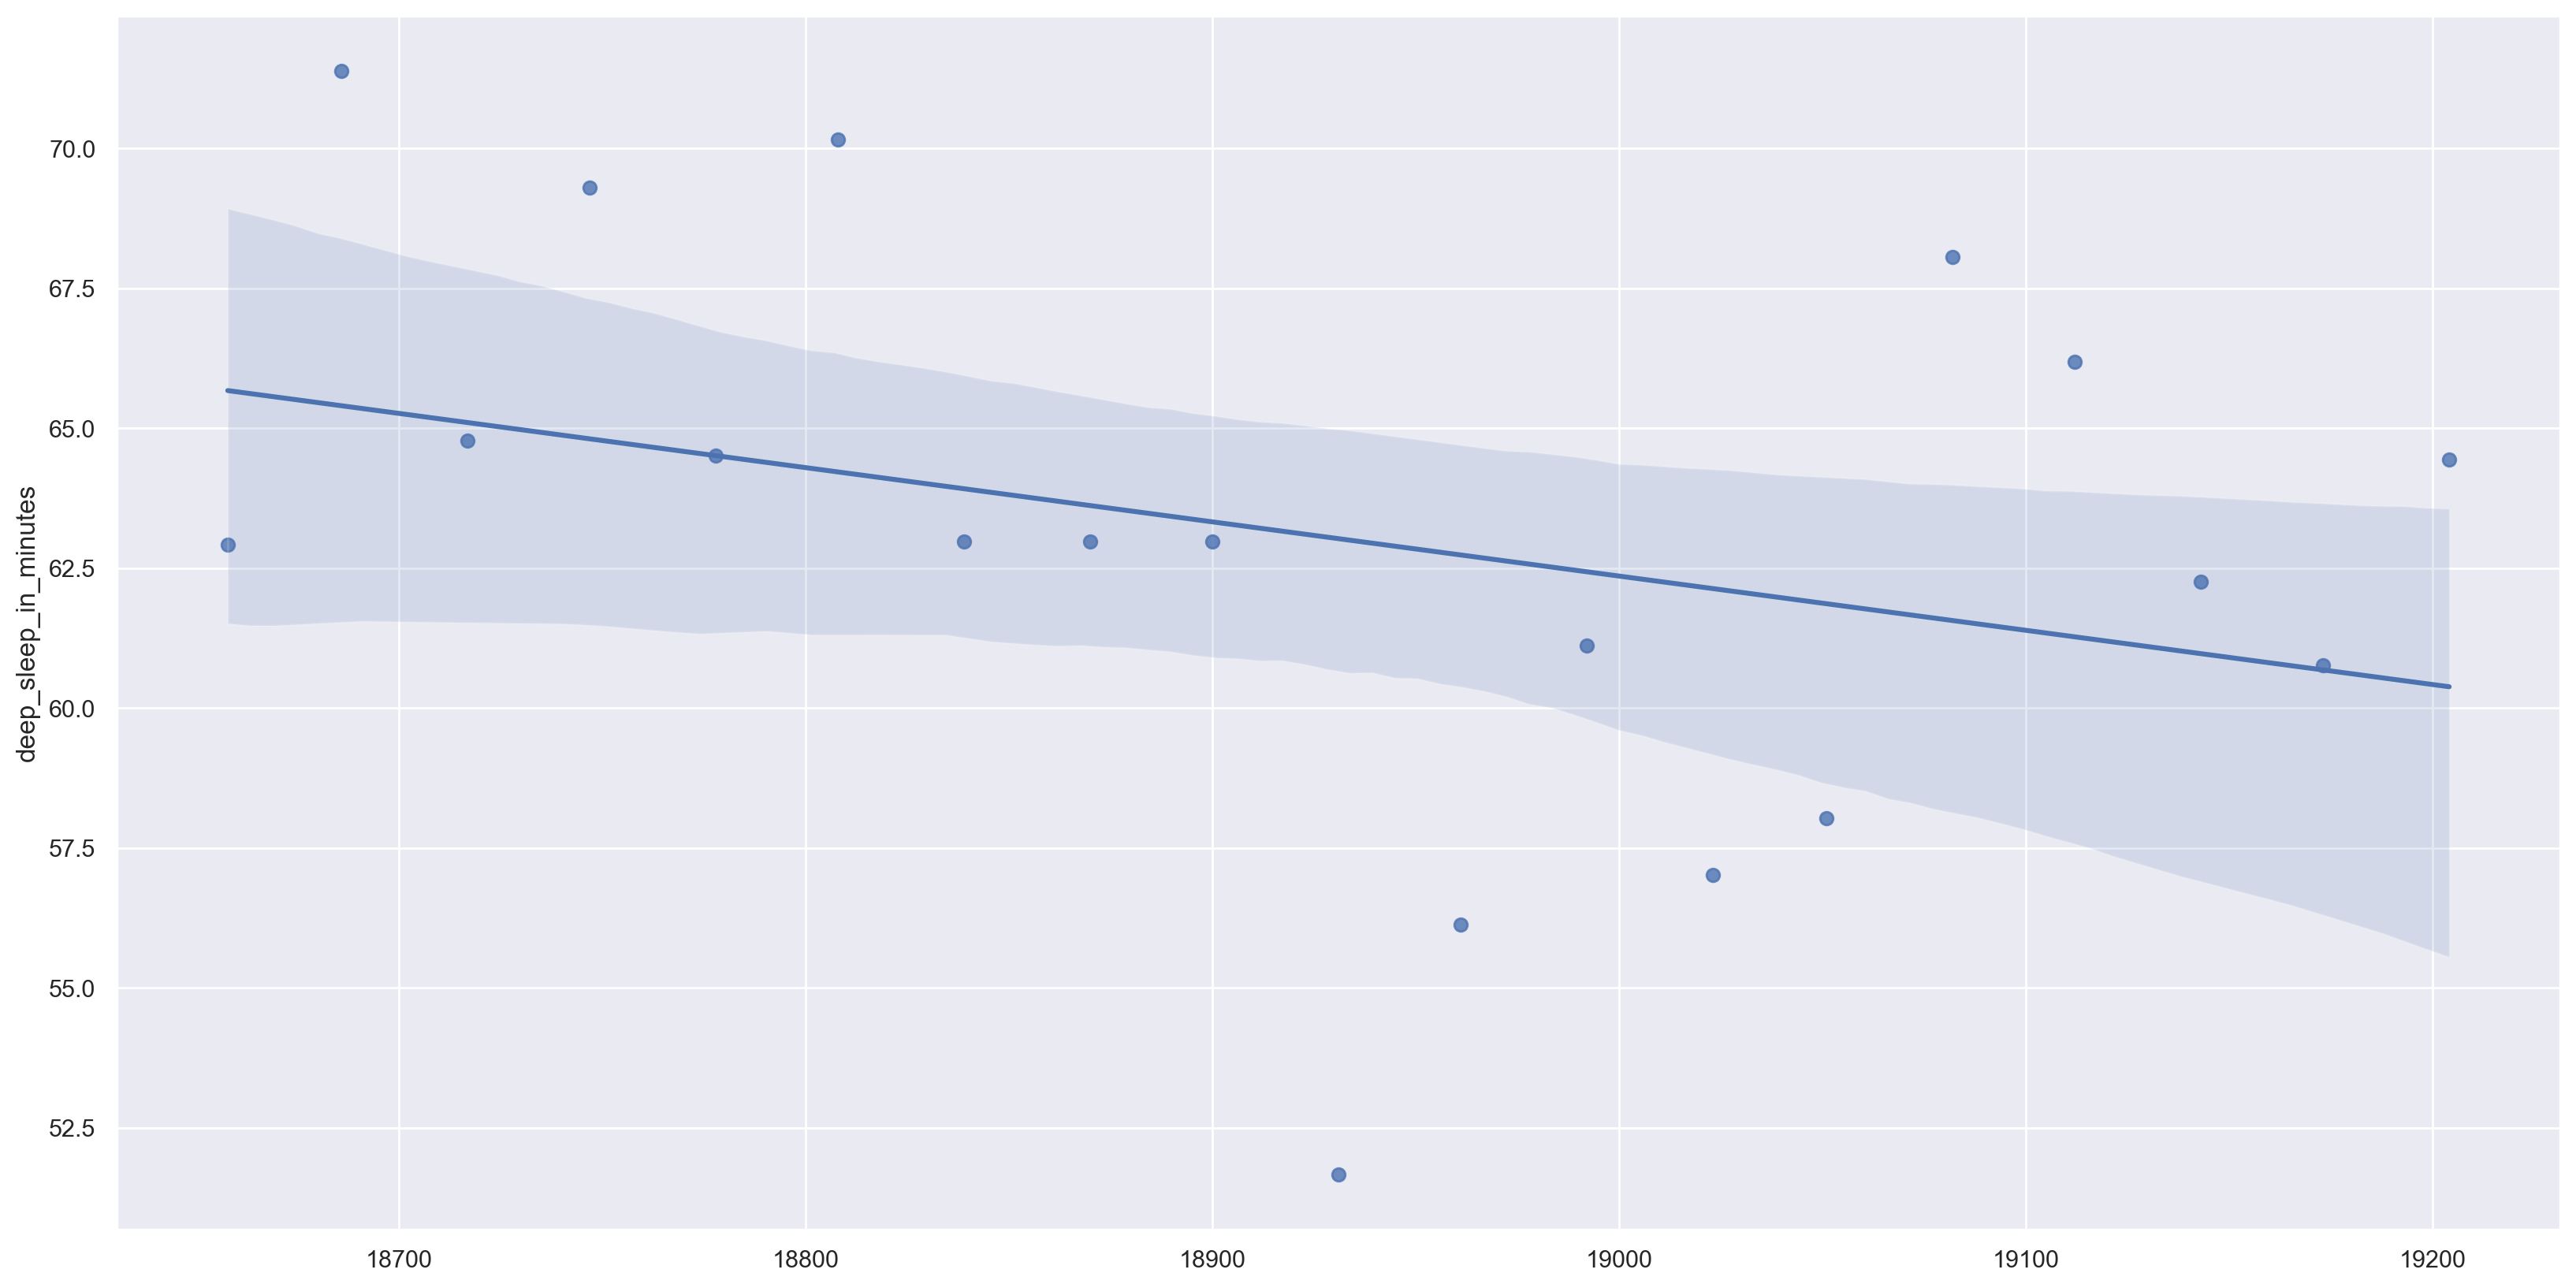

In [262]:
# Slice of data from the 10-2021 to 02-2022
monthly_average_short = all_sleep.resample('M').mean() #.loc['2021-01-01':'2022-02-01'].resample('M').mean()

# Plot and customize first subplot
monthly_average_short['deep_sleep_in_minutes'].plot(figsize=(20,10))

# Show plot
plt.show()

#define figure size
sns.set(rc={"figure.figsize":(20, 10)}) #width=20, height=10

# plot chart (wiht matplotlib conversion of timestamp to readible numeric values - caused error without conversion)
sns.regplot(data=monthly_average_short, x=dates.date2num(monthly_average_short.index), y="deep_sleep_in_minutes")
# sns.despine()

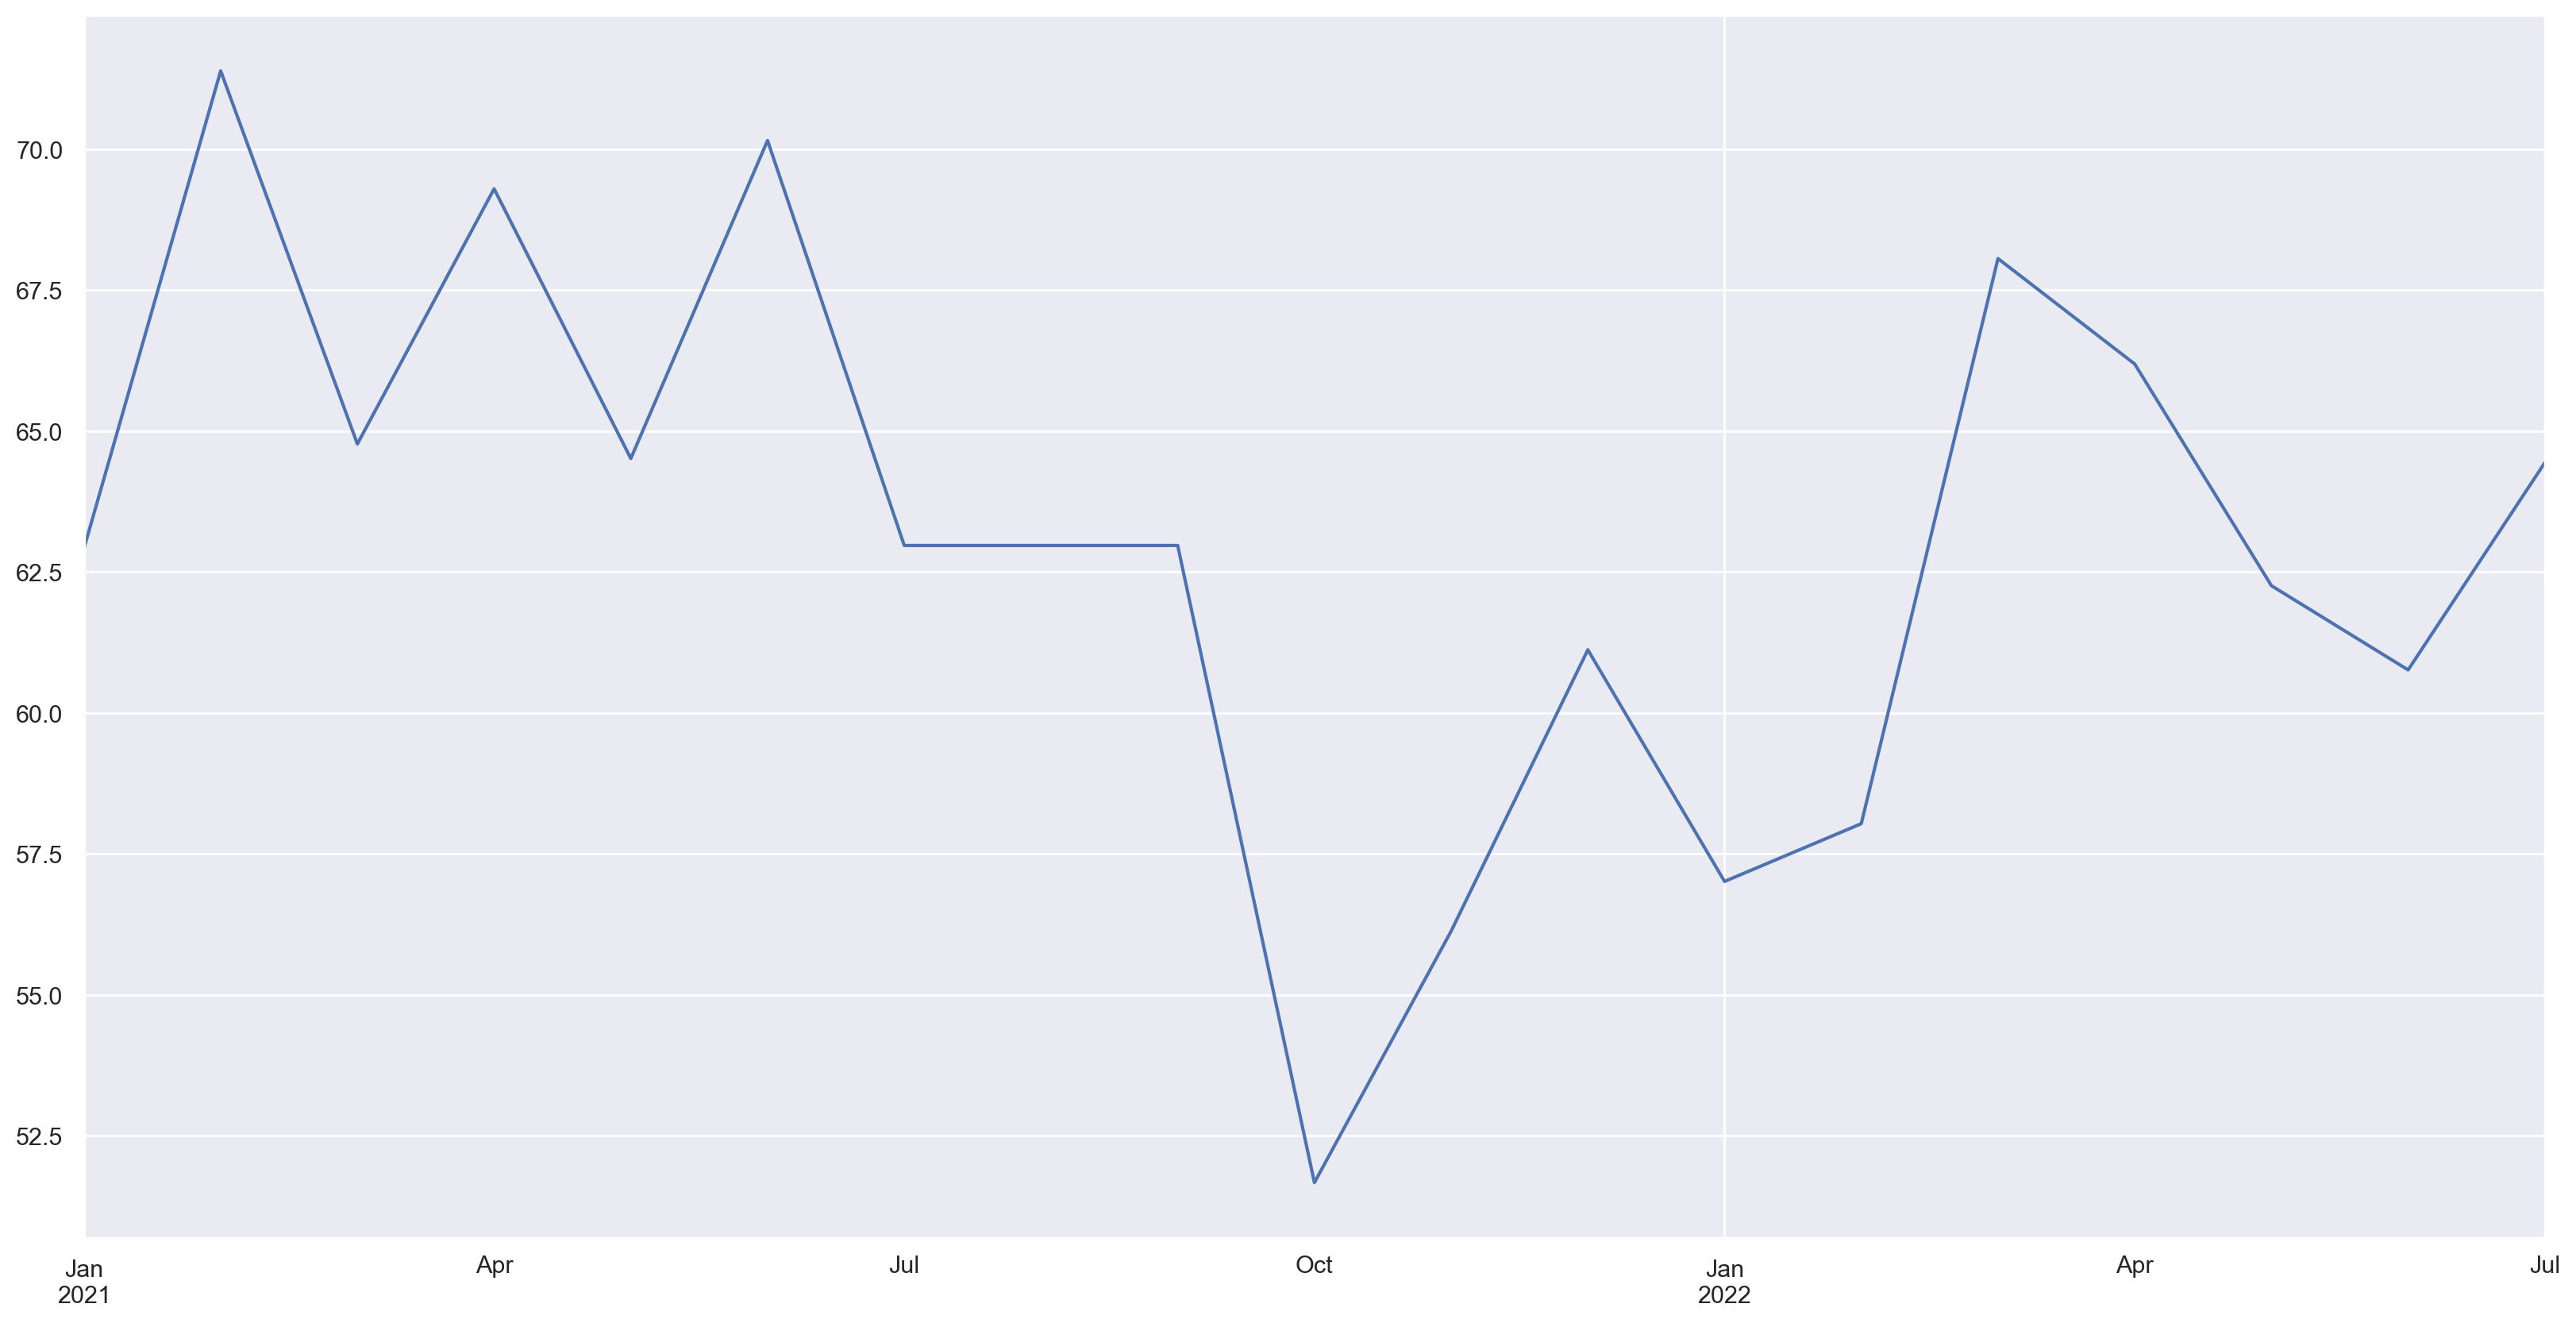

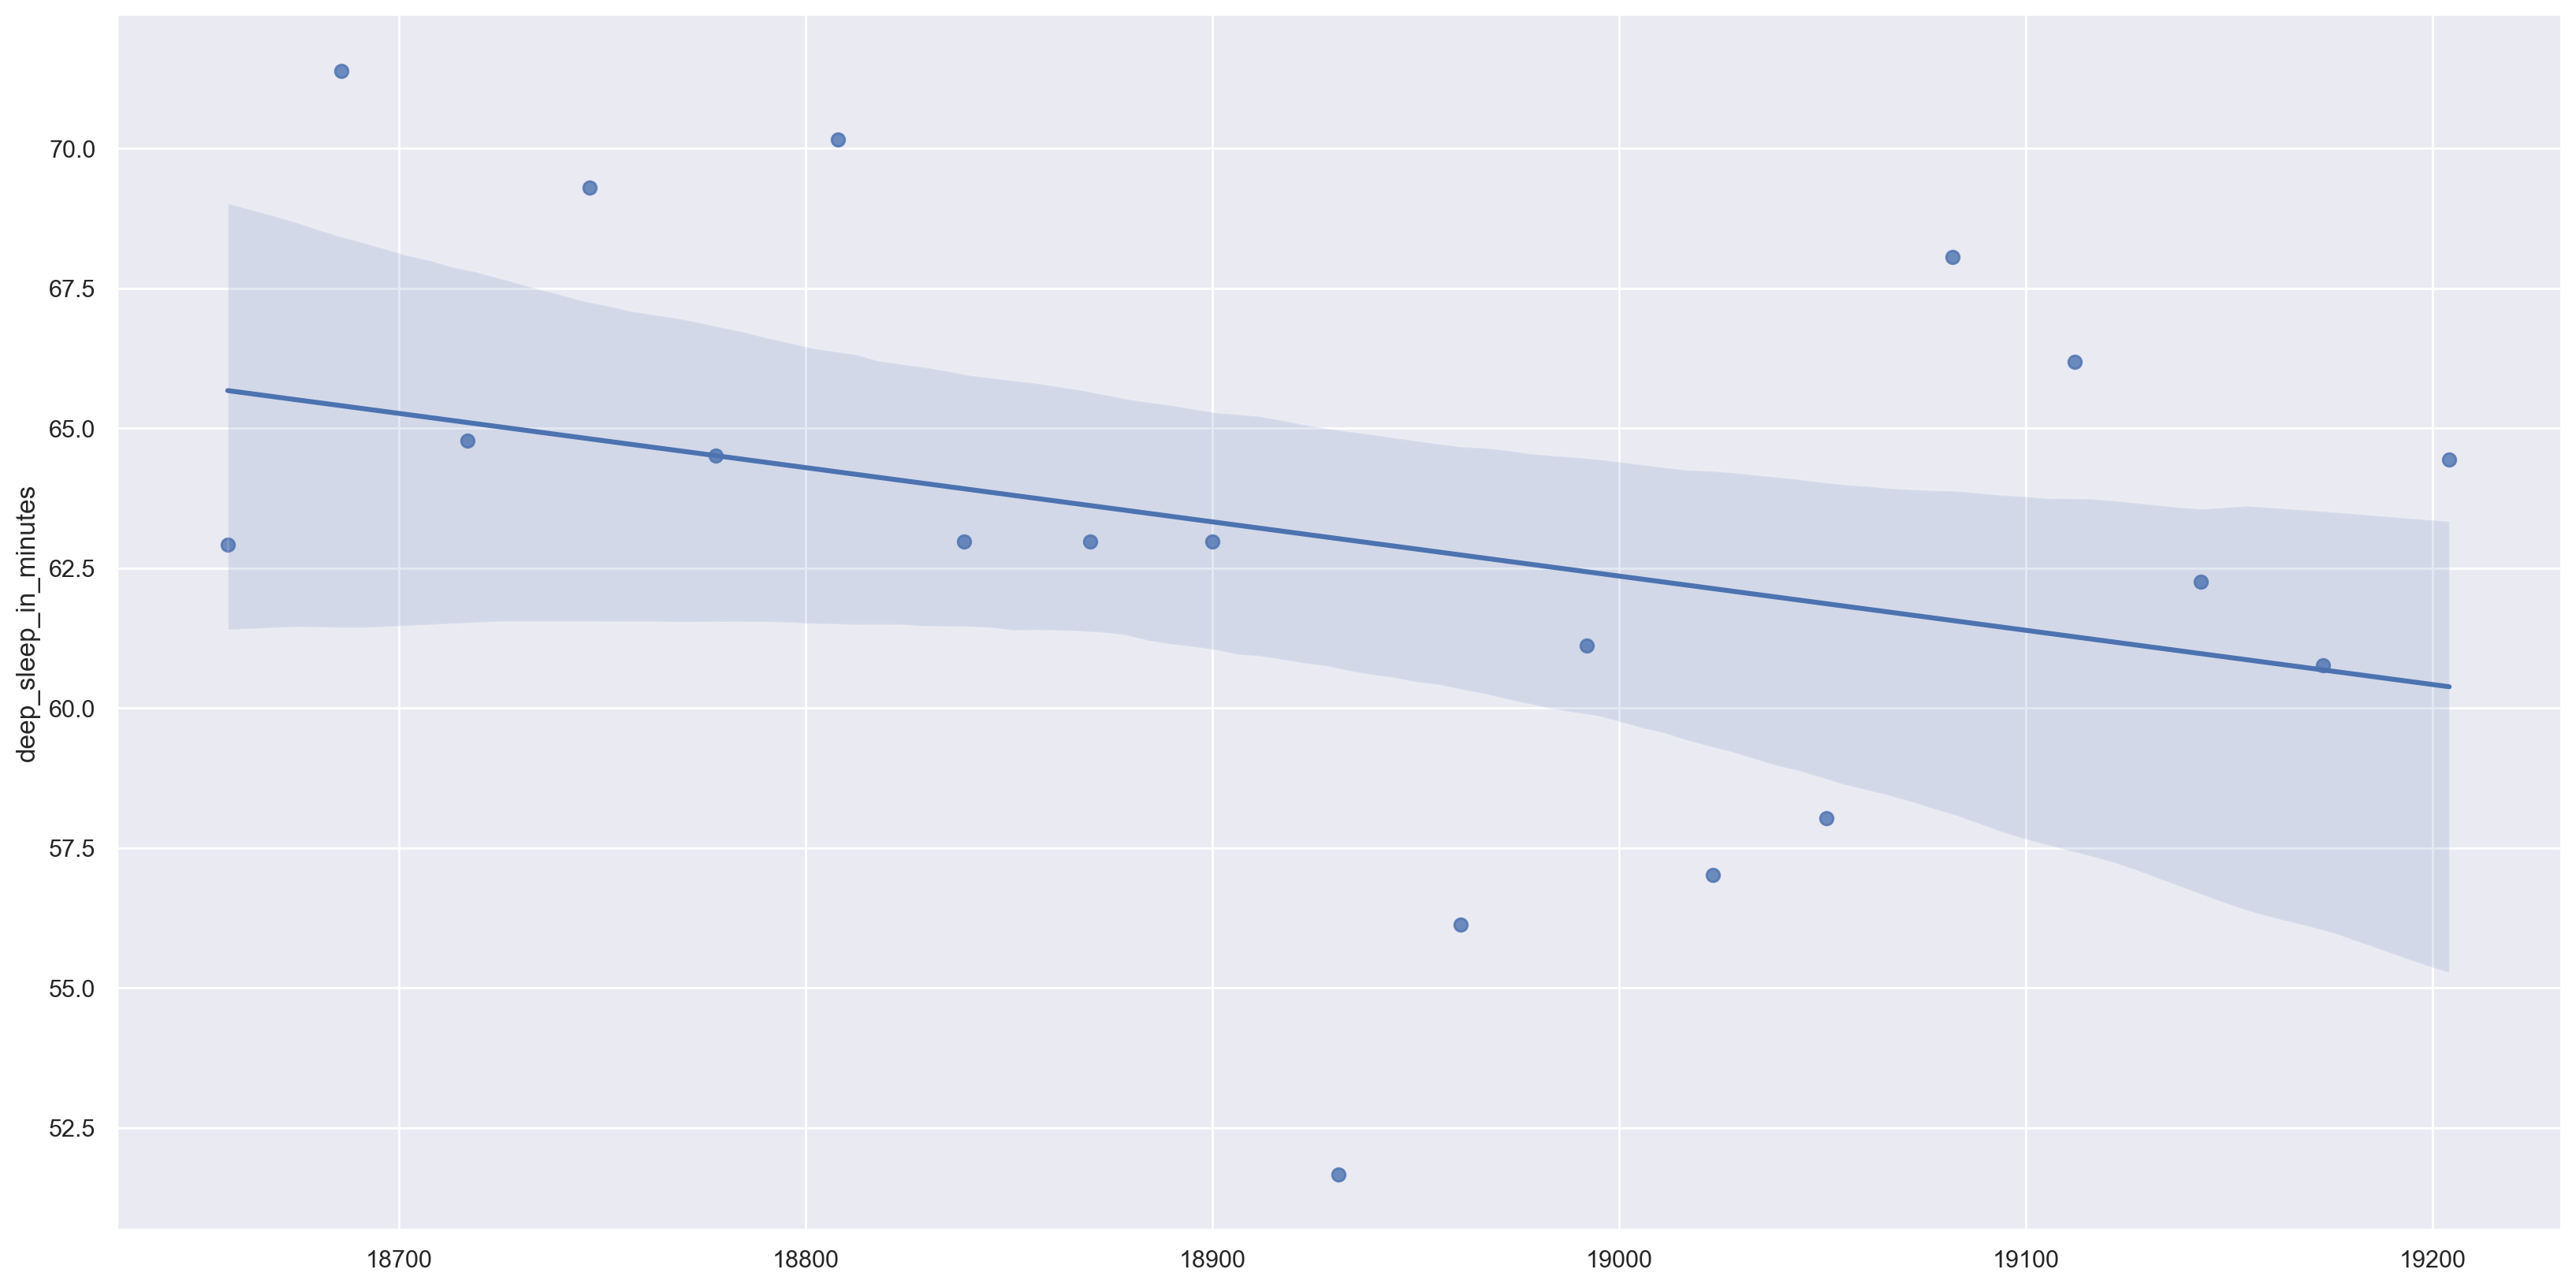

In [240]:
"""
    Here I try to look at the data from a monthly point of view, 
    tracking the 'deep_sleep_in_minutes' variable overtime.
"""

# Combined data with an averagine (mean) by month 
minutes_asleep_short = all_sleep.resample('M').mean()

# Plot and customize first subplot
minutes_asleep_short['deep_sleep_in_minutes'].plot(x='deep_sleep_in_minutes', y='index',figsize=(20,10))

# Show plot
plt.show()

# Plot chart (wiht matplotlib conversion of timestamp to readible numeric values - caused error without conversion)
sns.regplot(data=minutes_asleep_short, x=dates.date2num(minutes_asleep_short.index), y="deep_sleep_in_minutes")
sns.despine()

## 9. Summary and fun facts

To summarize, let’s pick some fun facts out of the summary tables.

The dataset represents the period if time between the 7th of January 2021 and the 18th of July 2022 (albiet with period of time where I wasn't wearing the device so data does not exist for those days) which represents 1 year, 6 months, 11 days. During that period a life-changing event occured, the birth of my child, which initiated the interest for myself to understand whether the data showed a 'significant' decrease in sleep quality around the time of the birth to support the feeling of us seemingly tired.  

#### FUN FACTS

- Average sleep in hours*: 6.66 hours (= 399.98/60)

- Longest sleep in hours*: 15.46 hours (= 928.0/60)

- Shortest sleep in hours*: 1.83 hours (= 113/60)

- Average sleep in hours* (before birth): 6.94 hours (= 416.58/60)

- Average sleep in hours* (after birth):  6.42 hours (= 385.76/60)

- Average Overall Score*: 70.37

- Average Overall Score* (before birth): 73.58

- Average Overall Score* (after birth): 67.61 

note*: all results relate to a period of 24 hours.


### Findings and thoughts

#### Overall Score: 

The average score is around 70.37, with a minimum of 43 and a maximum of 87.

#### Deep Sleep: 

On average, I get about 62.97 minutes of deep sleep, with a minimum of 12 minutes and a maximum of 125 minutes.

#### Correlations:

There's a positive correlation between overall score and deep sleep duration, suggesting that nights with more deep sleep tend to have higher sleep quality scores. However, the positive relationship is not as significant as I had anticipate (0.56). That being said, it does not mean that a more strong relationship exists outside this dataset.
Conversely, Restlessness has a negative correlation with the overall score, indicating that higher restlessness leads to a lower sleep quality score.

#### Trends Over Time:

There doesn't seem to be any consistent upward or downward trend in the overall sleep score over the provided dates. This suggests that the sleep quality has remained relatively stable over this period.
The deep sleep duration also seems to fluctuate without a clear trend.


#### Missing data points:

I had to backfill 163 days worth of data in a period where there were 558 days (30% +/-). The need to backfill that proportion of data may have well resulted in the inconclusive but suggestive manner of the data depicting a change in the quality of sleep.
It is clear that the method of backfilling (taking the overall mean) attributed to the skew in the distribution of the data points - in this case skewing features to the right. 
Perhaps in another iteration, I should look into backfilling the data differently, as an example, taking the average of X (x as the feature) within the month or within a 3 month period and not in the overall period, to reduce the effect of skewing the data and anlaysis.

#### Bottom line:

Within the analyzed period (7th of January 2021 and the 18th of July 2022), there are 163 days where not data is available for - this comes to almost 30% of time. Combined with the fact that there is no data around the time of the birth for three months, in my opinion hinders the ability to make a conclusive and complete statement regarding whether my sleep was affected significantly or not during this period of time.

That being said, there are signals suggesting there was a negative change in the quality of sleep as I examined the overall_score, minutesAsleep and deep_sleep_in_minutes features of the dataset.

 - The 'minutesAsleep' regression we can identify a downwards sloping regresion lines, indicating that over time the amount of sleep decreased.
     - This point is strengthed by the average sleep based on the 'minutesAsleep' feature before and after the birth (6.94 hours vs 6.42 respectively).
 - The 'overall_score' regression plot shows clearly that there was a decline in the sleep score overtime during this period.
     - This point is strengthend by the average overall_score that I calcualted in the period before and after the birth (73.58 and 67.61 respectively).
 - The 'deep_sleep_in_minutes' regression plot features once again a negative slope, indicating that it too overtime has decreased 

The data supports the hypothesis that the sleep has deteriorated during the period in question, however, due to the missing data especially surrounding the birth - I do not have the confidence to say unequivocally that this event (the birth and child) were responsible for the decline in sleep. 
Haven't said that, it is not necessarily the case that in reality this did not happen but the data I downloaded and analzed here before you just does not support this claim strongly enough.

#### Next steps:

- investigate other methods or ways of backfilling the missing values to reduce the effect of the distribution of data points across the features
- analyze the sleep data of my wife
